## Python programs

 - Storm event CG flash density fields at ~.25 km grid resolution and 5 minute time resolution.  2D Gaussian distribution of each CG flash.  
 - Storm tracking for CG flash density fields. 

The first step is making these ~.25km 5min grid slices. We will be using just one day of data for these

In [1]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [2]:
from region import *
from plotting import *
%matplotlib inline

In [3]:
pd.DataFrame(cities).T

,lat,lon,path,r
cedar,37.5908,-112.862,/home/jsignell/erddapData/Cloud_to_Ground_Ligh...,3
columbia,45,-119,/home/jsignell/erddapData/Cloud_to_Ground_Ligh...,4
denver,39.7867,-104.546,/home/jsignell/erddapData/Cloud_to_Ground_Ligh...,3
greer,34.8833,-82.22,/home/jsignell/erddapData/Cloud_to_Ground_Ligh...,3
phoenix,33.2892,-111.67,/home/jsignell/erddapData/Cloud_to_Ground_Ligh...,3
sterling,38.9753,-77.4778,/home/jsignell/erddapData/Cloud_to_Ground_Ligh...,3


In [4]:
c = Region(city=cities['cedar'])
c.define_grid(nbins=60)

In [5]:
ds = c.get_daily_ds('2014-09-26', func=None)

In [6]:
df = ds.to_dataframe()

In [7]:
df = df[df['cloud_ground']=='G']

In [8]:
df.index = df.time

In [95]:
tr = pd.date_range('2014-09-26 12:00', '2014-09-27 12:00', freq='5min')

In [96]:
d = {}
for i in range(len(tr)-1):
    grid, _,_ = np.histogram2d(df.lon[tr[i]:tr[i+1]].values, df.lat[tr[i]:tr[i+1]].values, bins=[c.gridx, c.gridy])
    d.update({tr[i]: grid.T})

In [97]:
box = np.stack(d.values())

This is the kind of shenanigans that we are dealing with. 

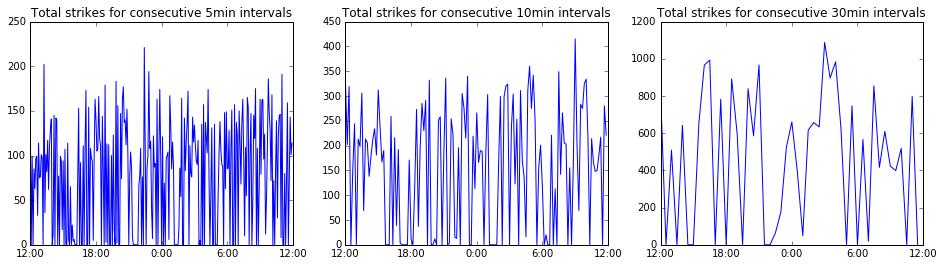

In [94]:
fig = plt.figure(figsize=(16,4))
n=1
for freq, per_hour in zip(['5min','10min','30min'], [12, 6, 2]):
    tr = pd.date_range('2014-09-26 12:00', '2014-09-27 12:00', freq=freq)
    d = {}
    for i in range(len(tr)-1):
        grid, _,_ = np.histogram2d(df.lon[tr[i]:tr[i+1]].values, df.lat[tr[i]:tr[i+1]].values, bins=[c.gridx, c.gridy])
        d.update({tr[i]: grid.T})
    box = np.stack(d.values())
    ax = plt.subplot(1, 3, n)
    ax.plot(np.sum(box, axis=(1,2)))
    ax.set_title('Total strikes for consecutive {freq} intervals'.format(freq=freq))
    ax.set_xlim(0, per_hour*24)
    ax.set_xticks([0, per_hour*6, per_hour*12, per_hour*18, per_hour*24])
    ax.set_xticklabels(['12:00', '18:00', '0:00', '6:00', '12:00'])
    n+=1
plt.show()


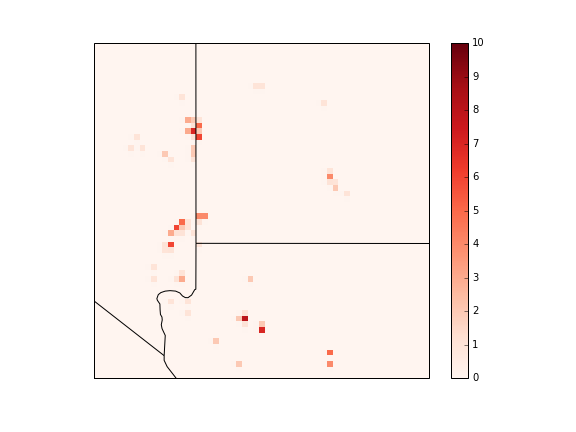
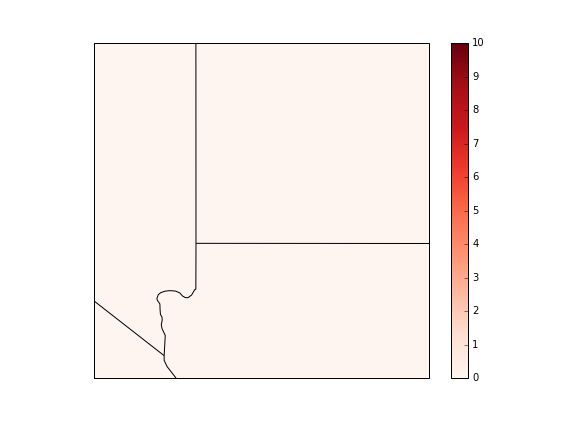
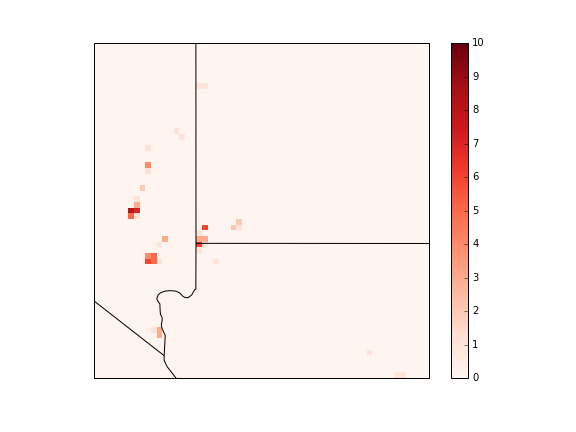
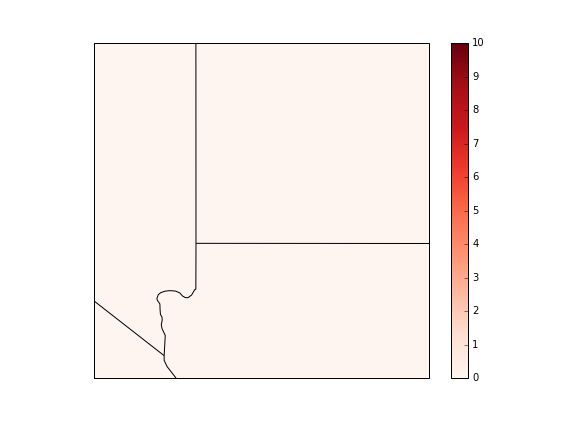
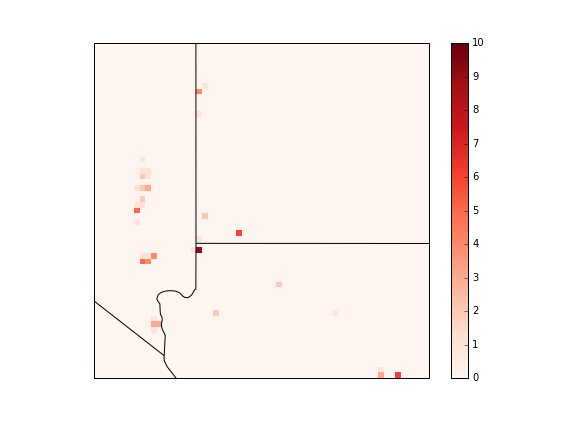
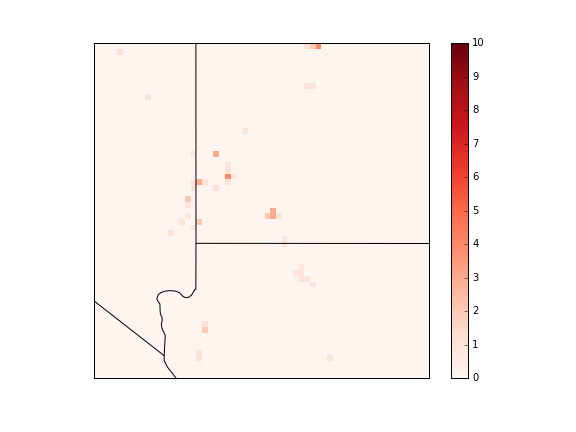
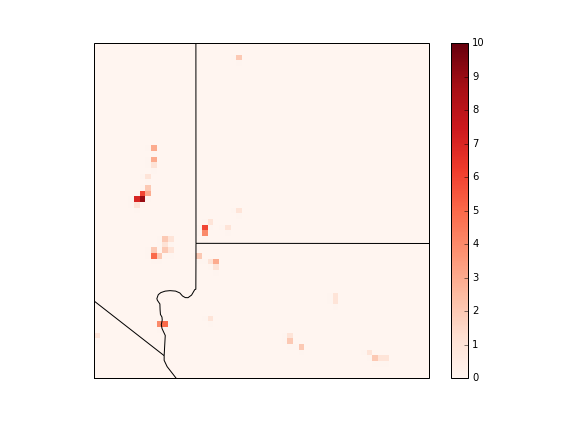
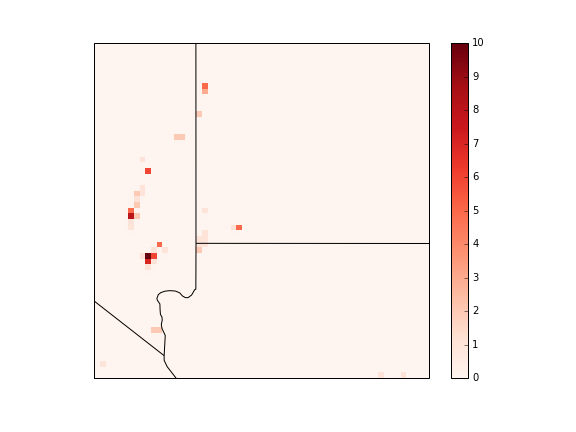
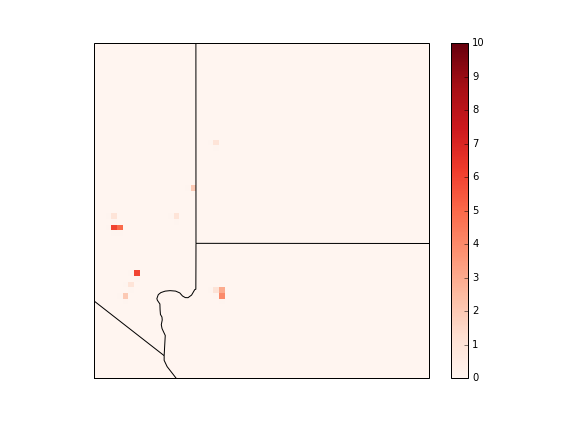
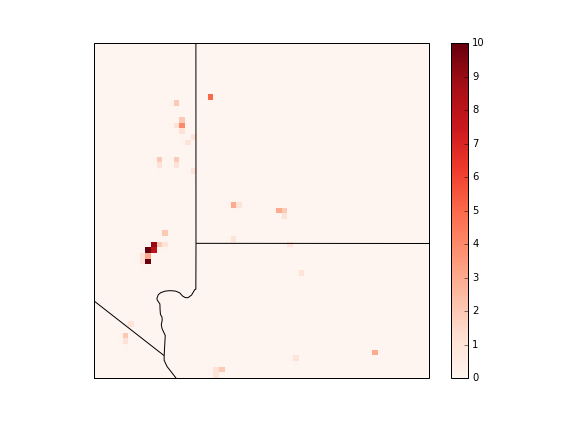
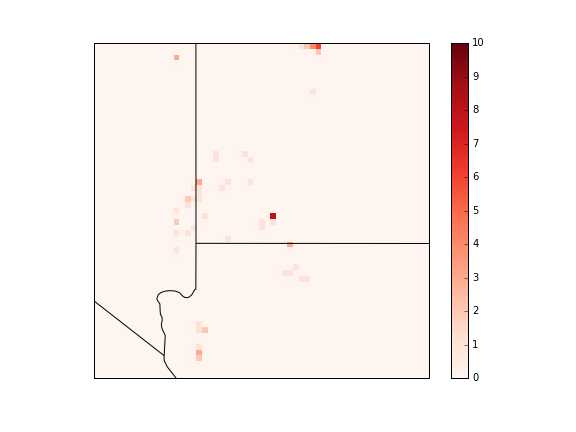
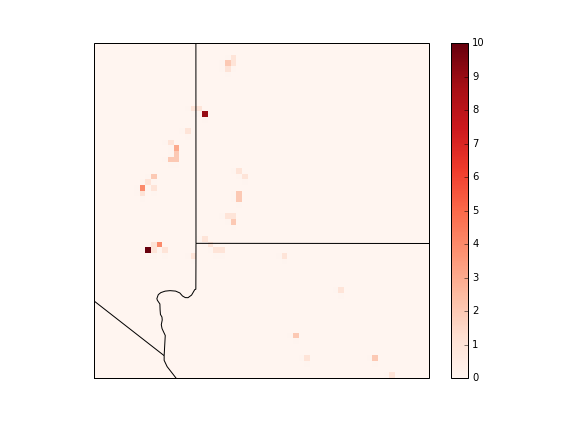
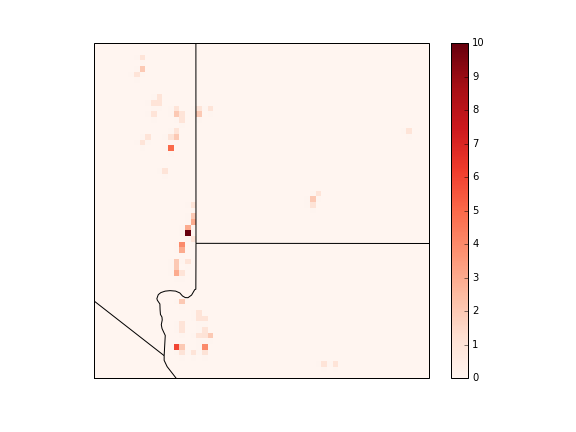
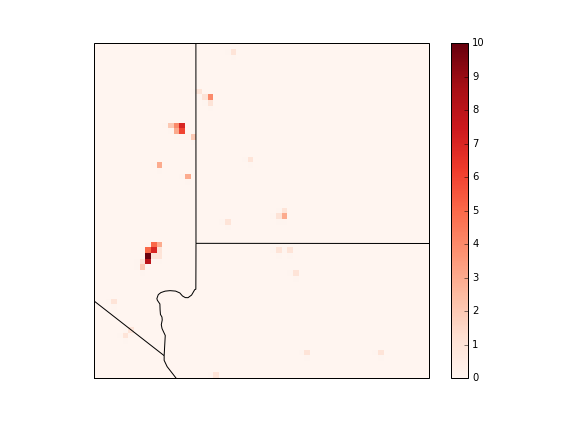
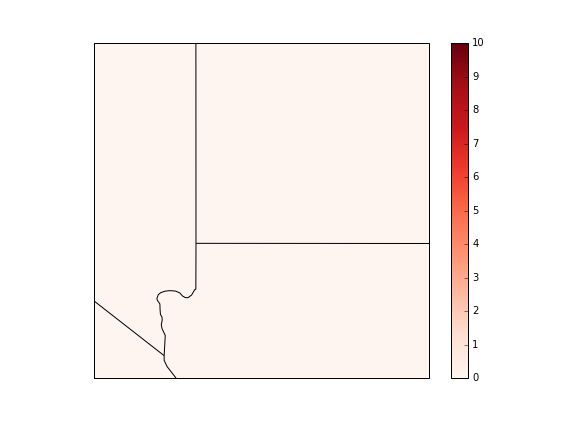
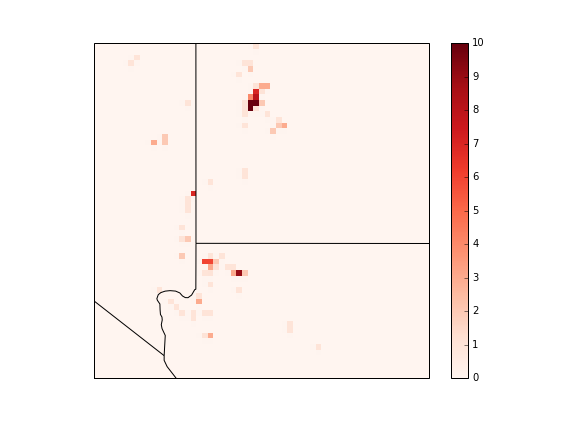
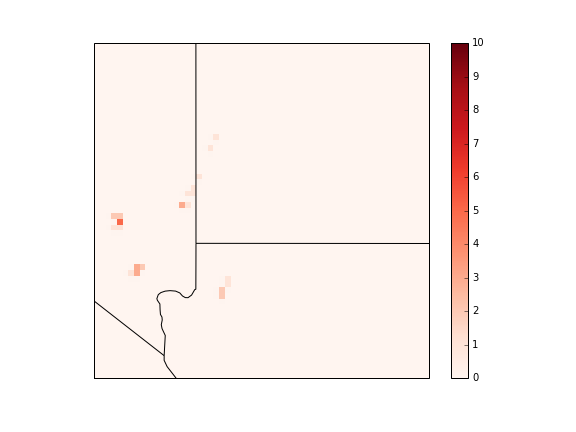
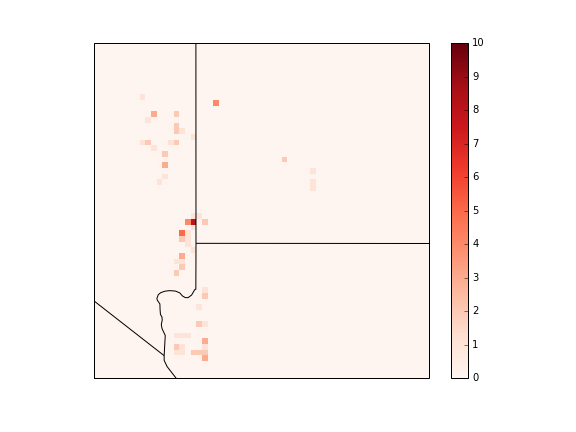
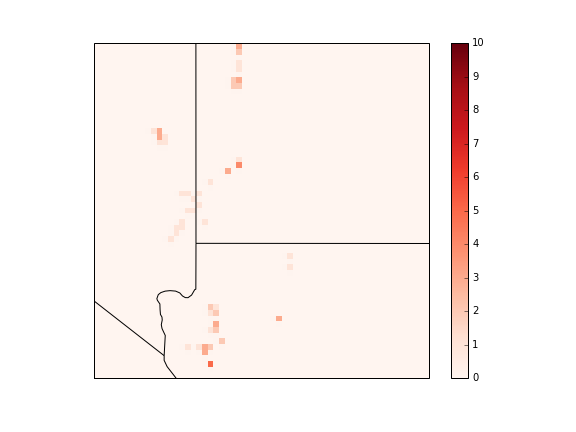
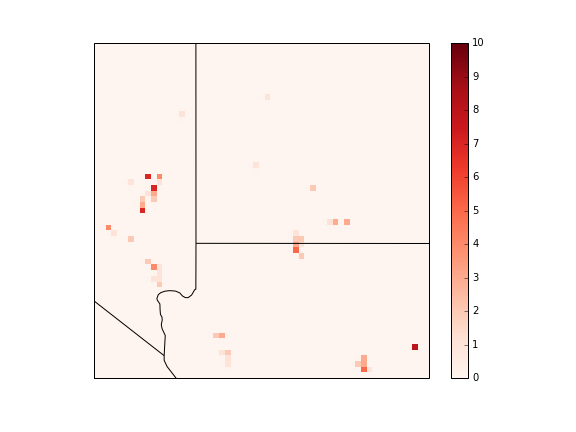
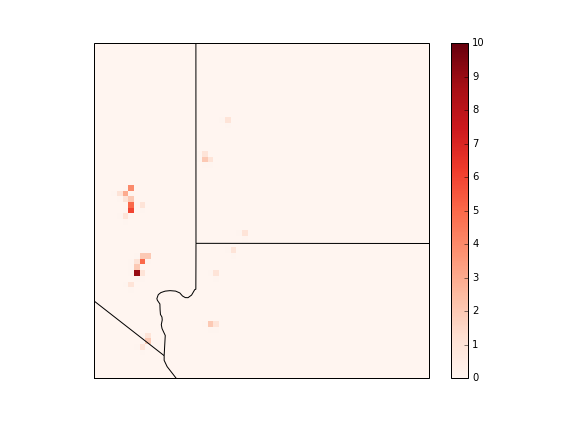
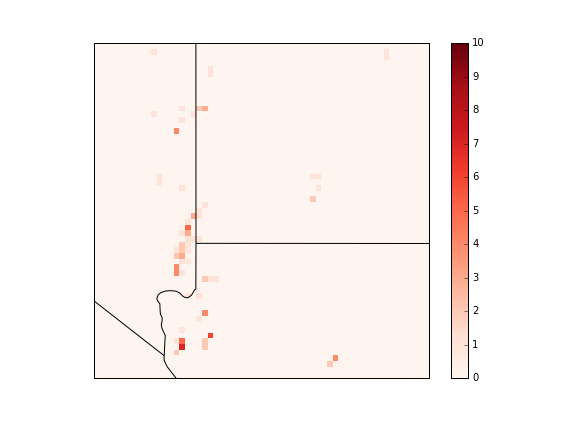
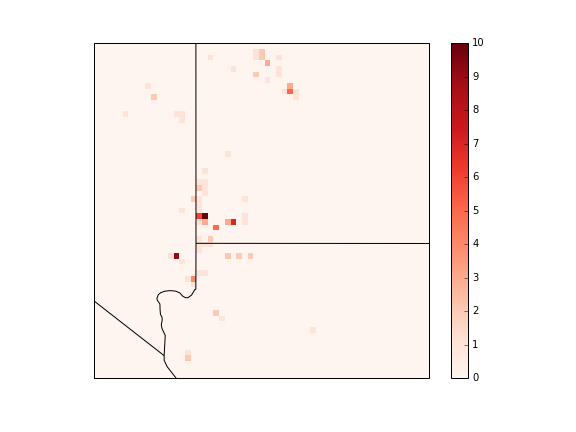
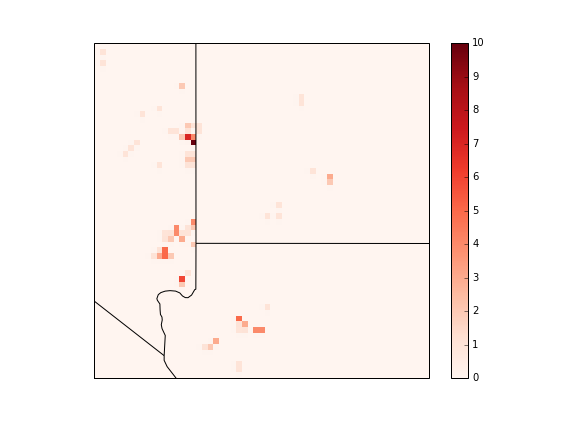
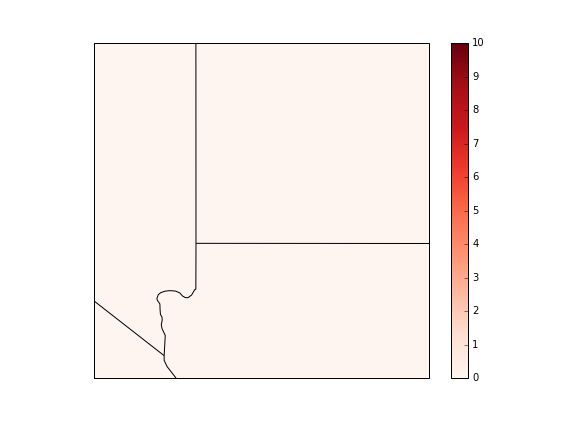
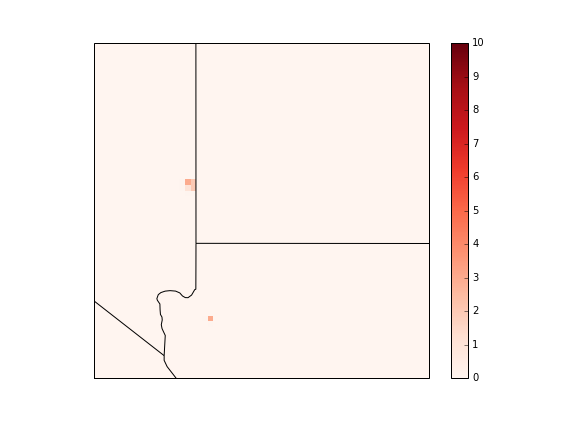
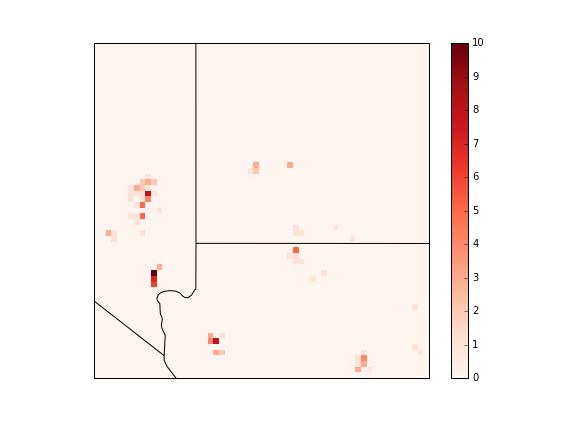
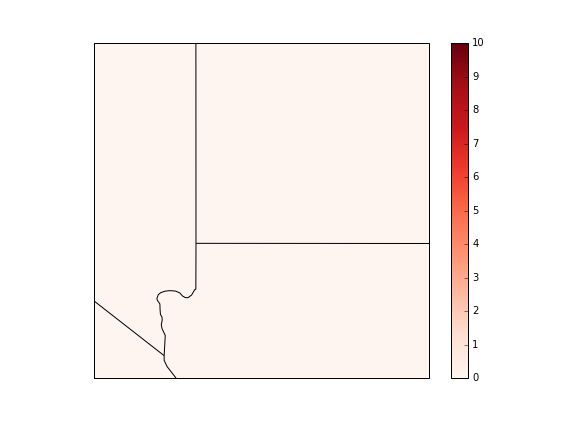
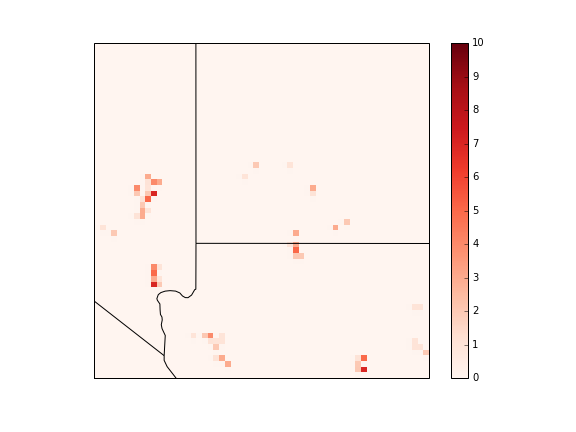
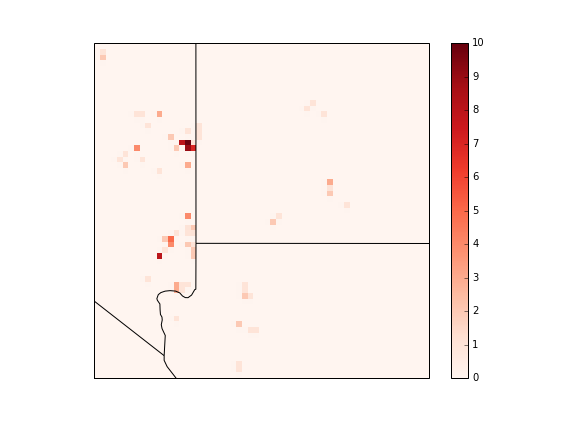
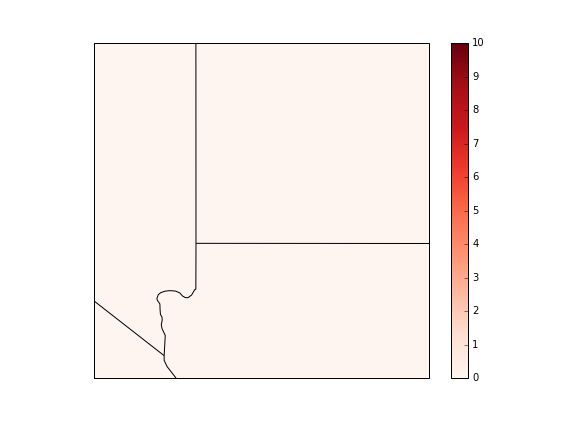
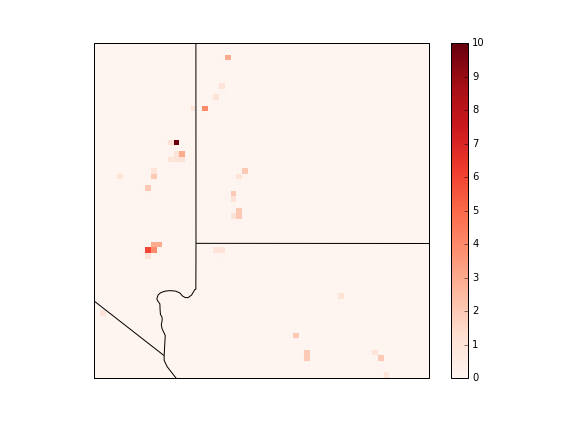
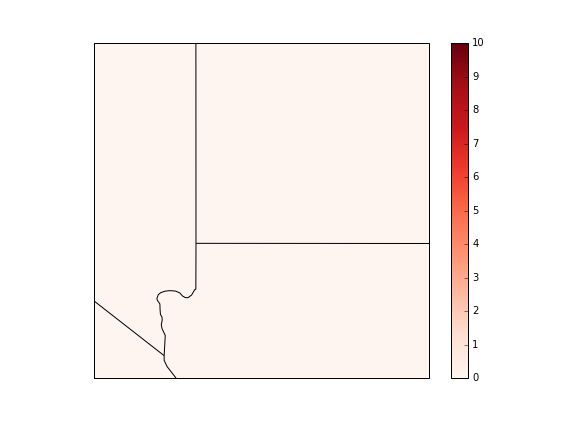
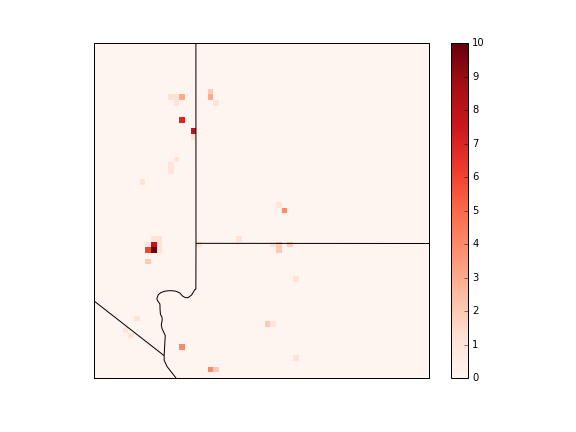
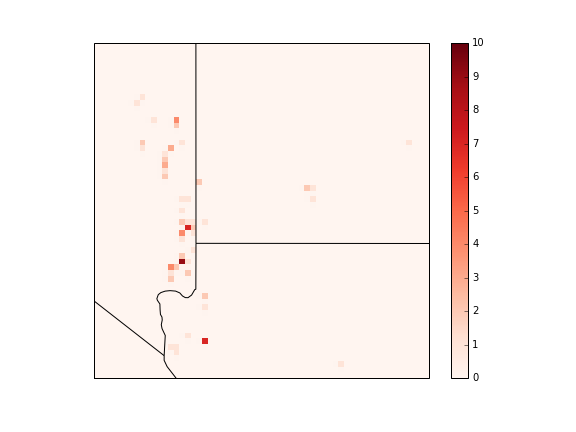
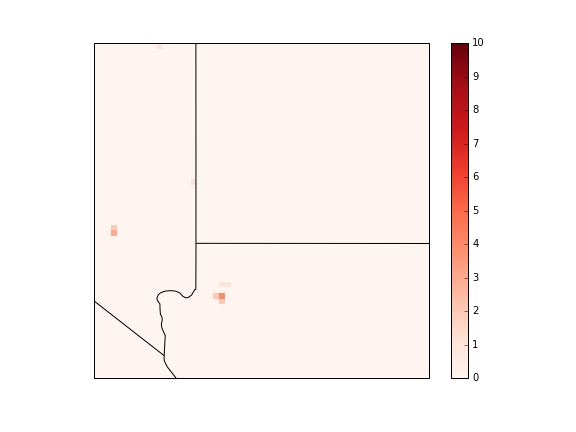
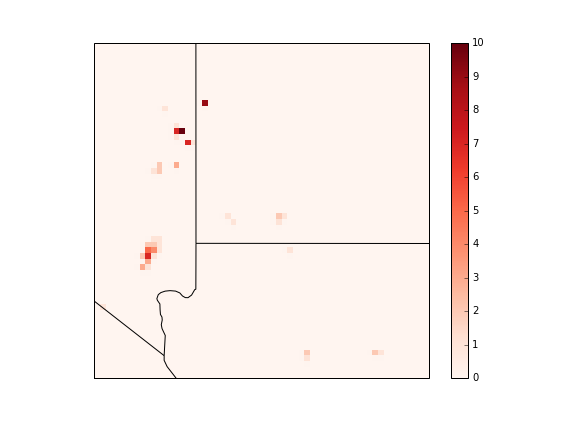
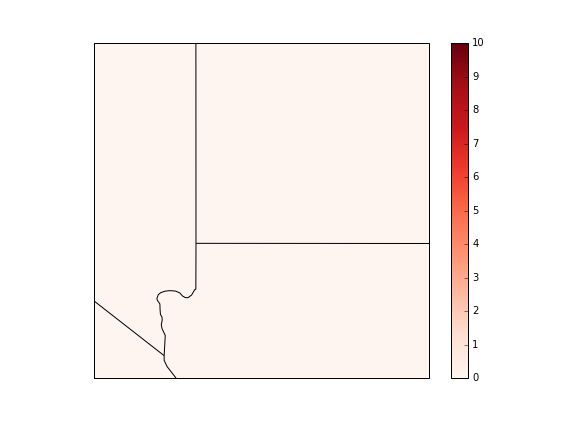
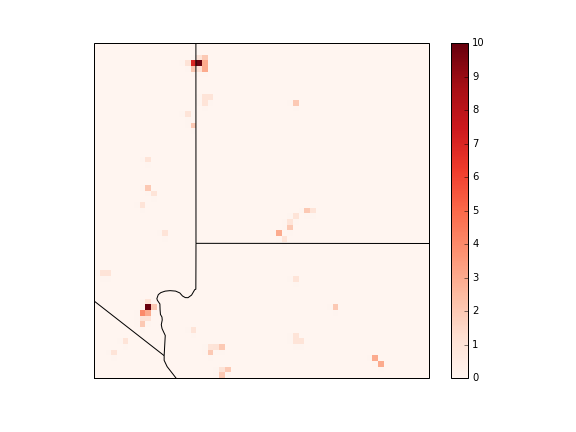
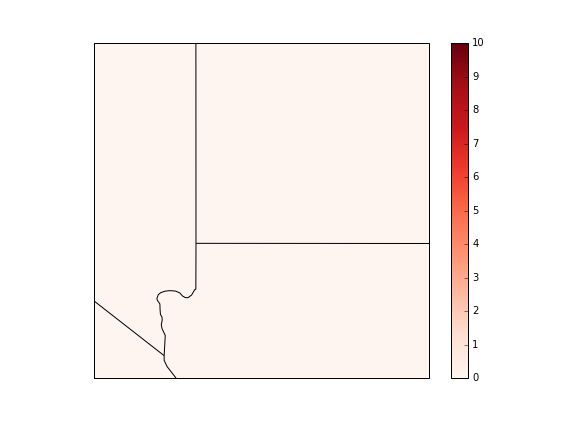
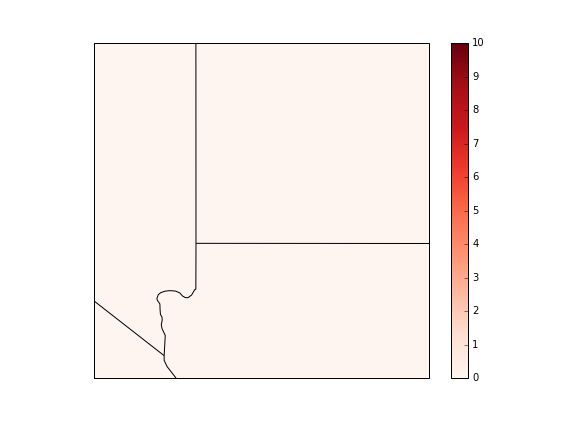
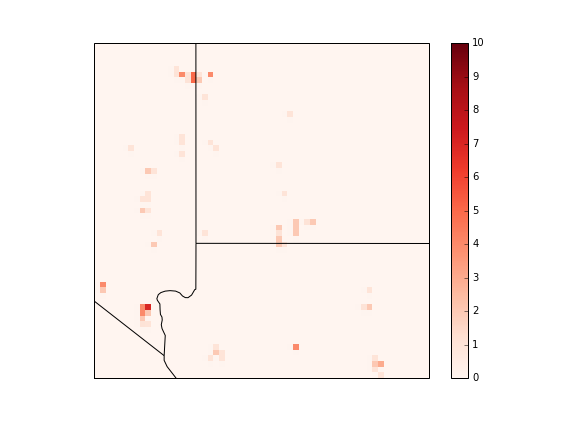
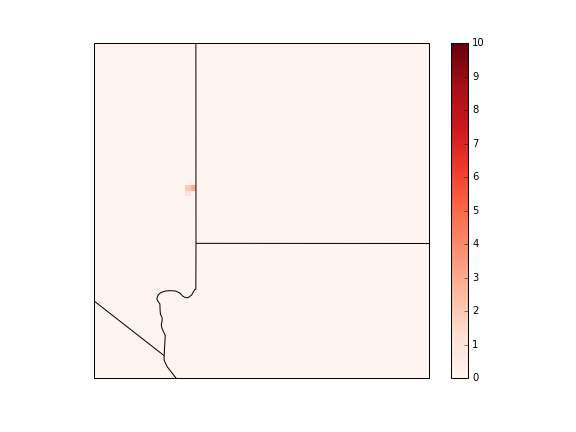
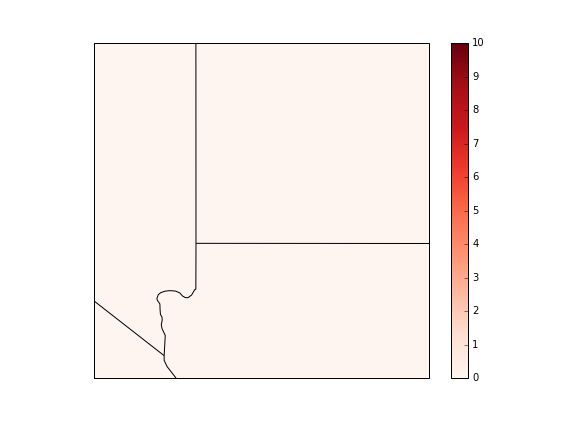
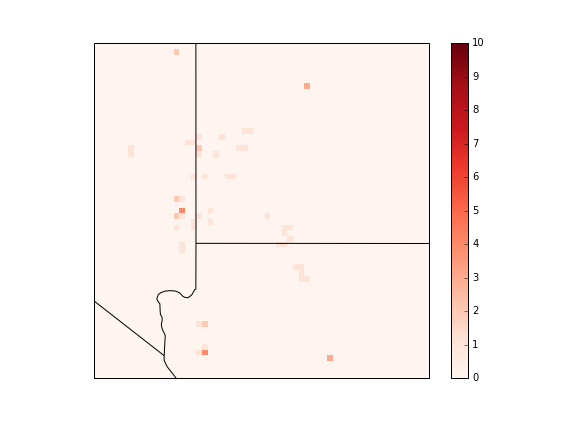
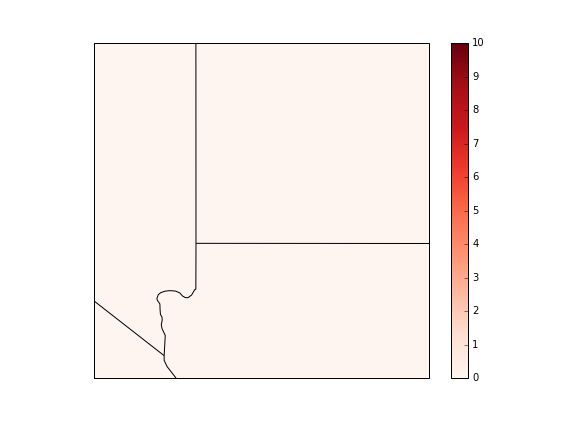
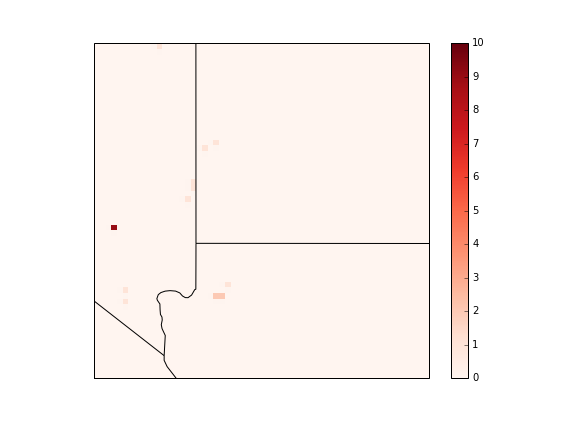
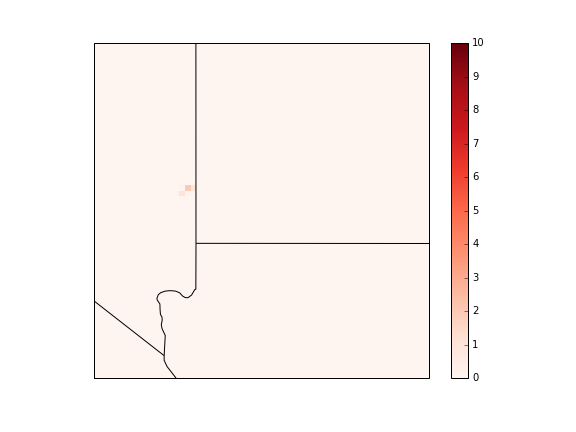
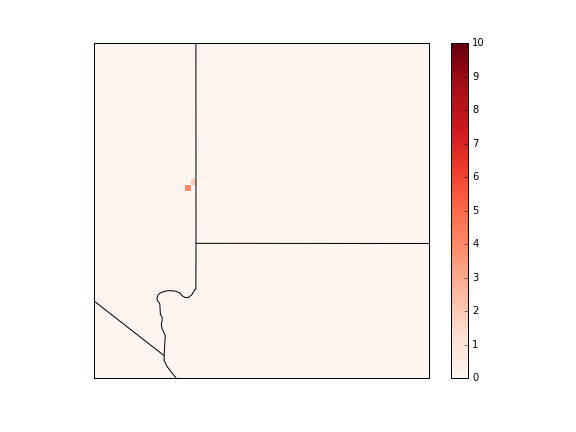
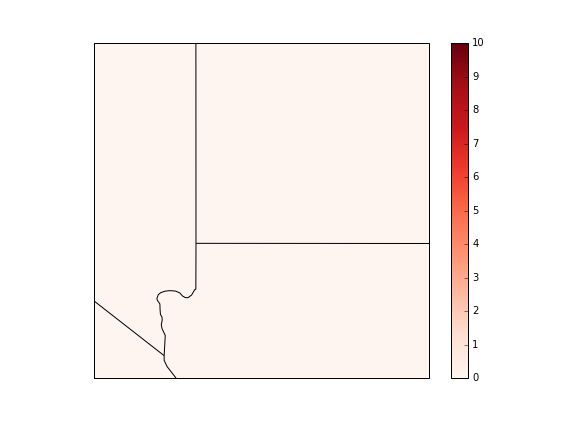
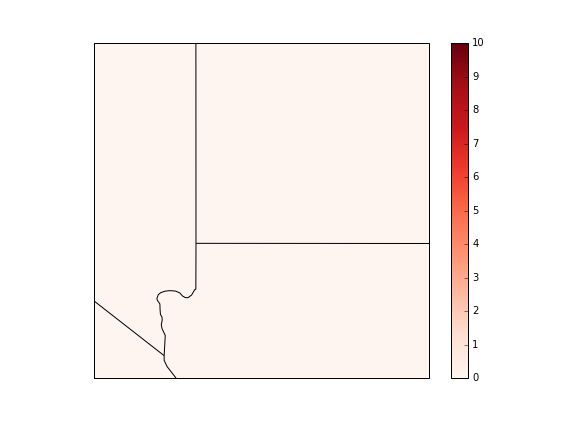
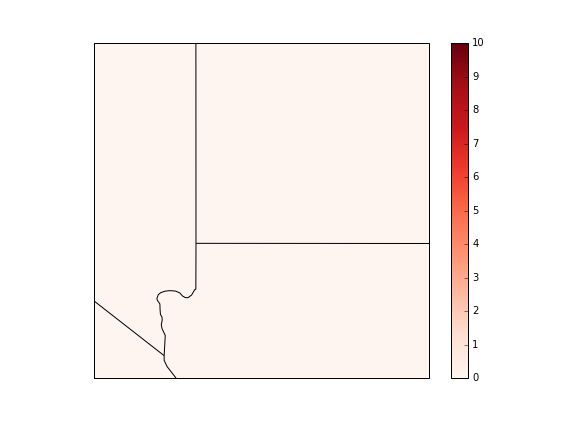
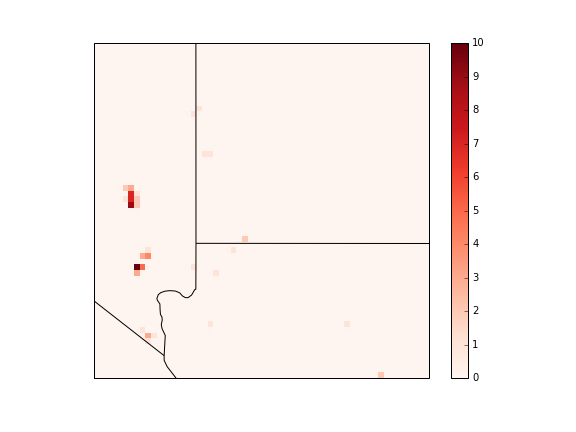
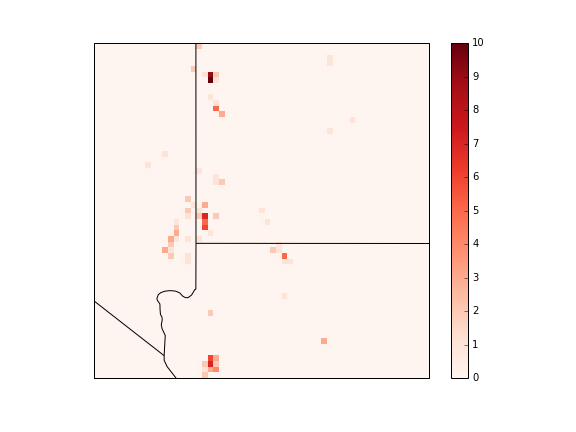
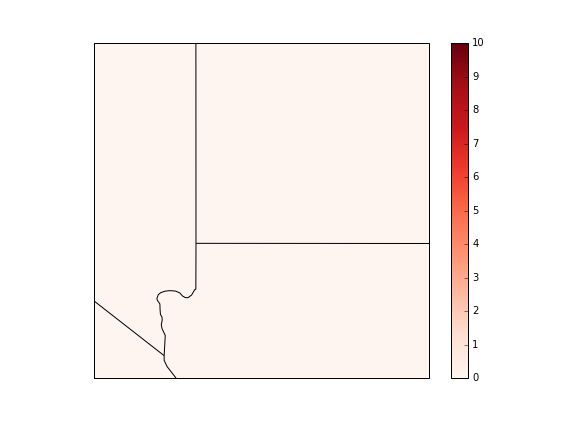
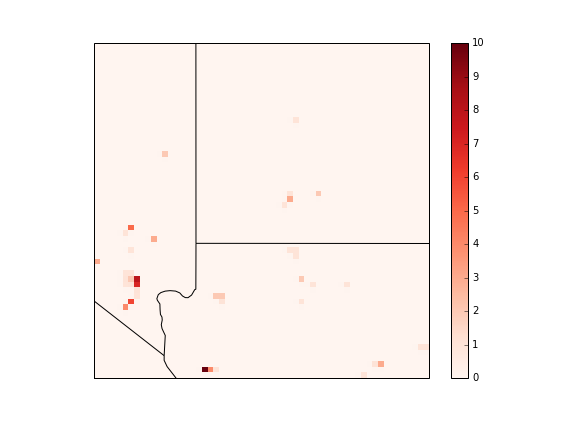
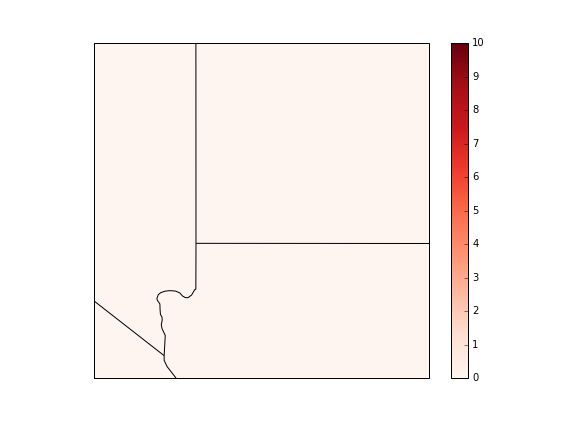
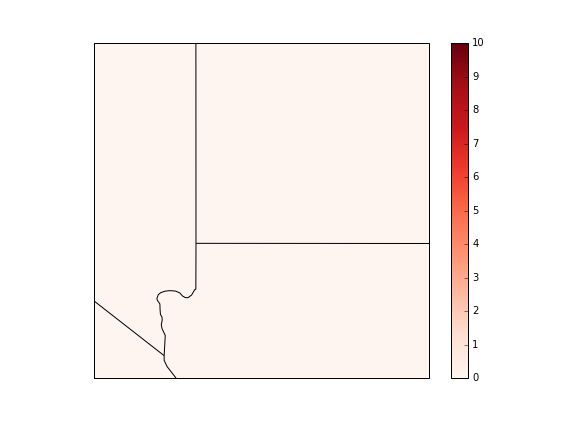
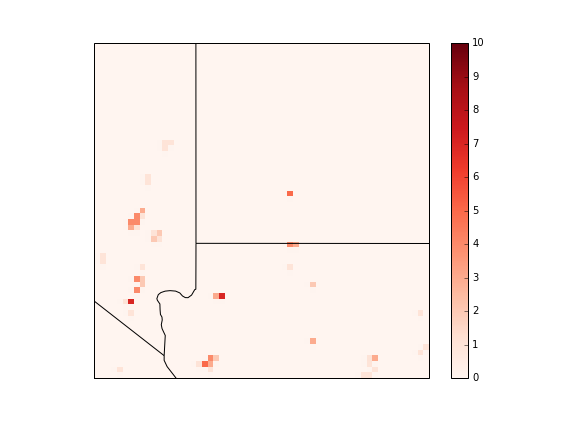
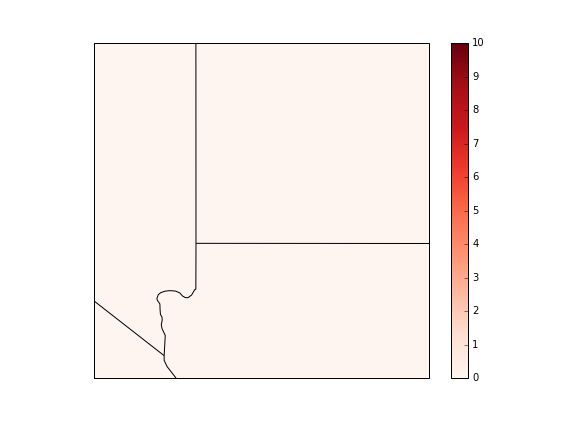
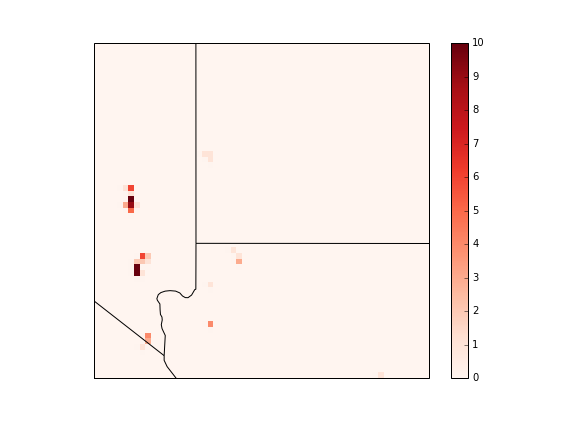
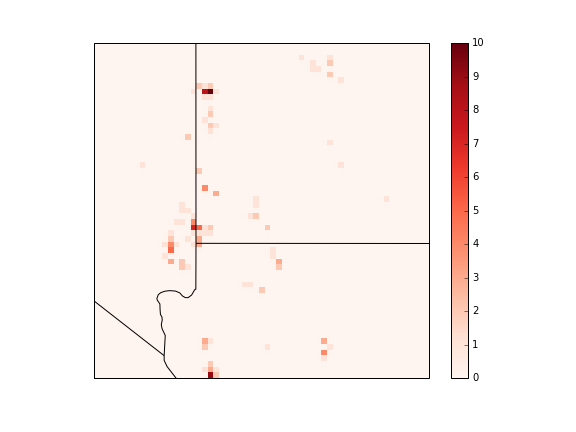
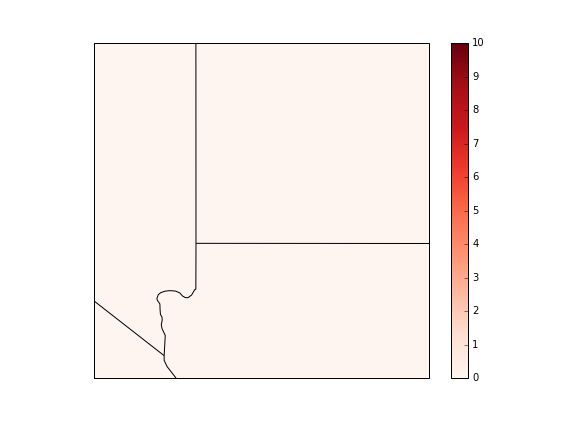
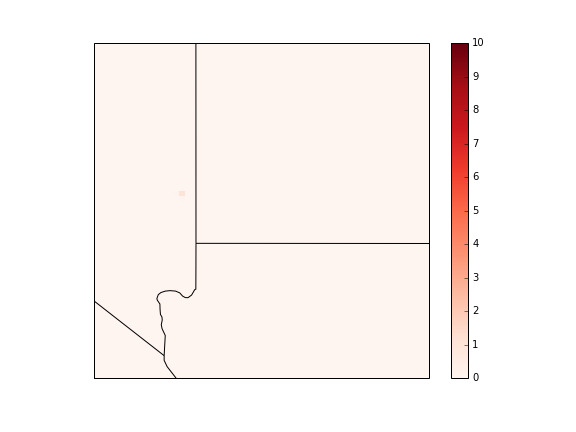
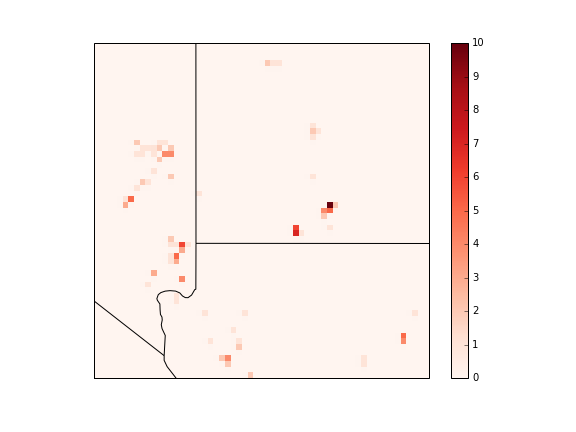
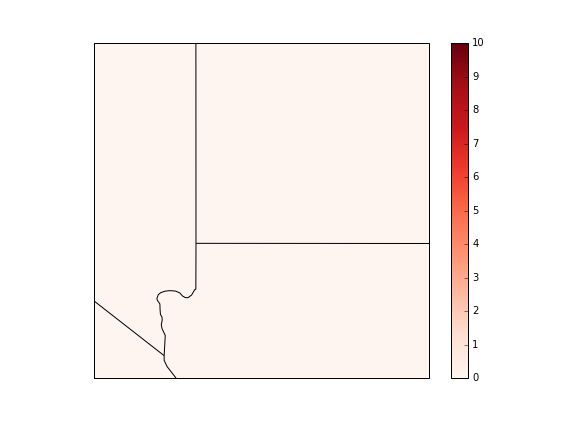
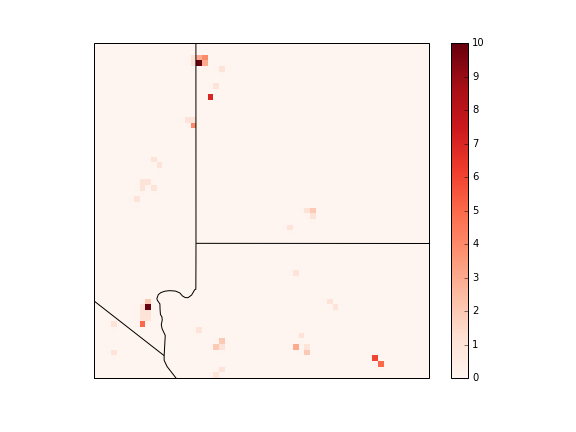
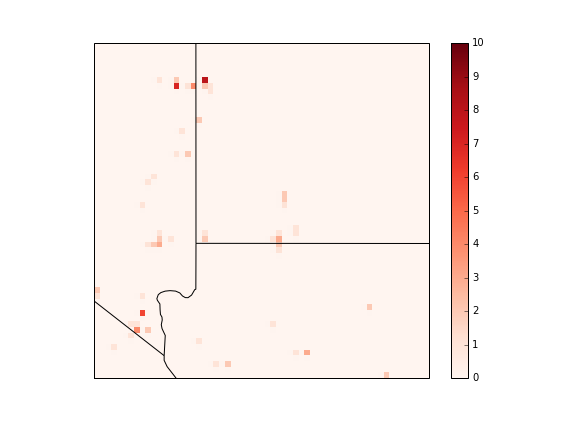
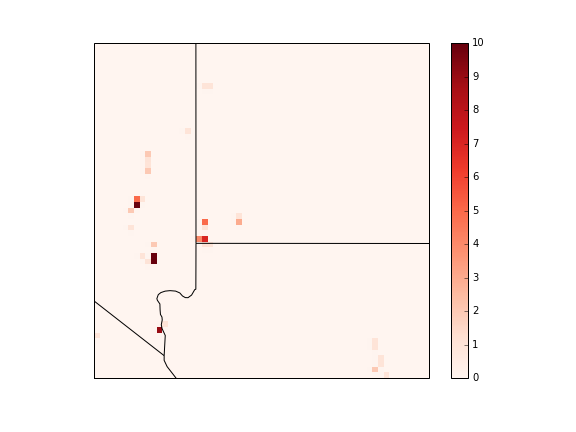
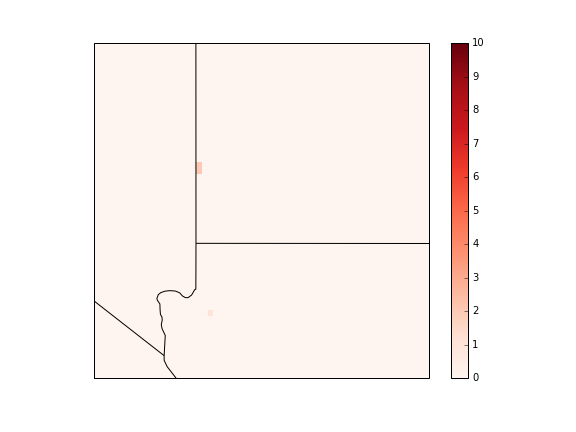
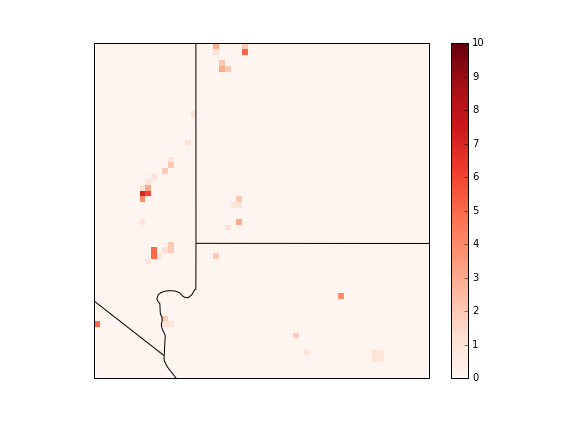
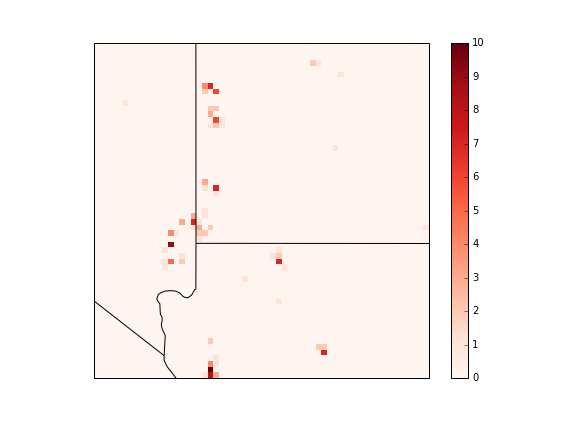
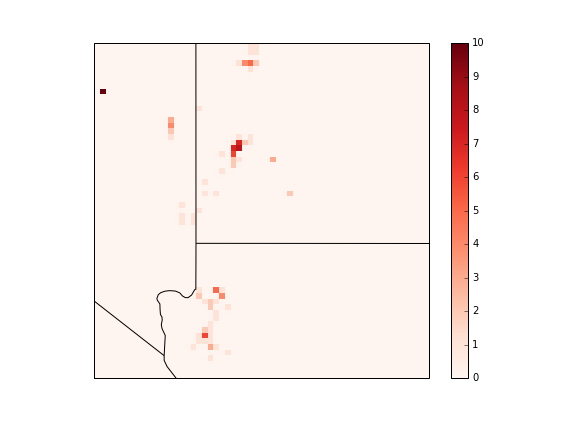
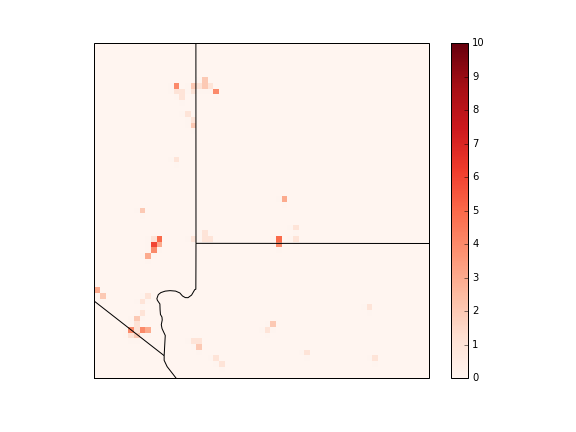
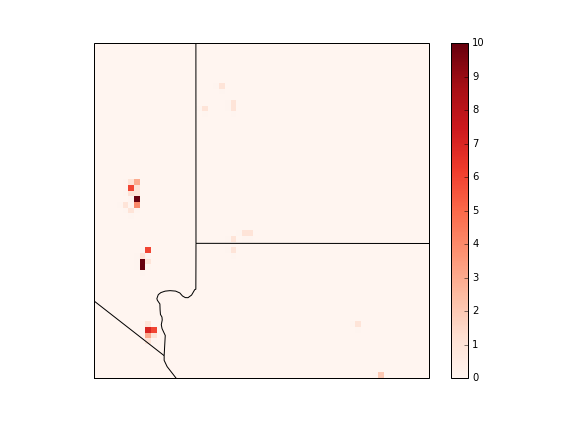
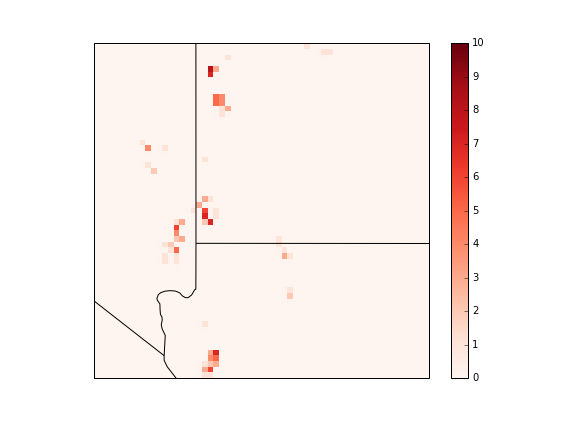
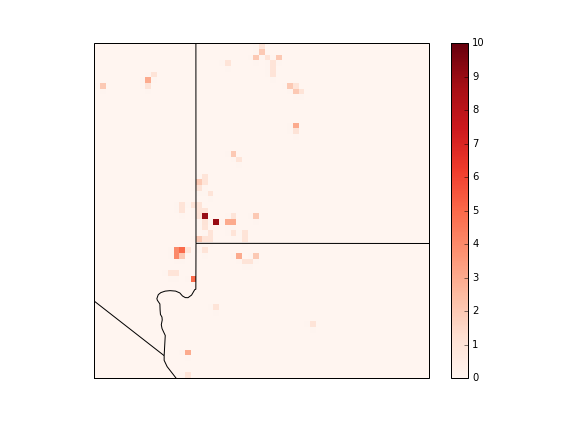
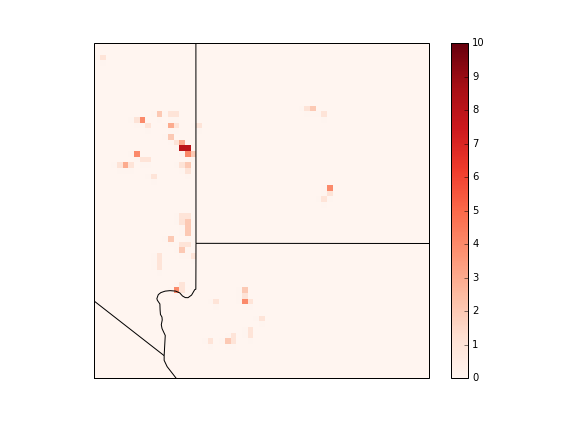
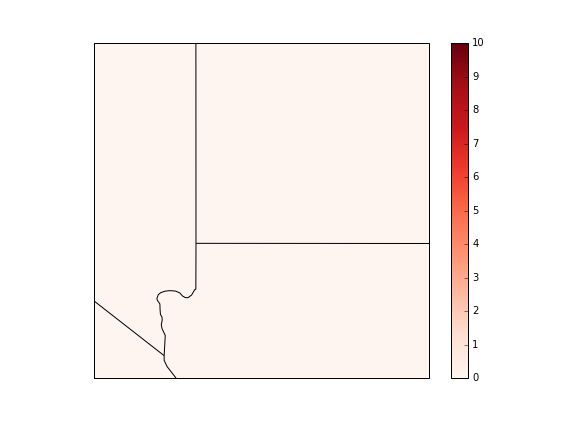
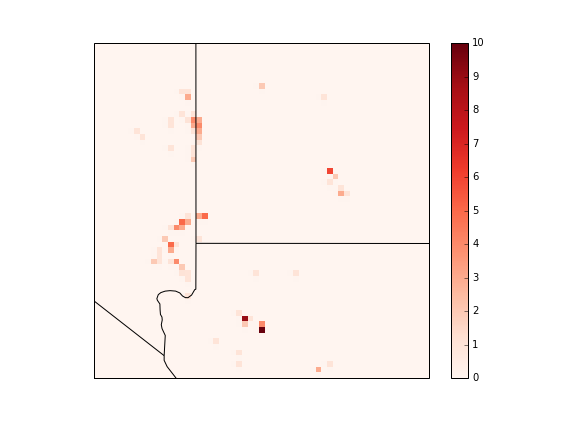
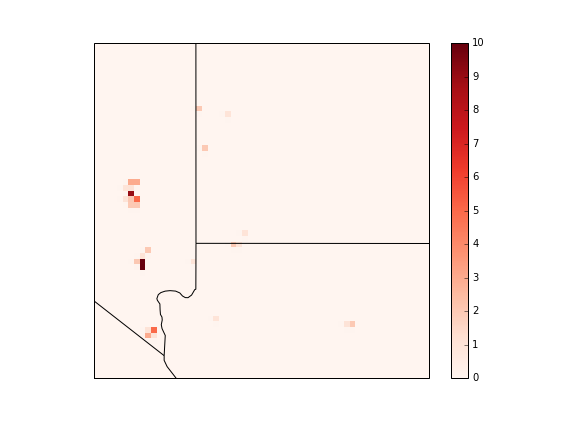
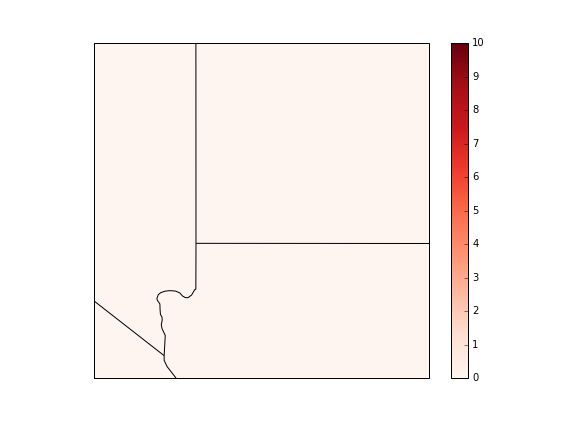
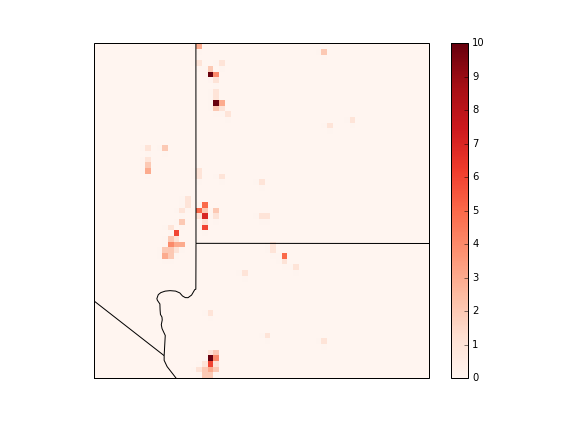
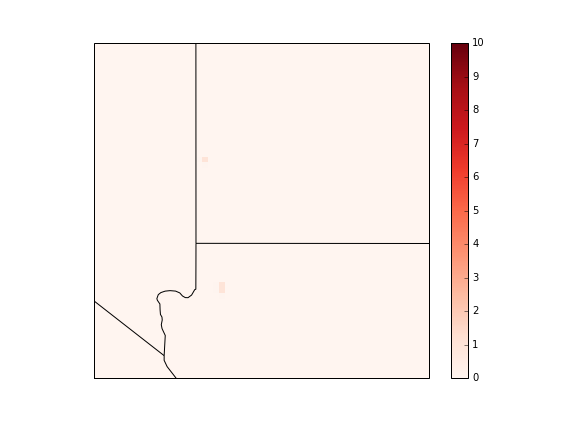
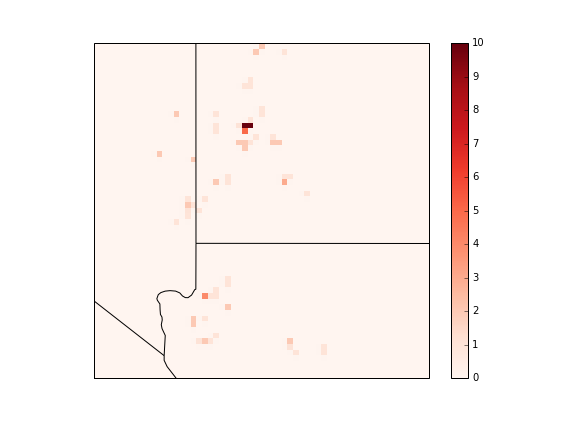
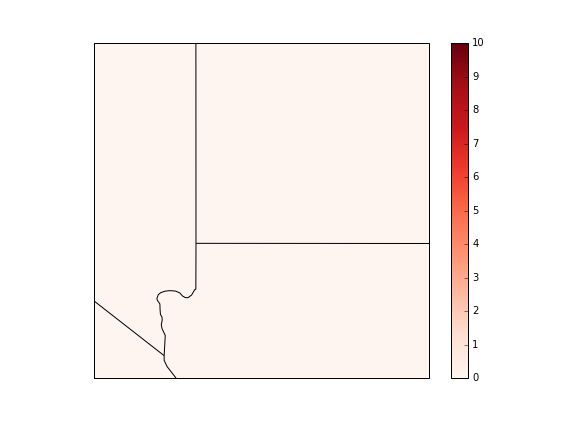
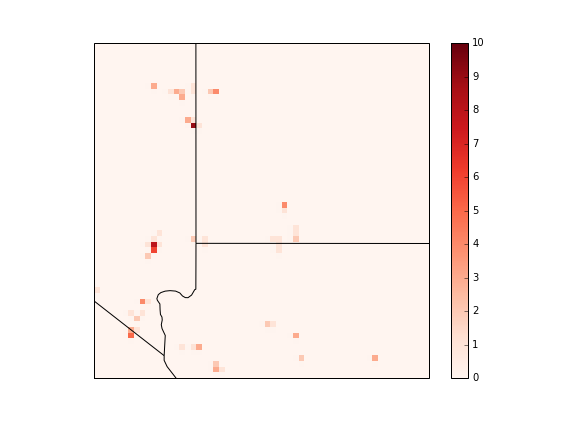
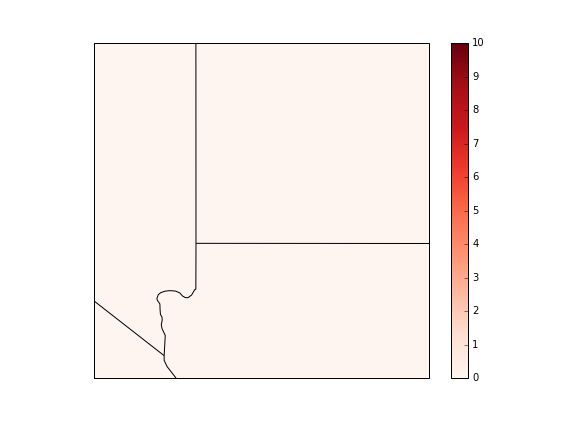
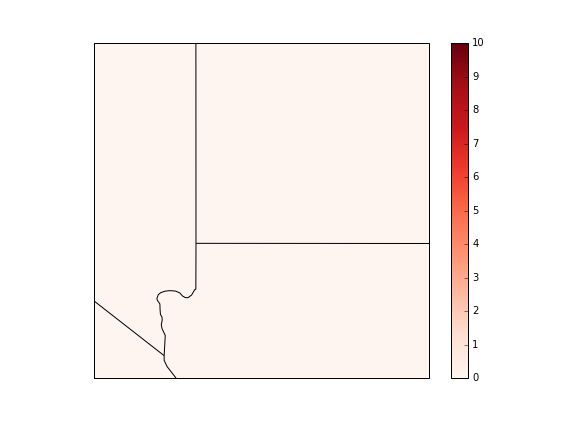
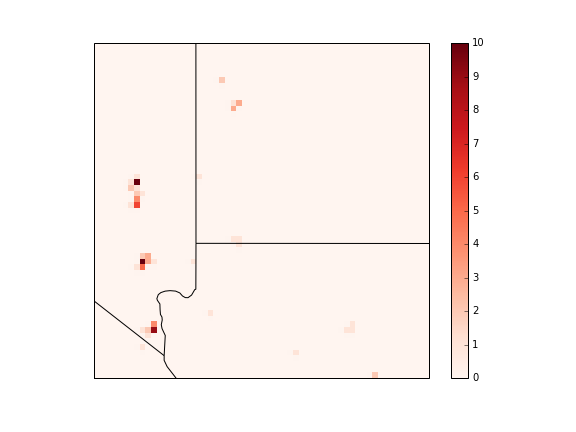
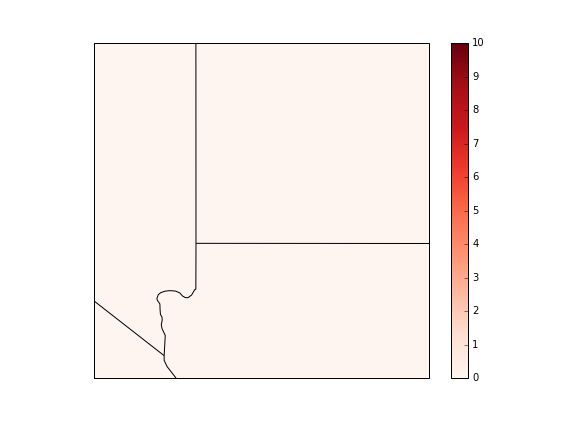
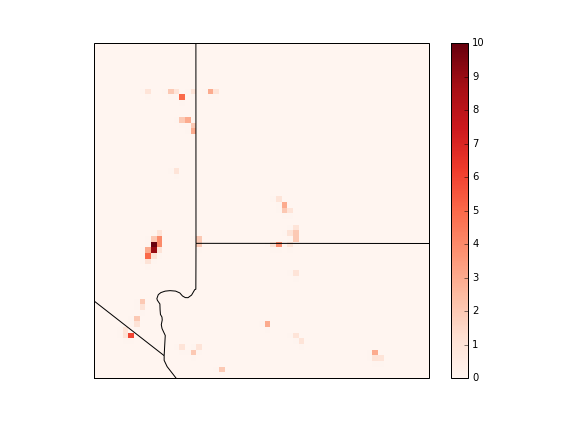
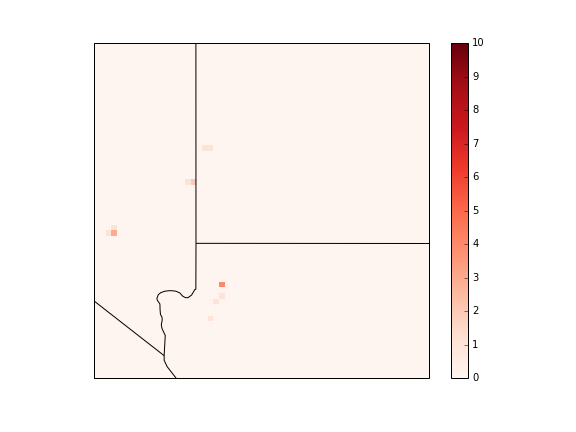
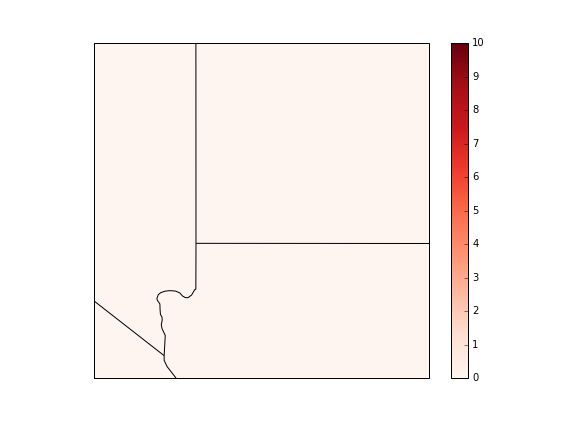
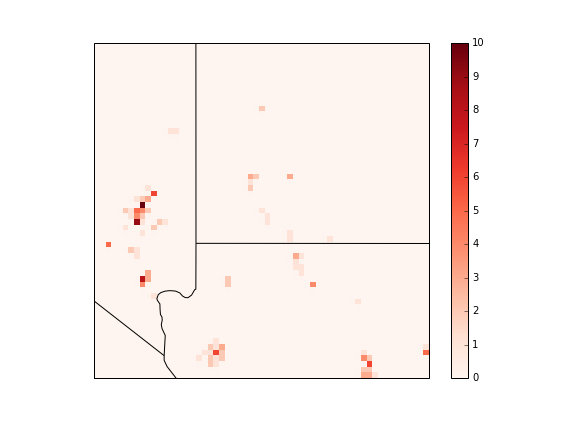
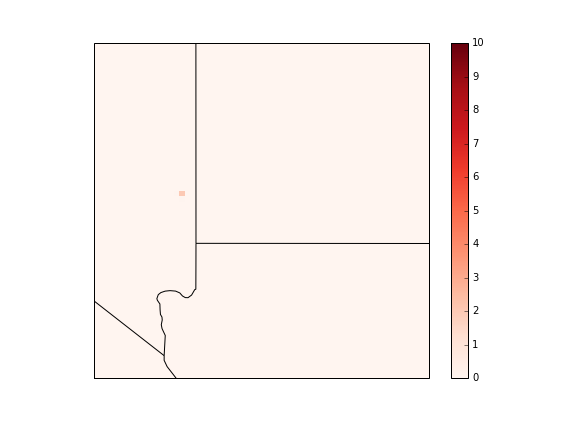
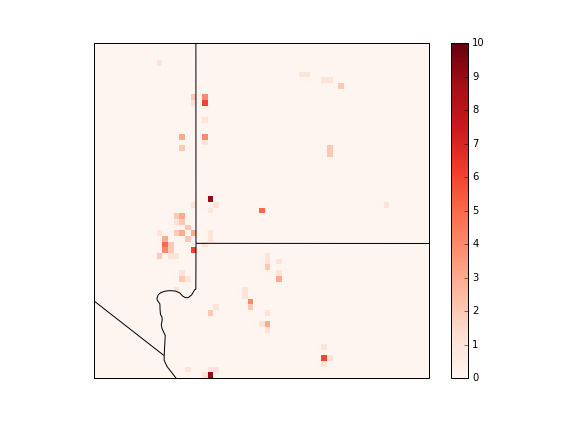
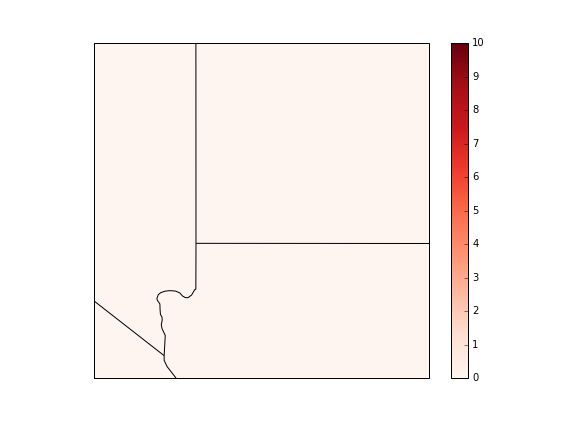
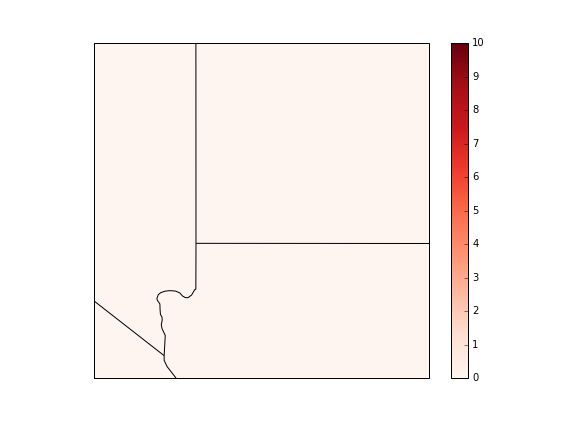
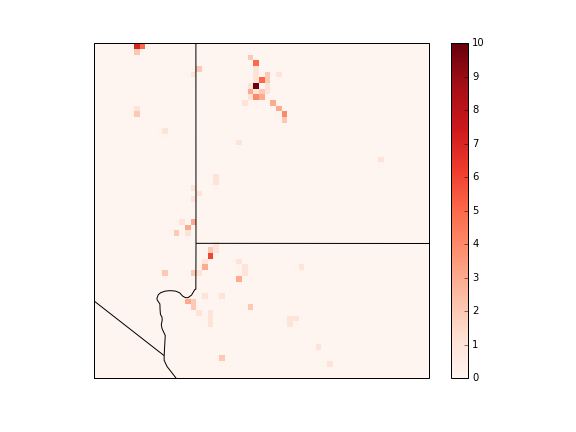
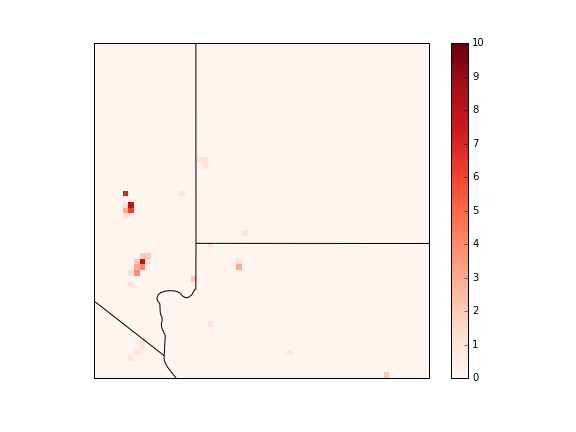
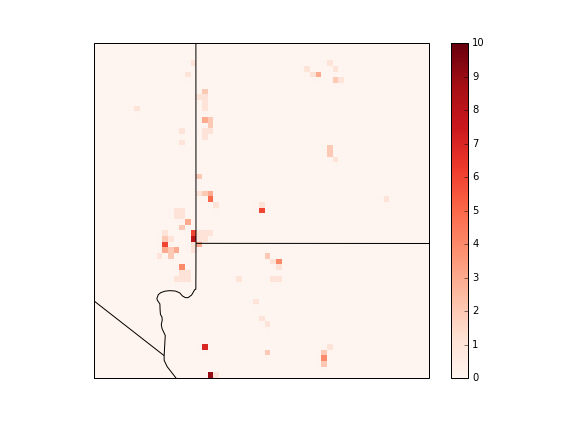
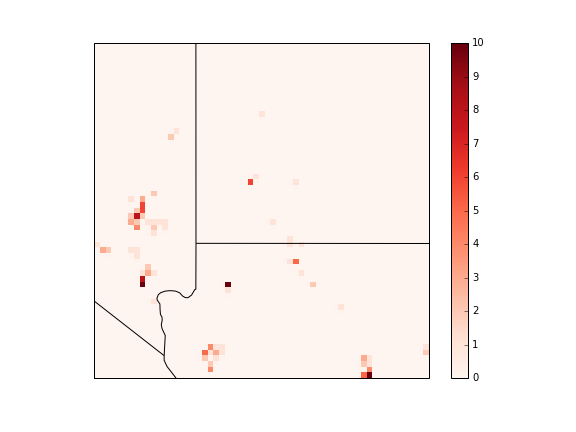
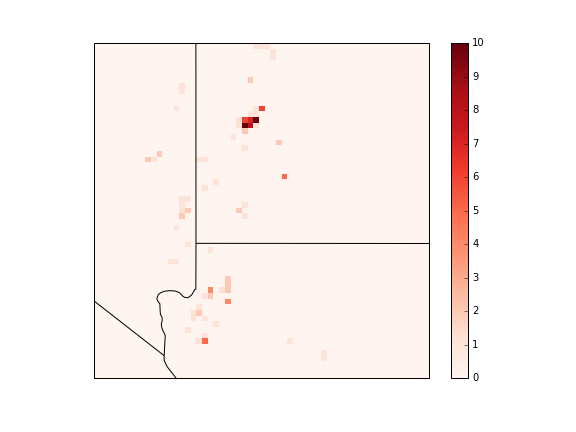
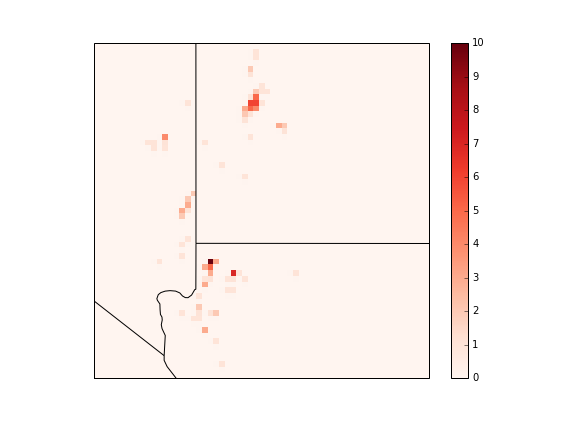
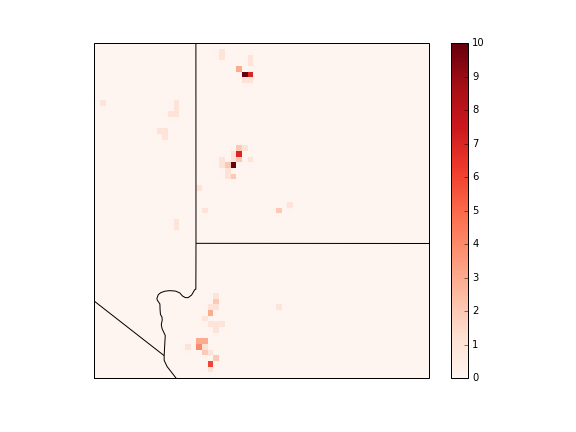
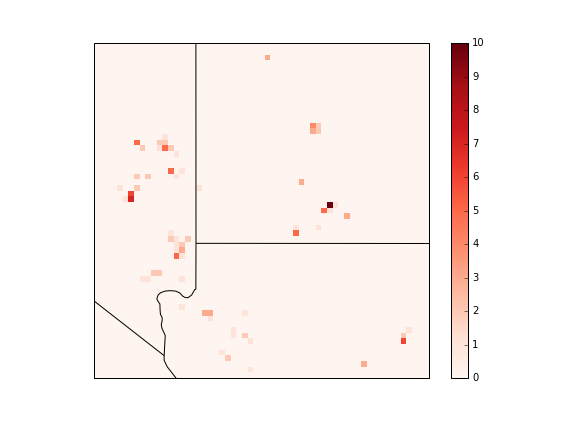
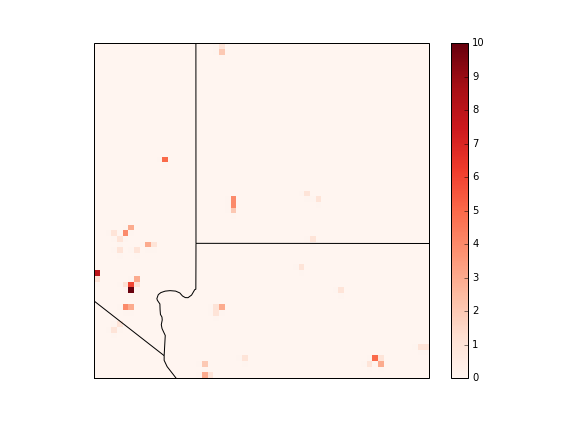
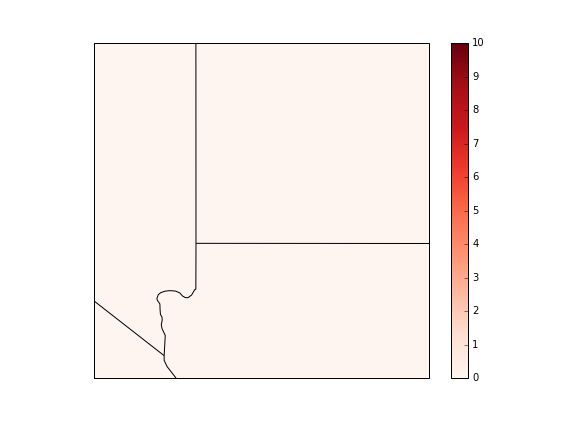
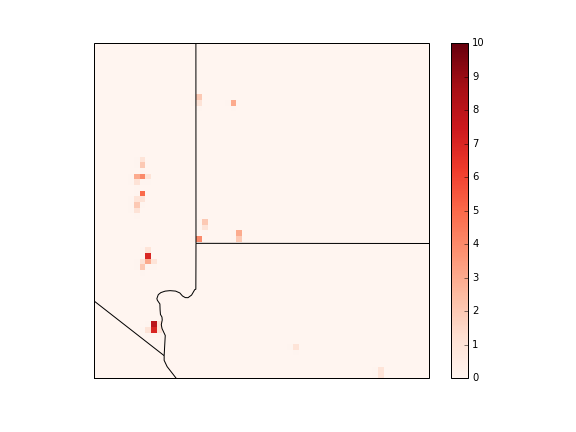
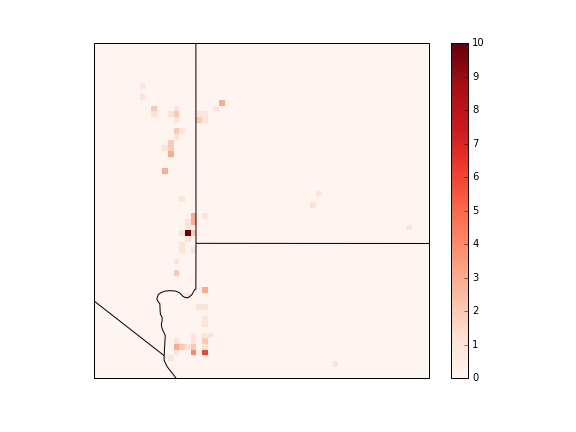
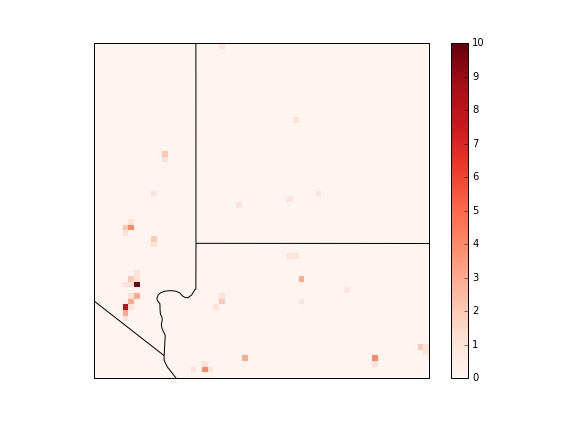
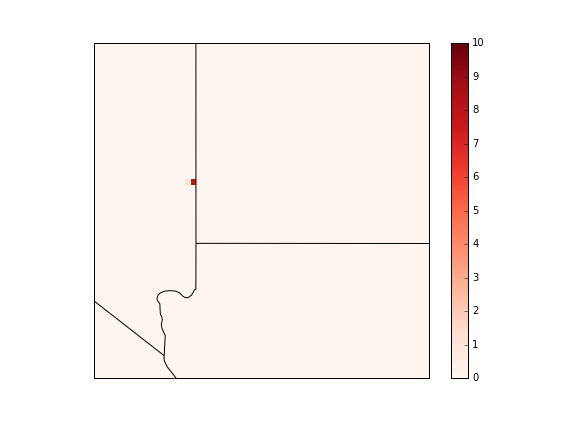
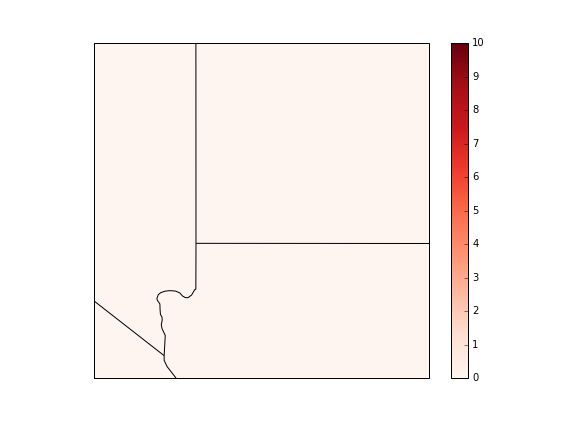
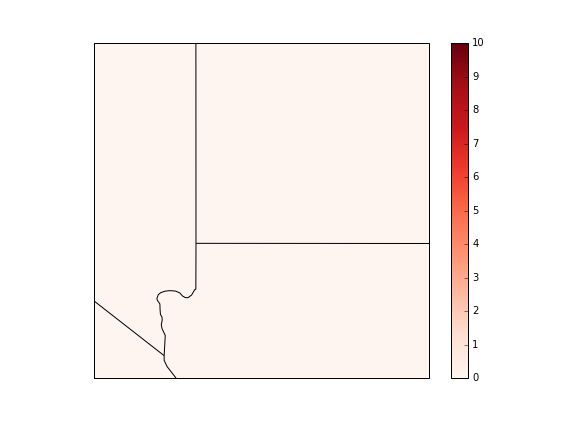
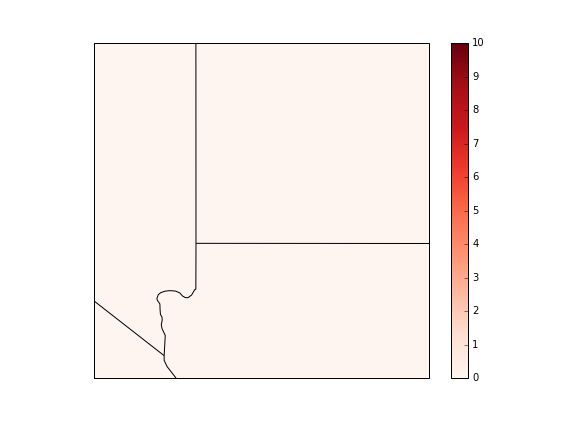
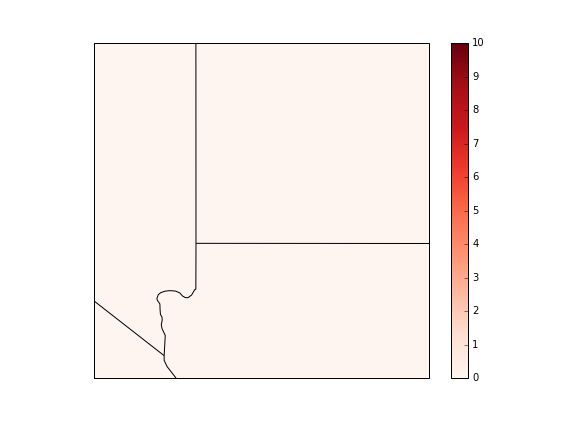
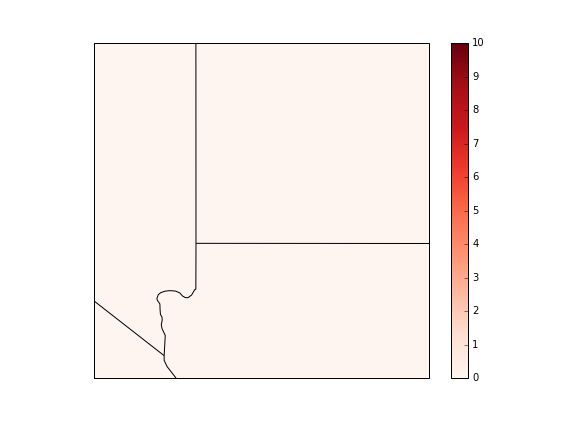
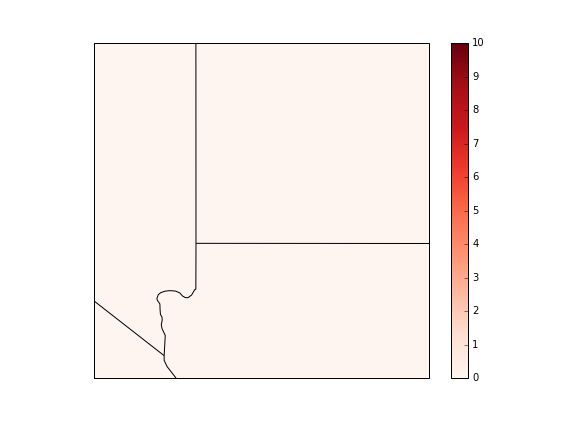
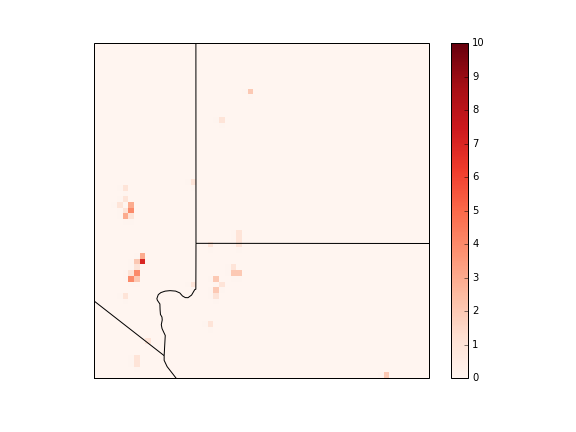
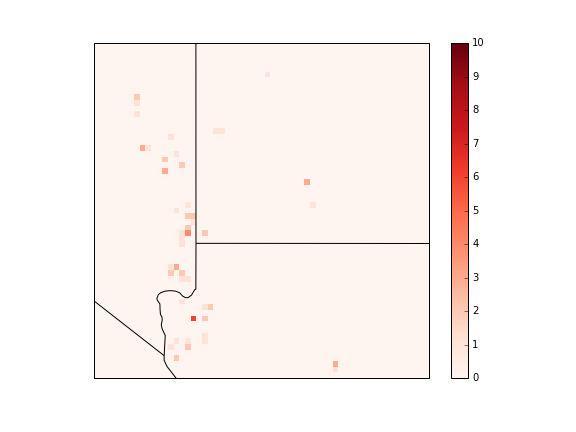
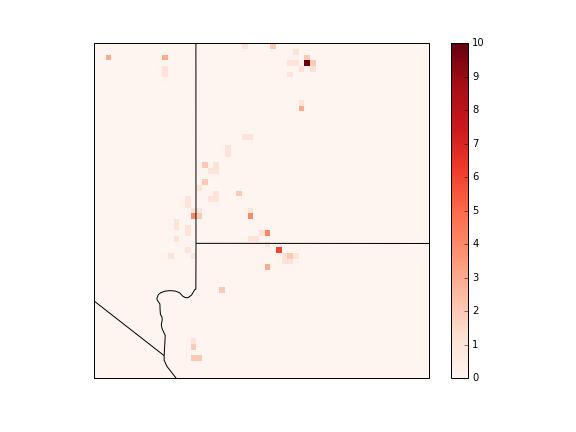
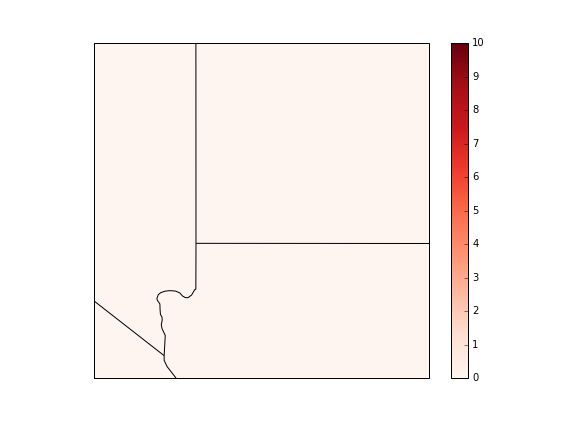
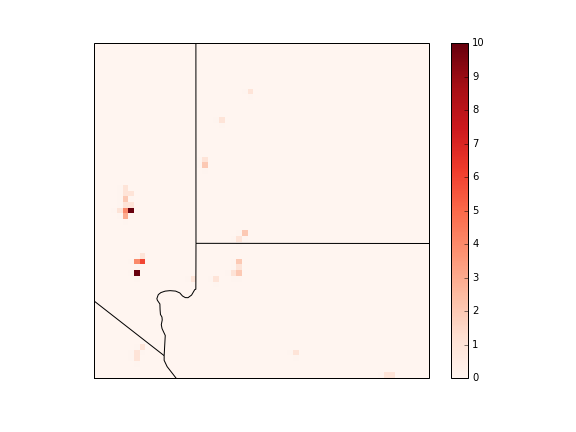
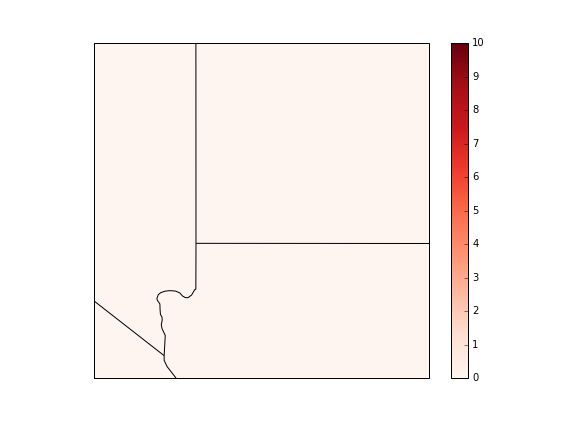
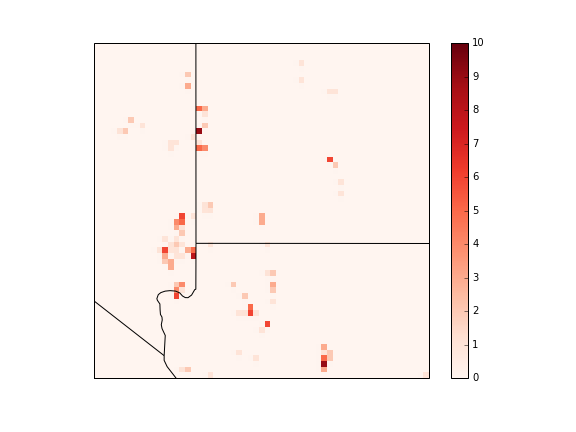
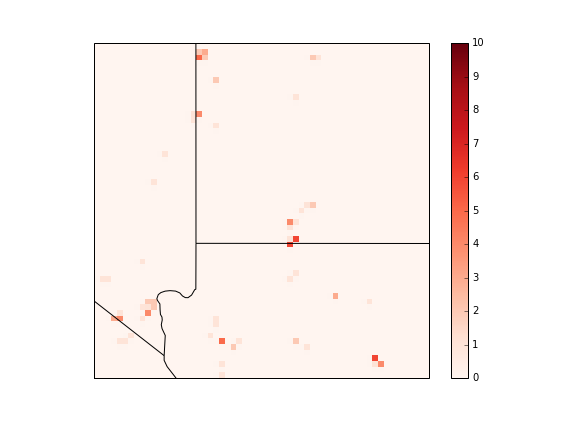
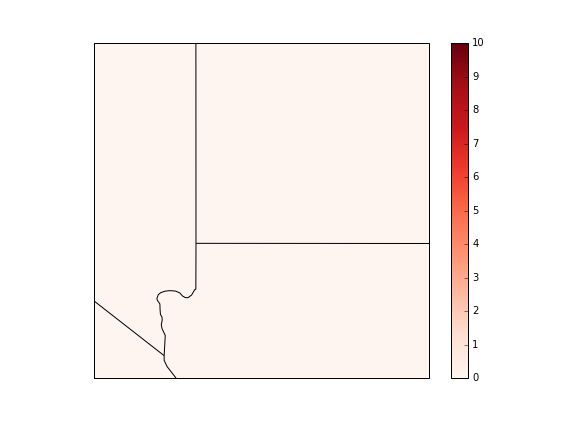
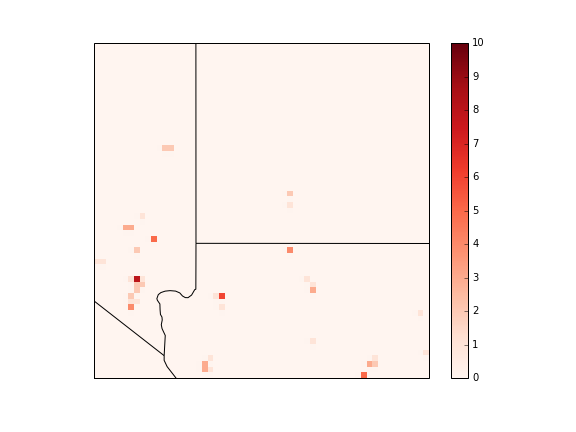
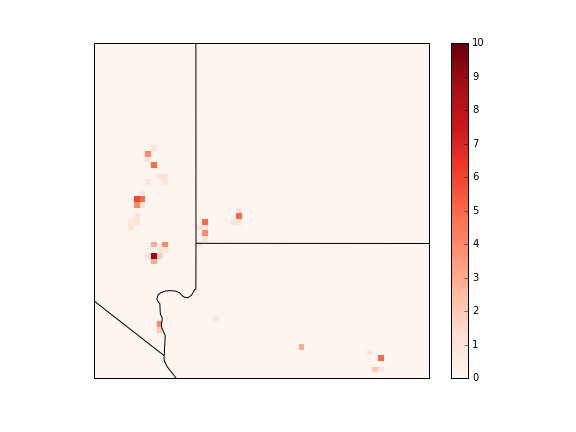
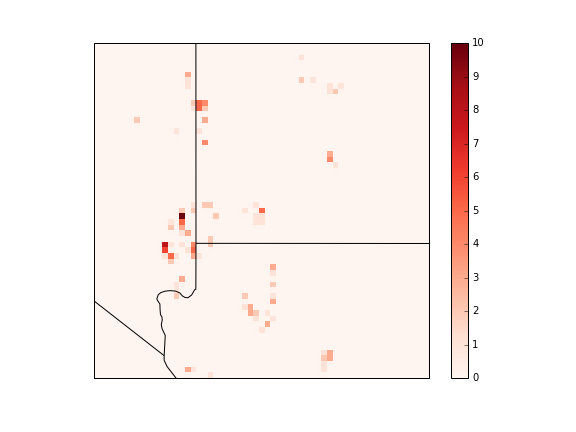
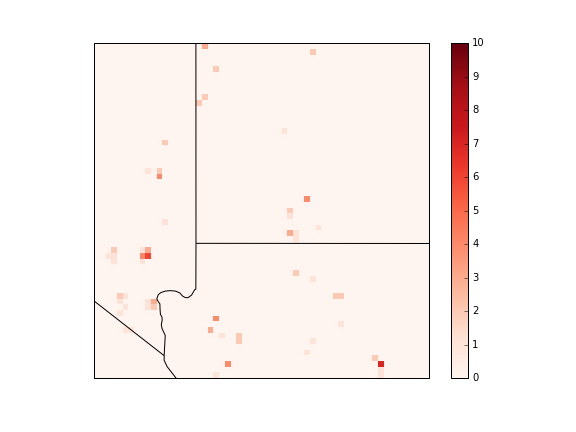
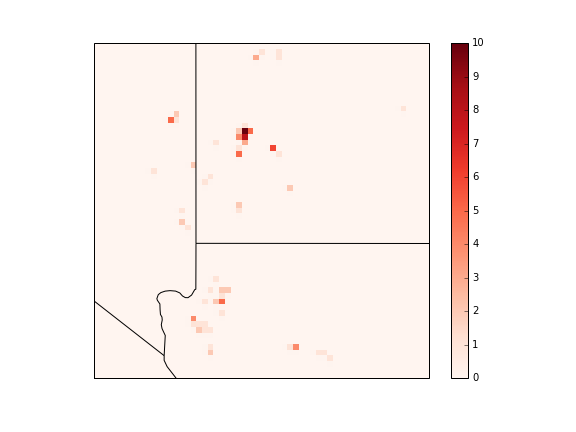
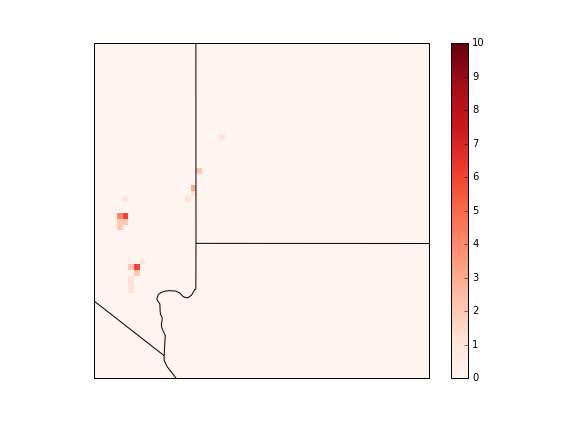
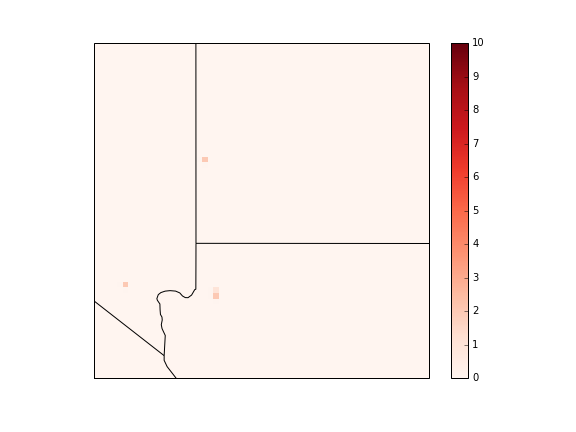
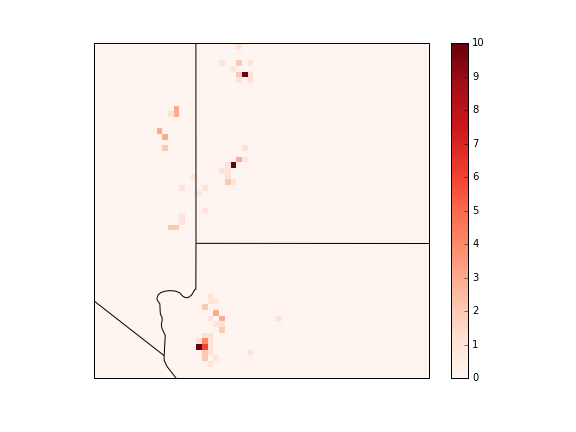
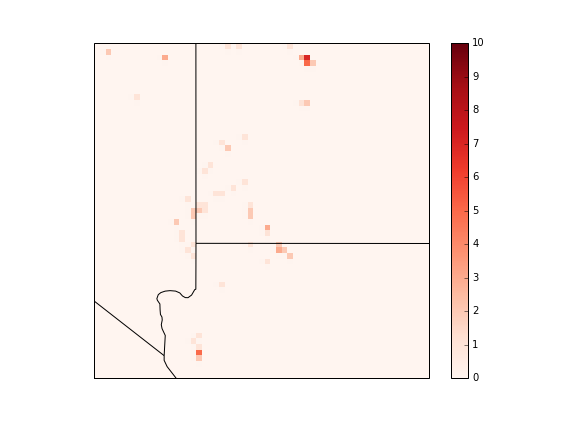
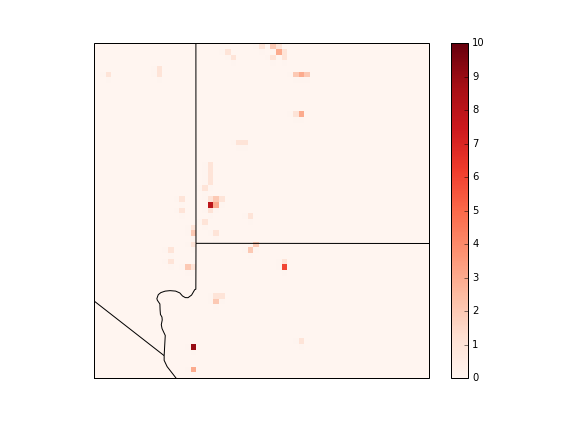
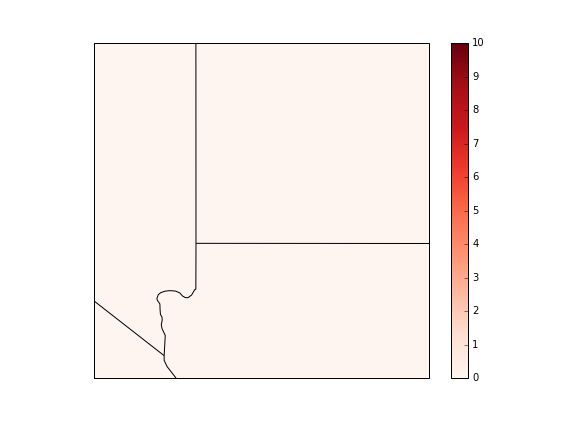
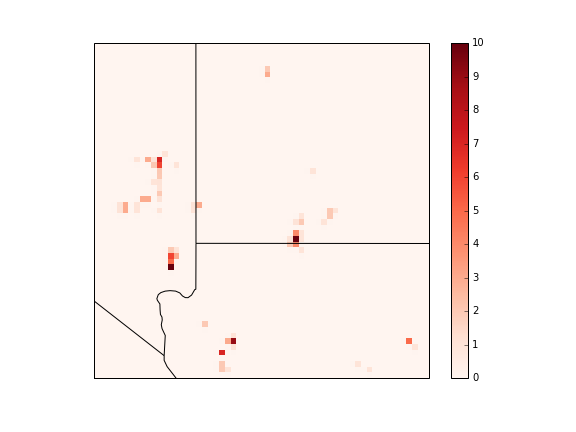
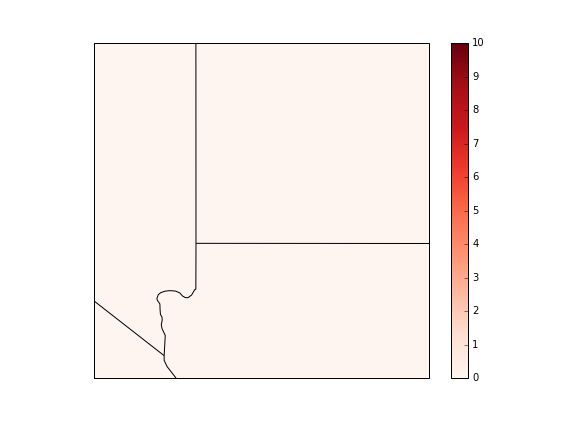
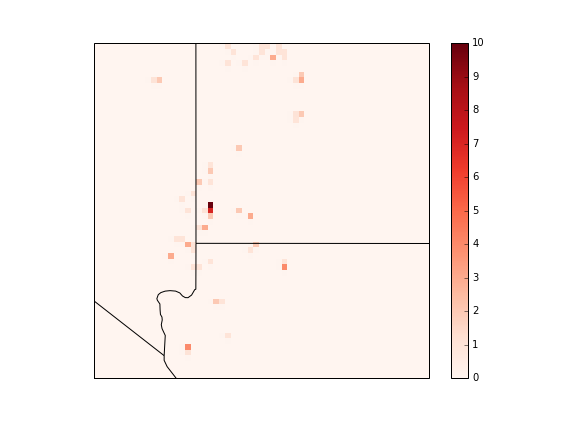
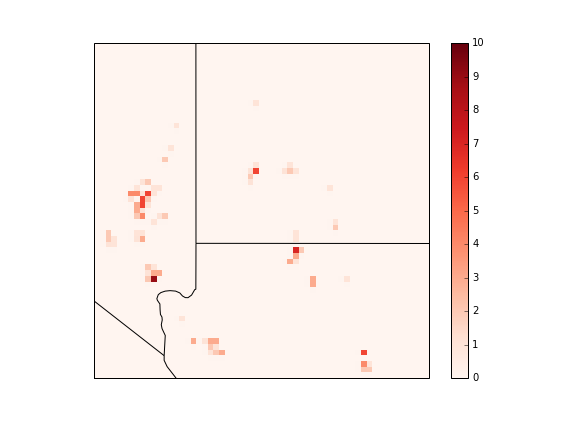
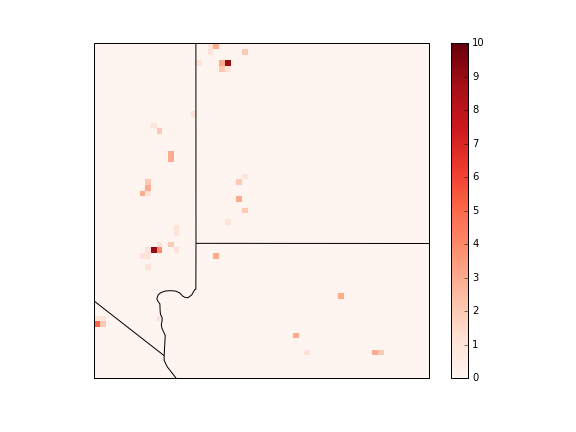
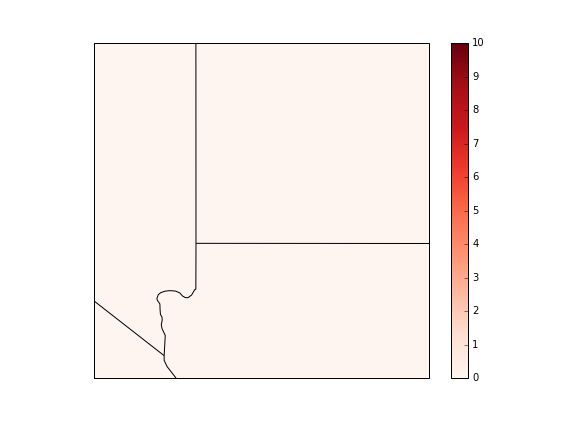
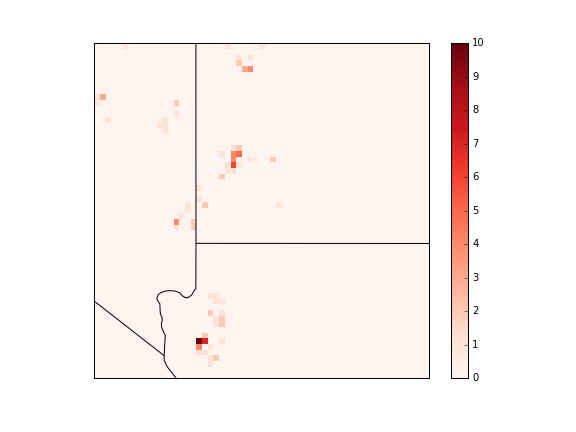
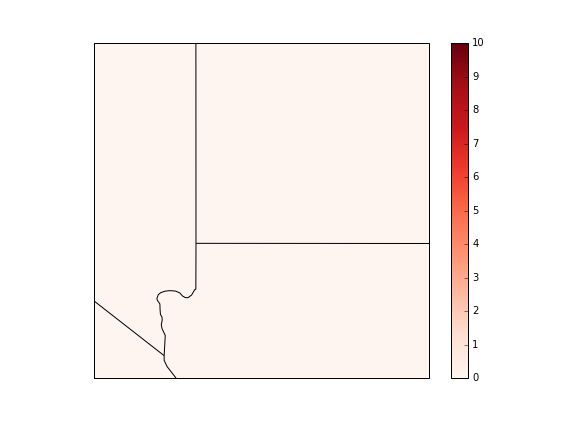
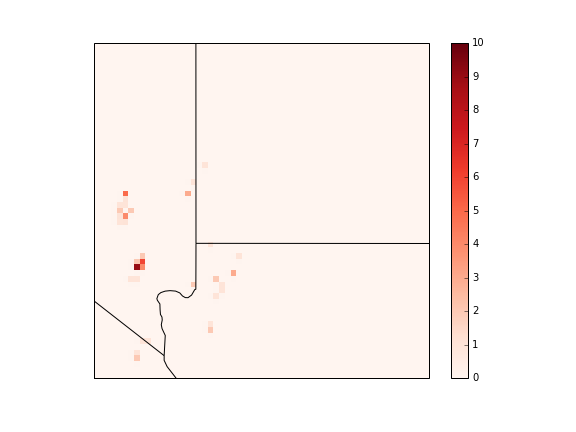
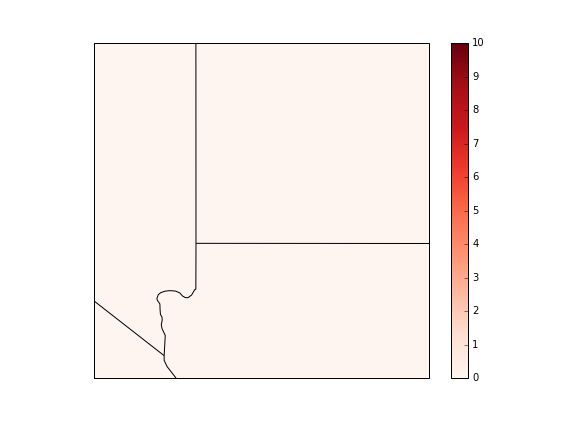
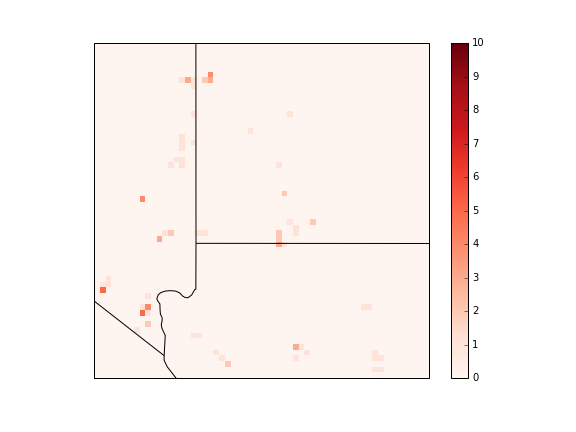
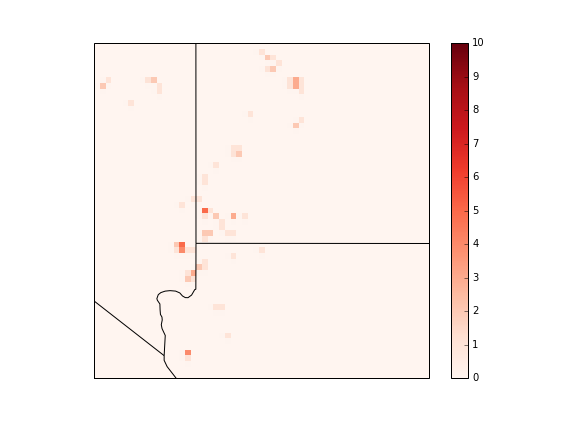
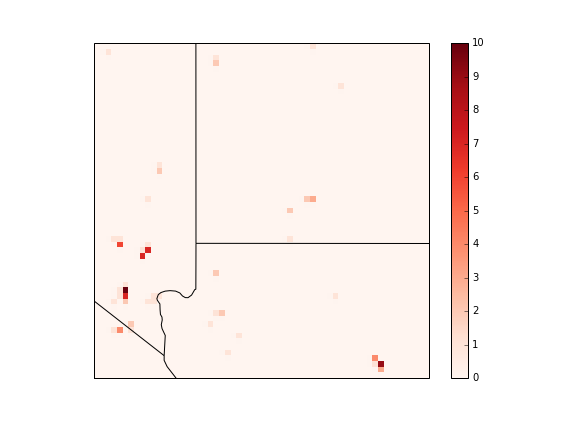
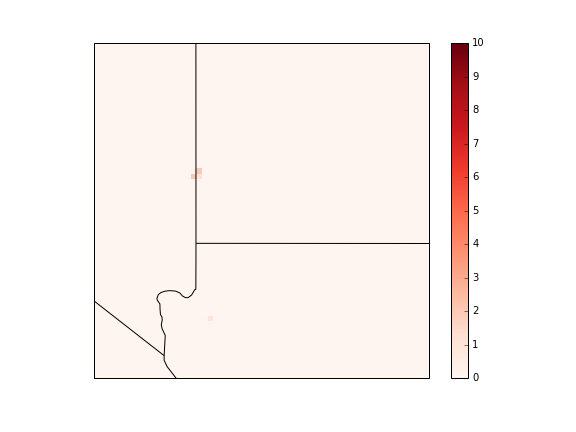
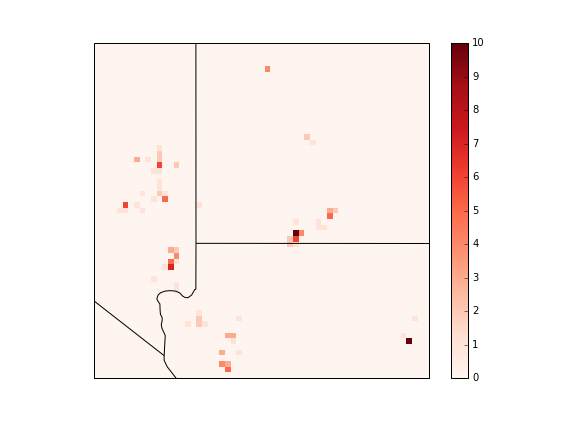
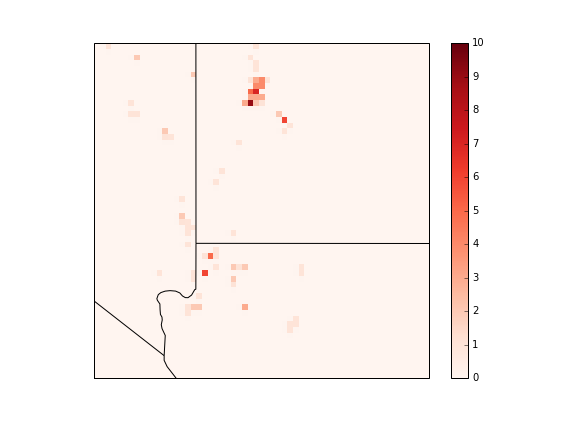
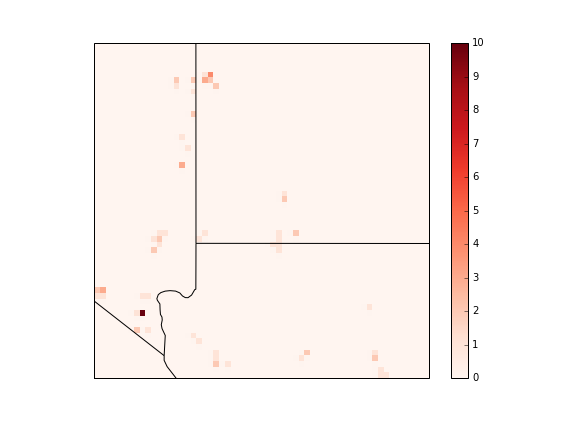
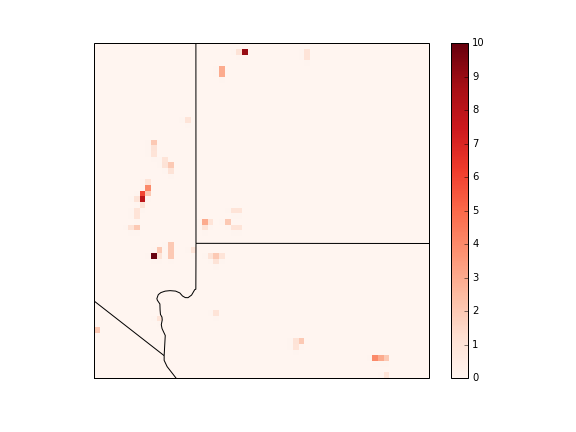
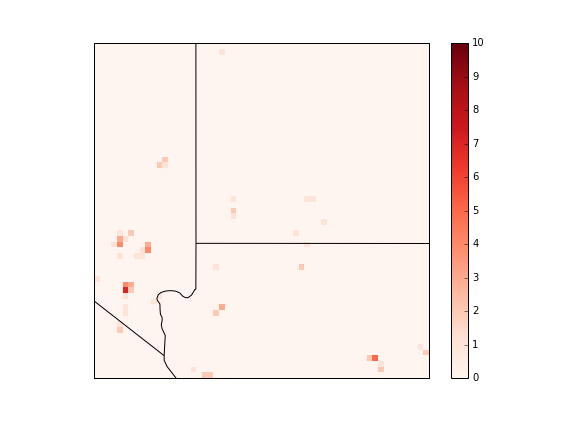
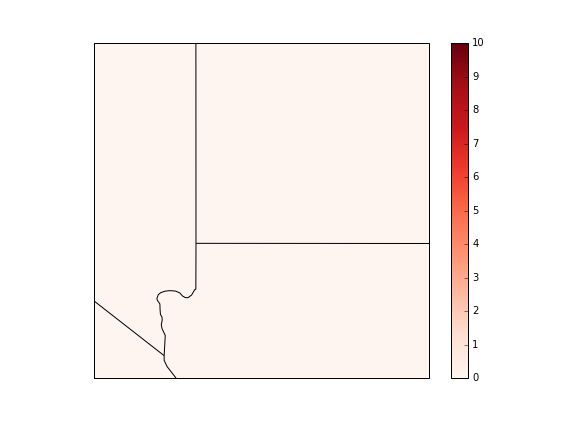
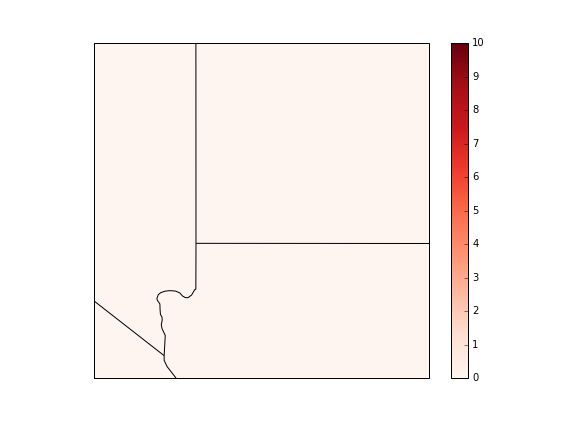
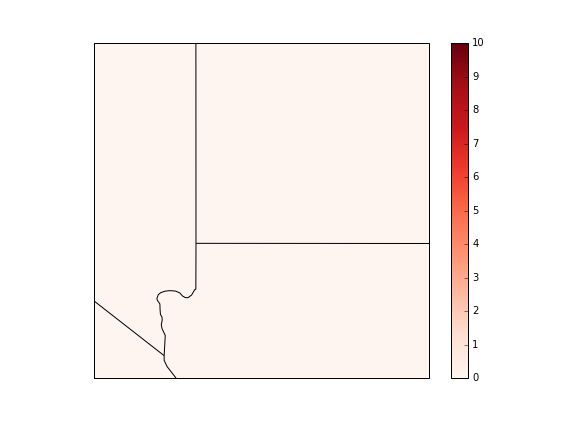
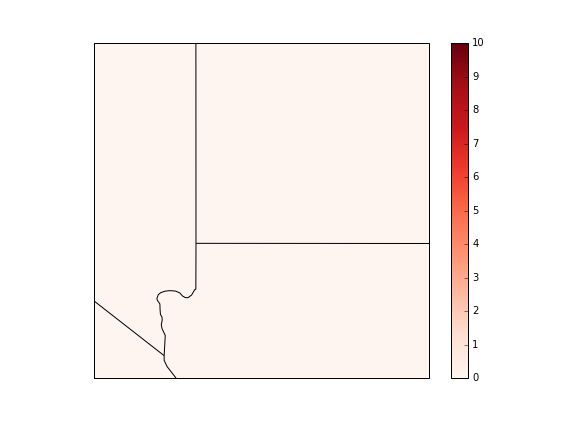
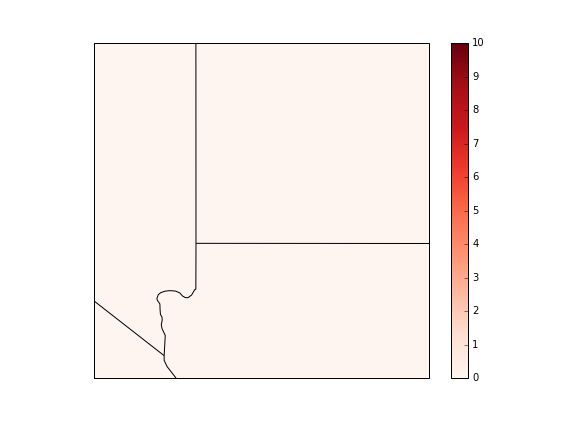
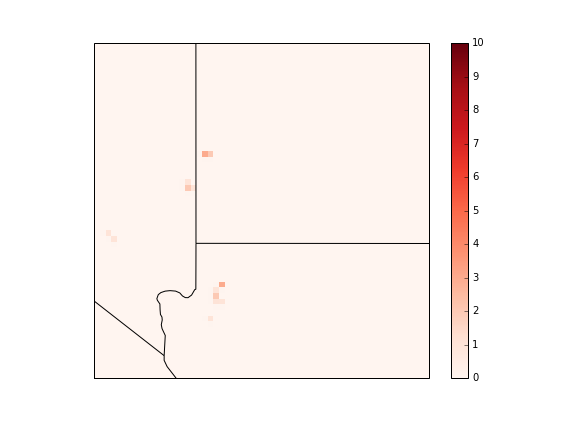
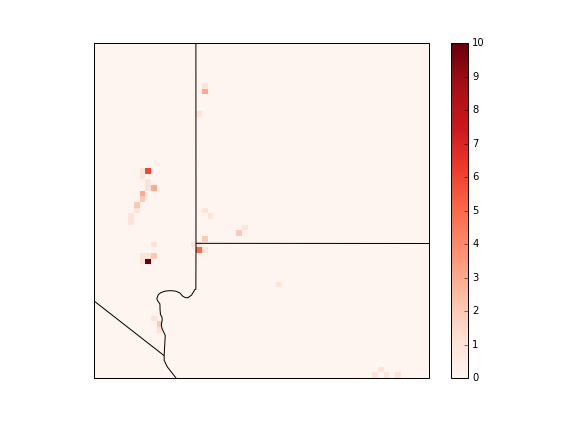
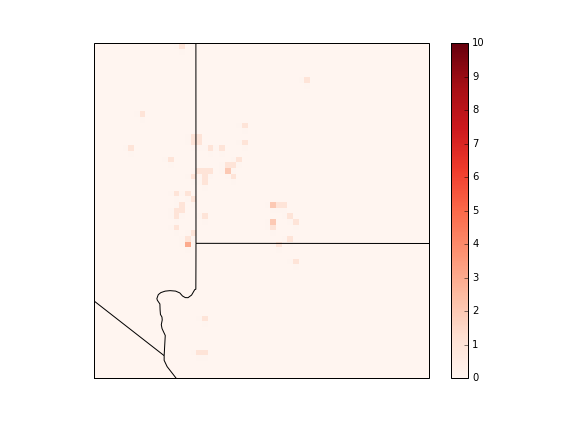
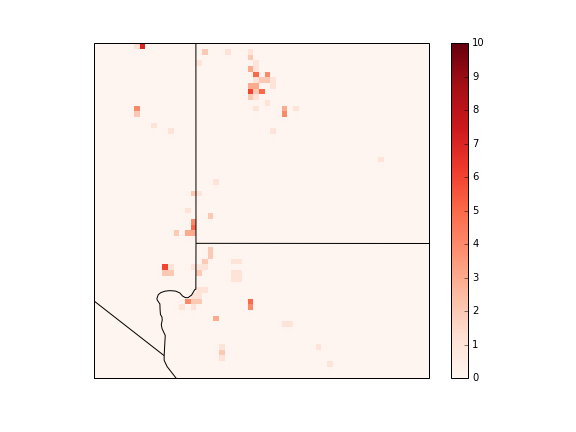
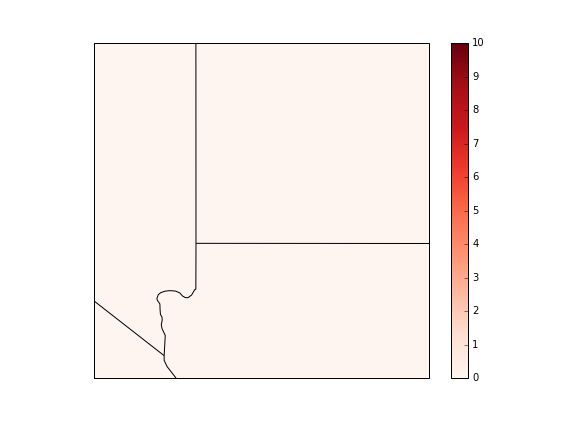
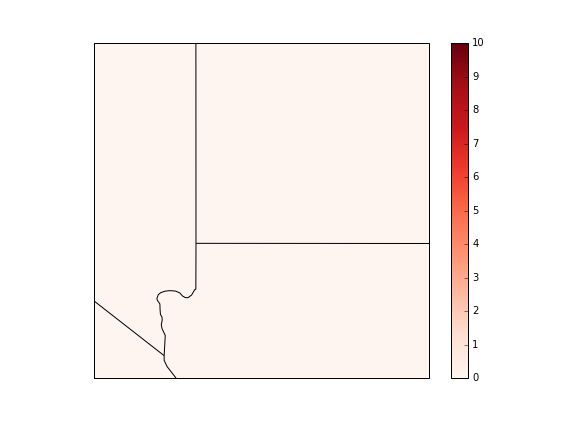
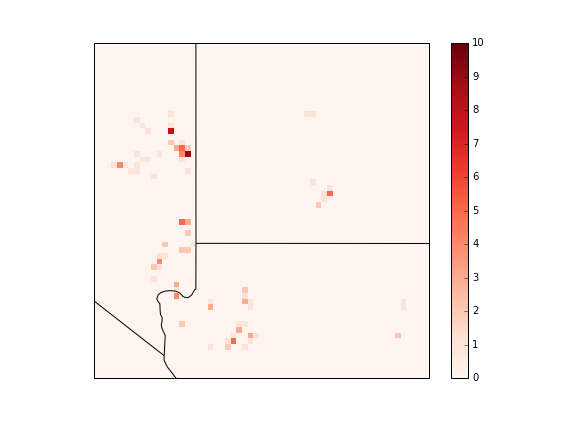
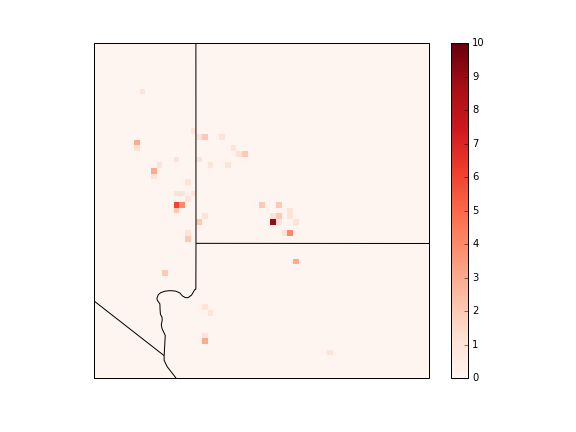
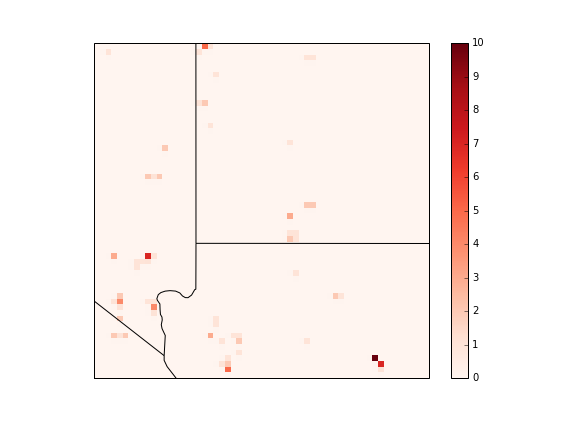
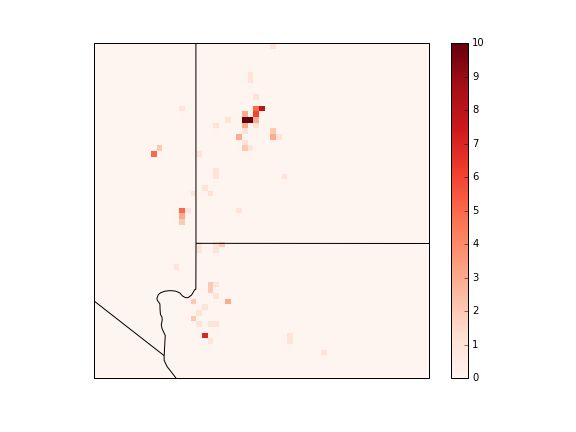
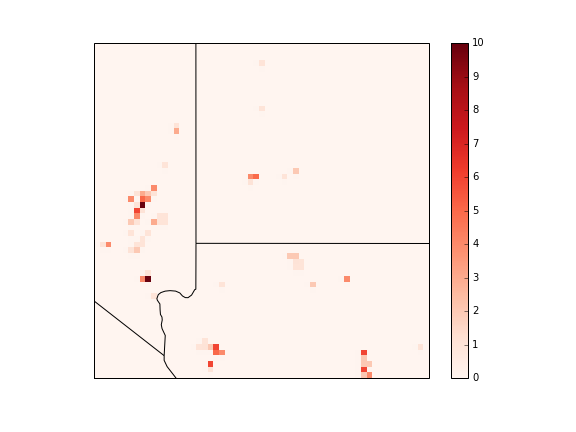
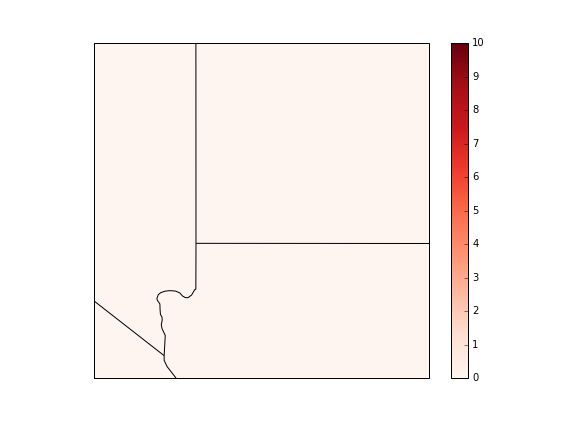
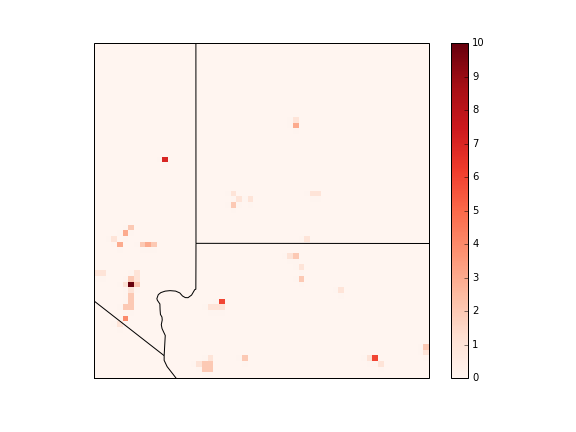
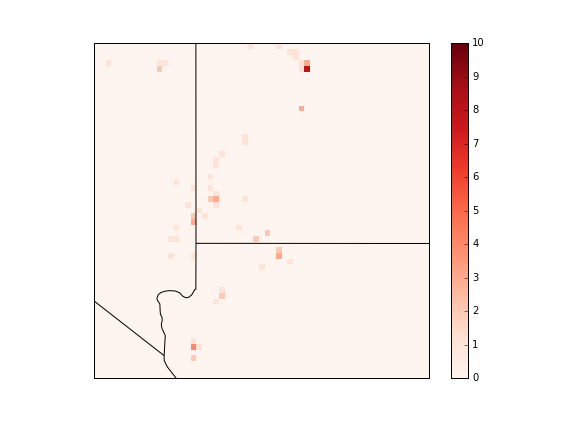
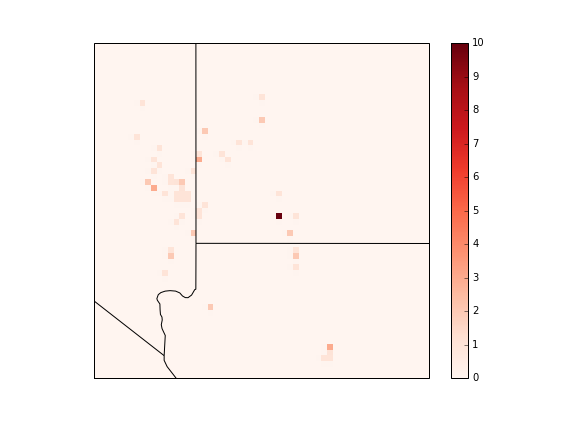
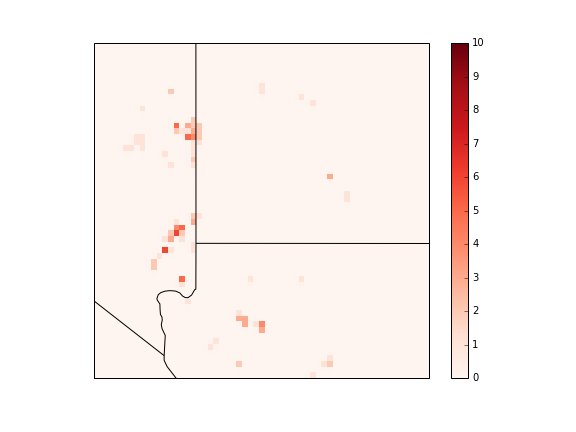
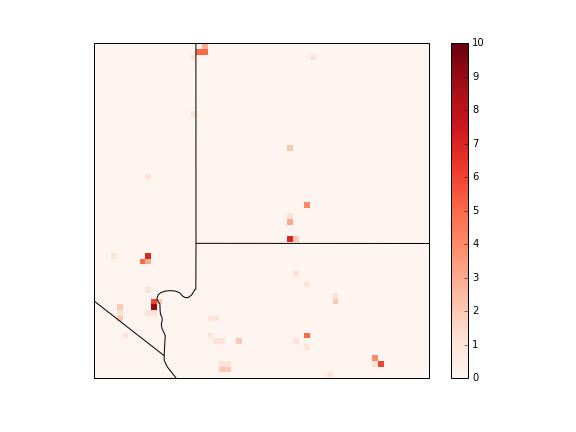
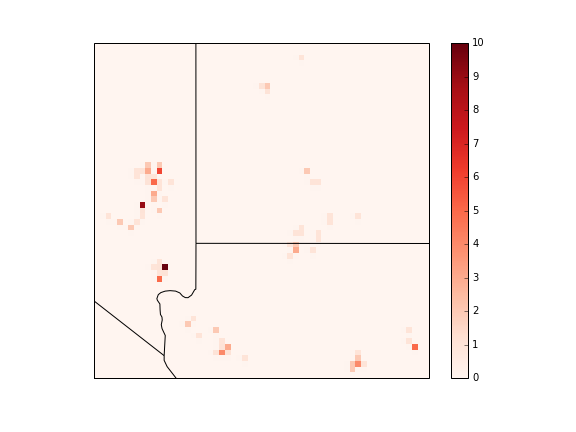
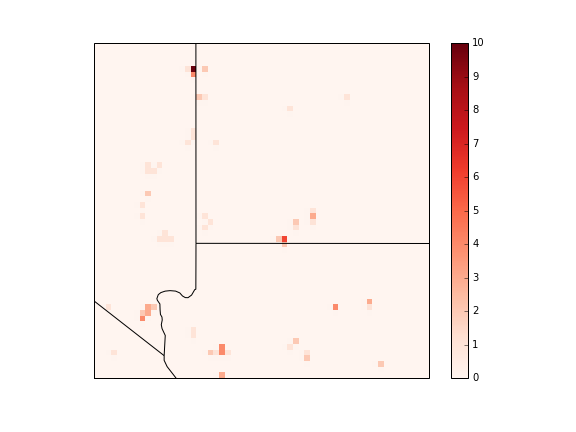
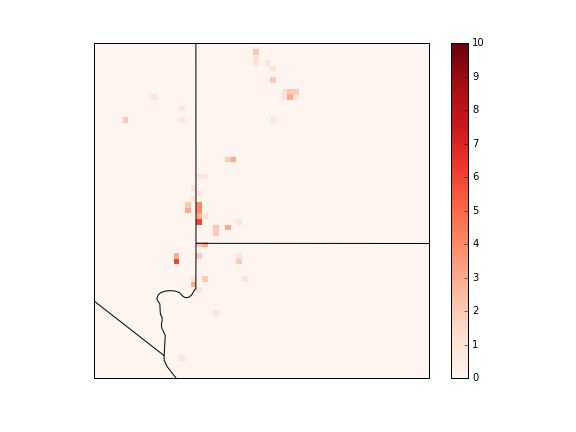
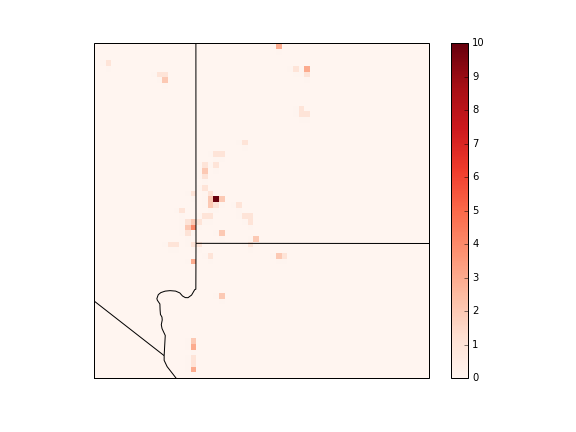
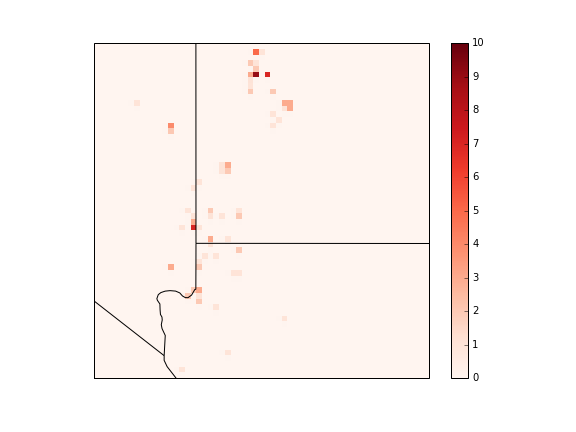
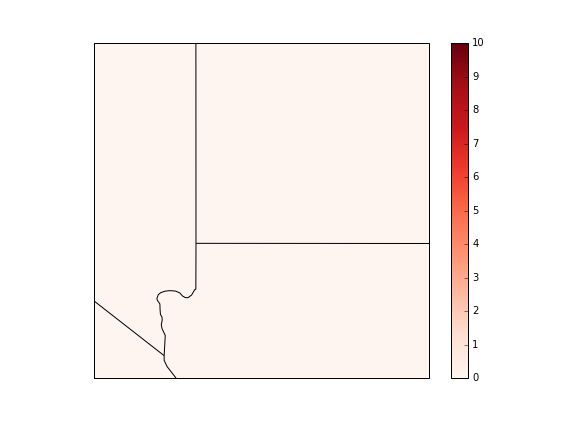
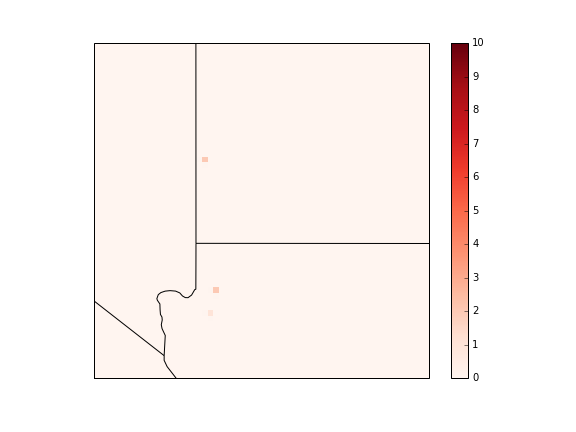
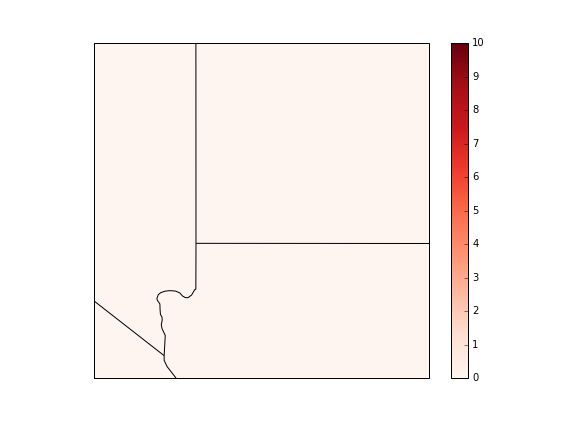
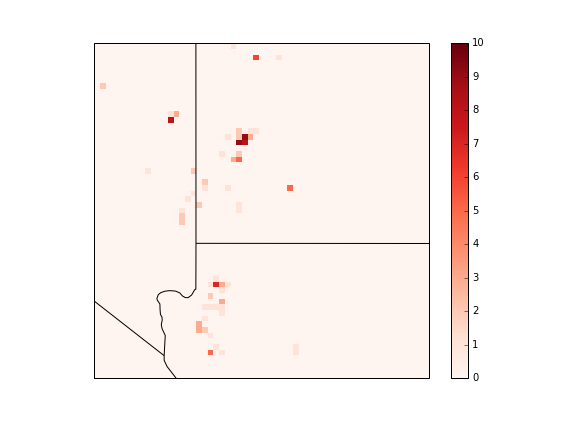
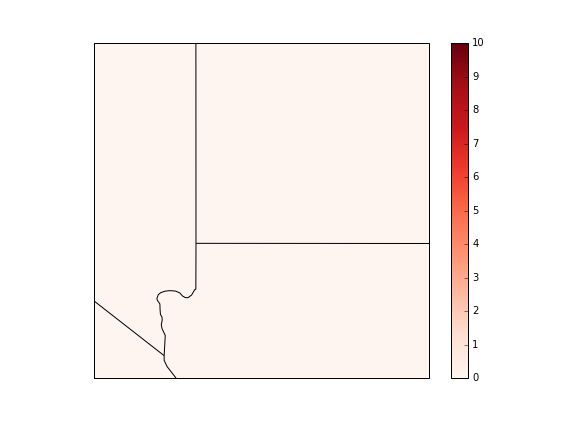
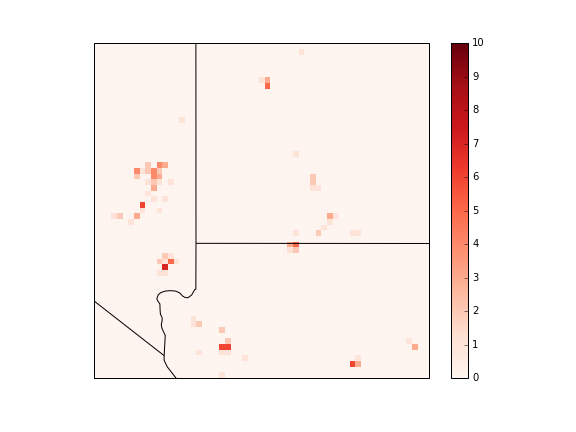
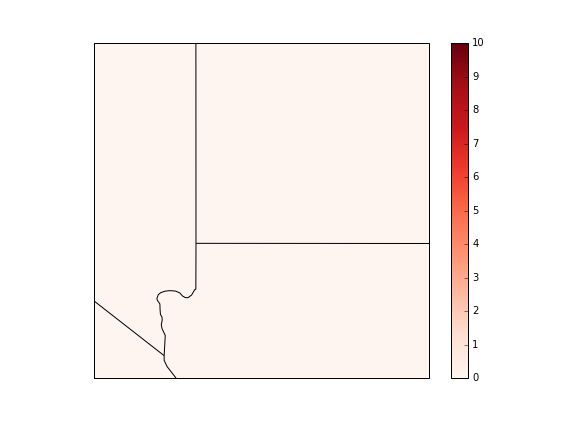
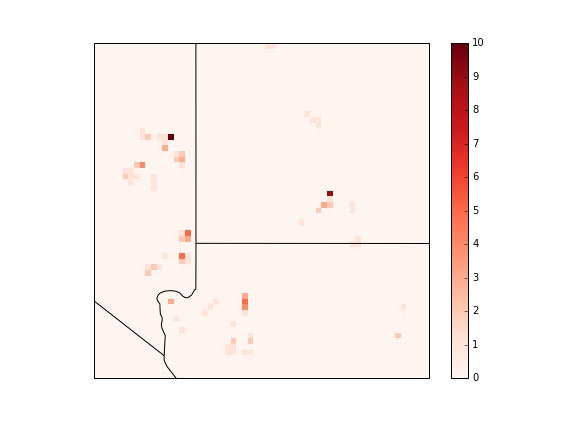
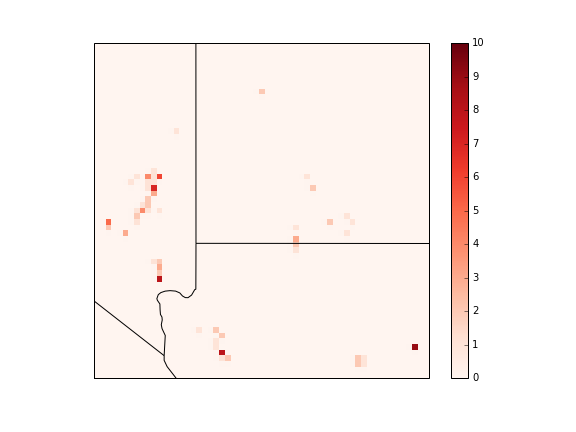
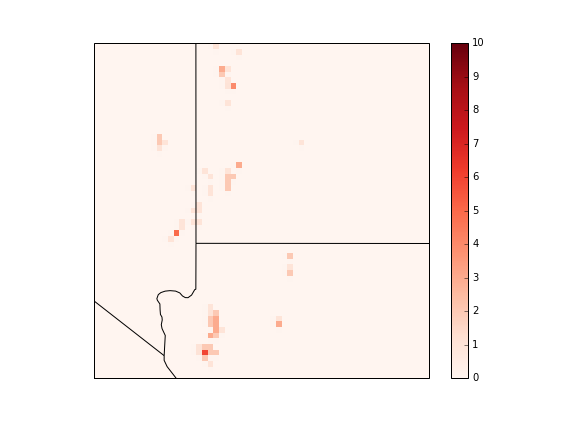
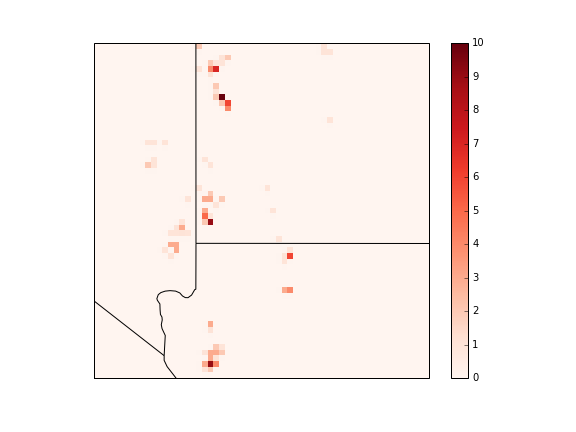
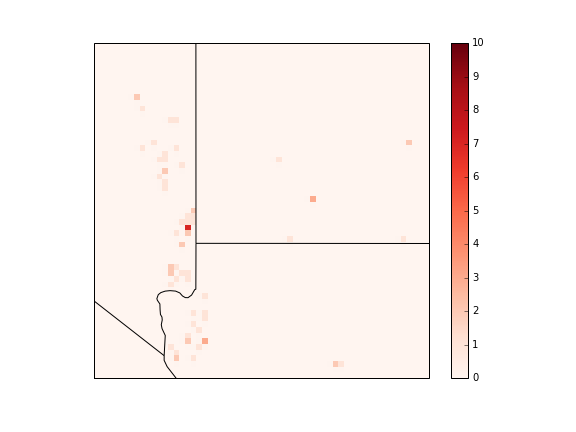
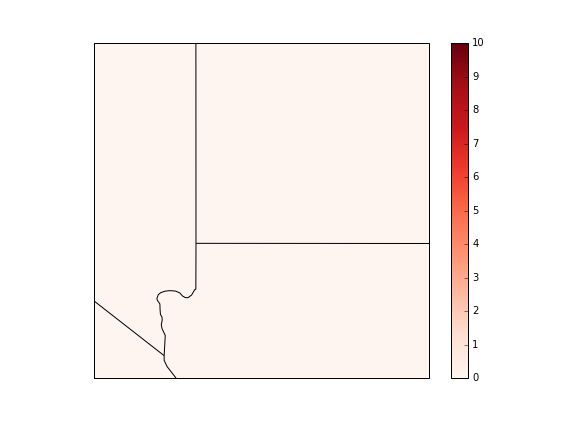
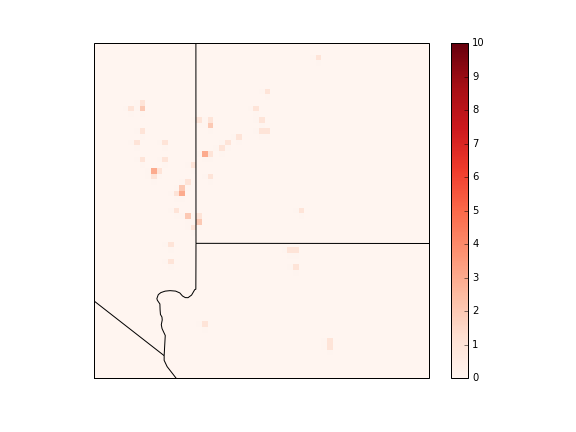
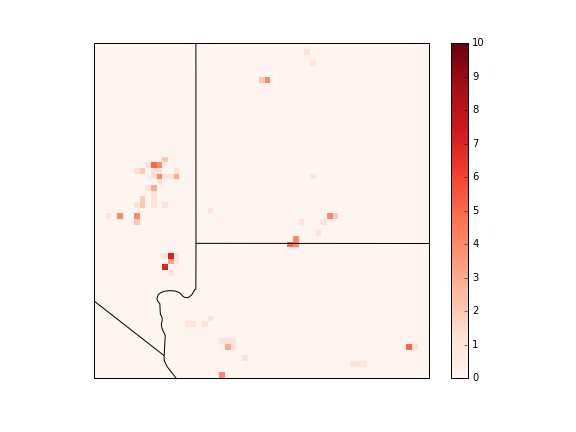
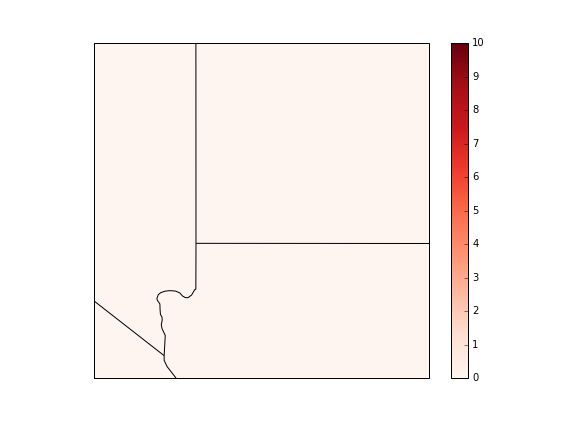
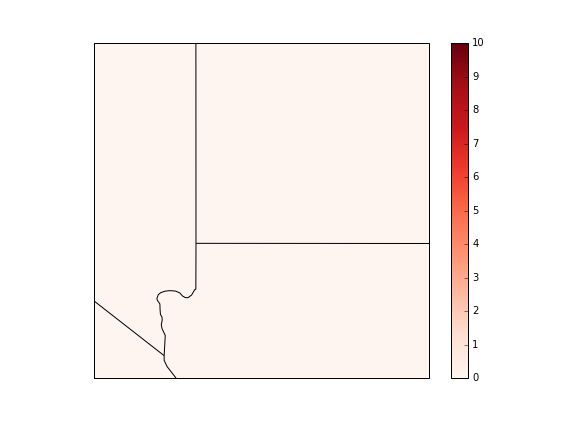
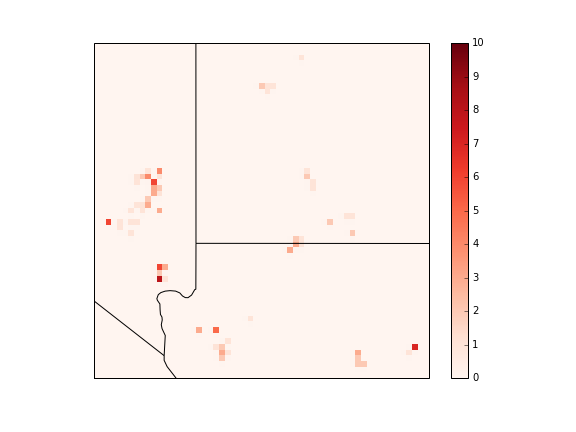
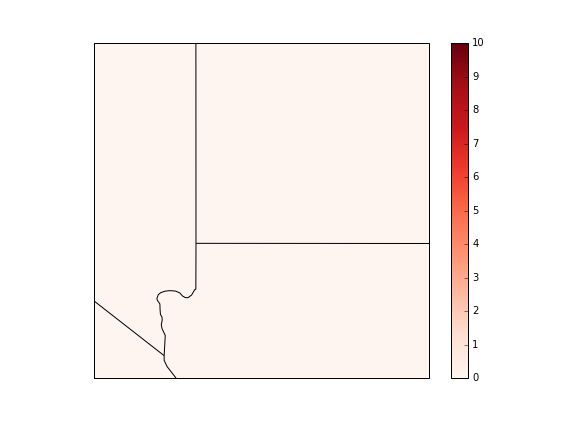
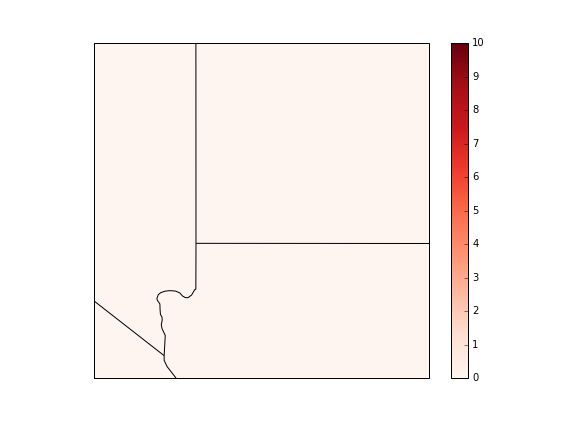
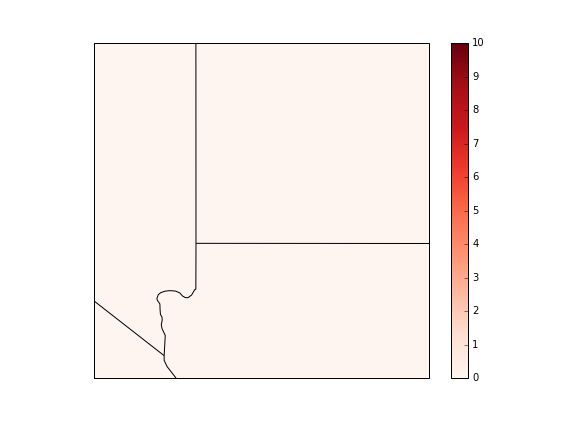
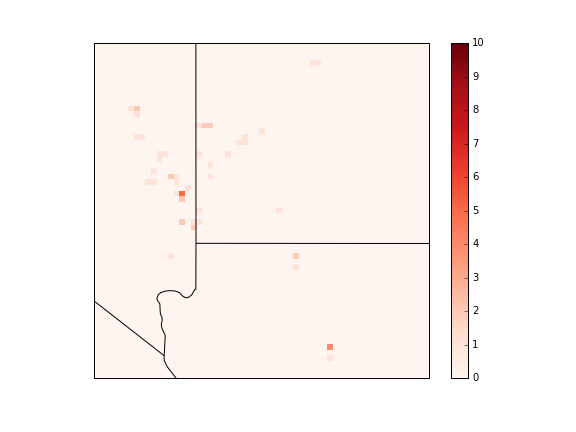
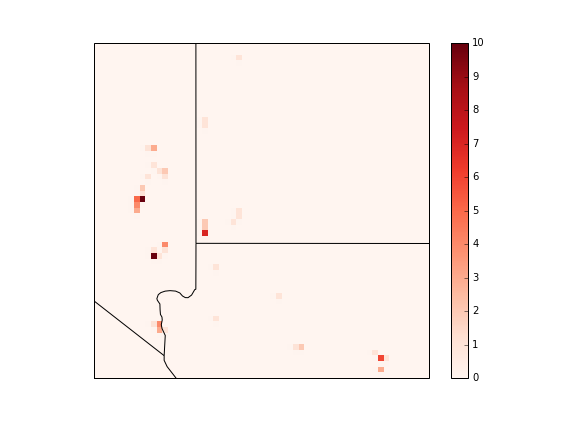
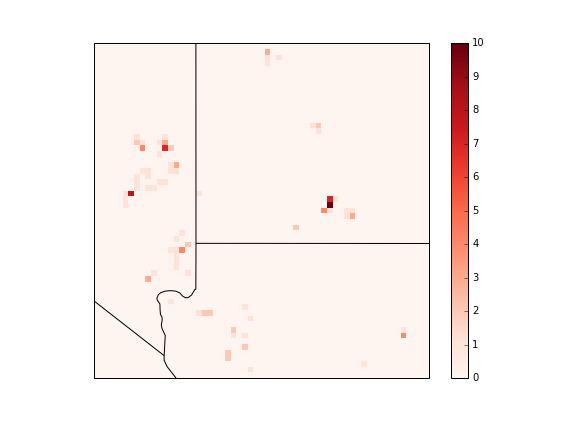
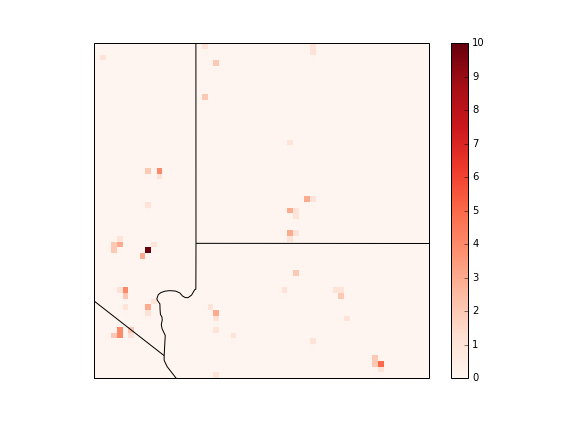
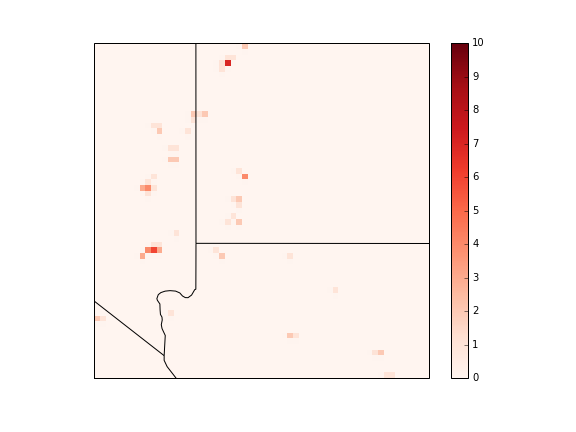
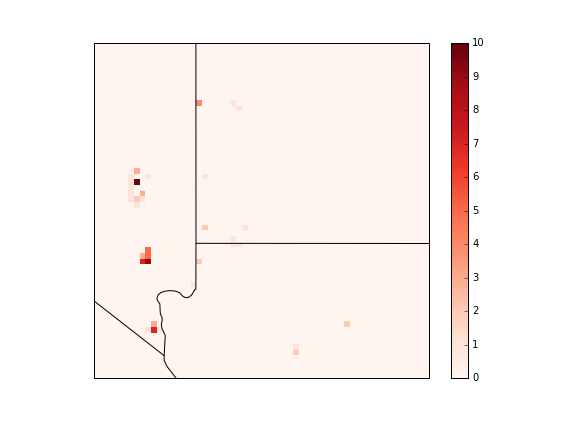
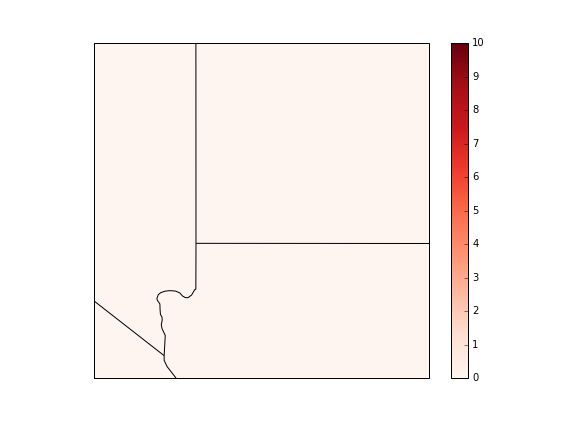
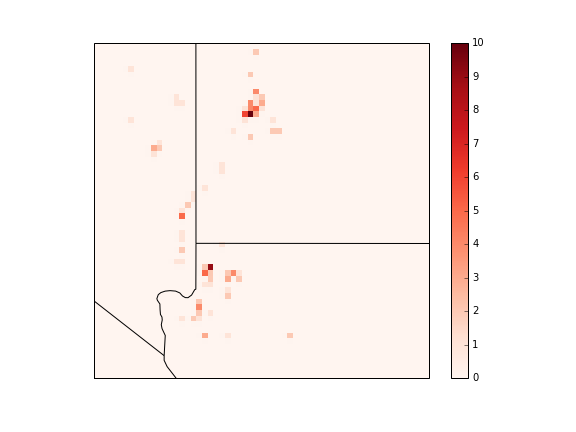
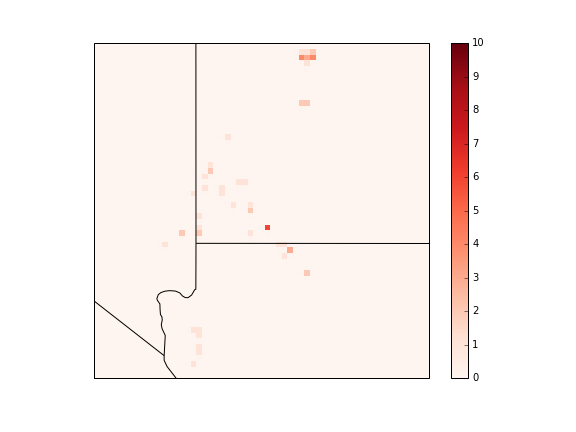
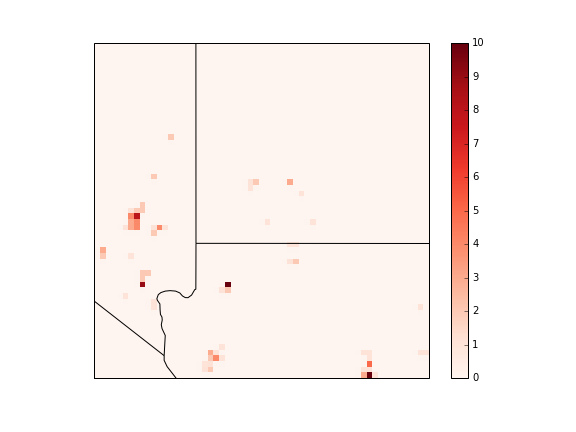
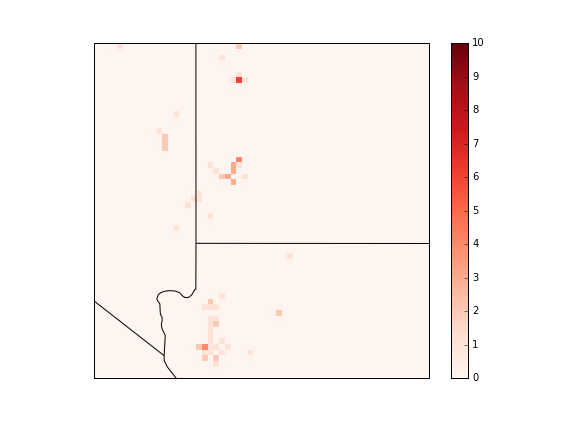
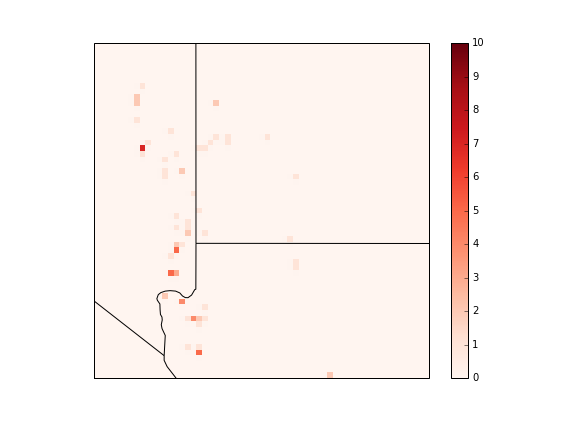
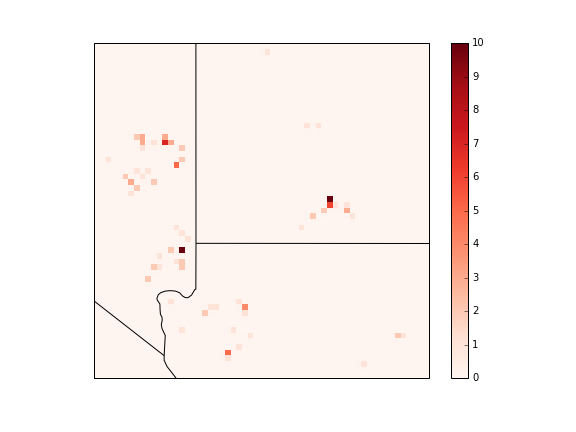
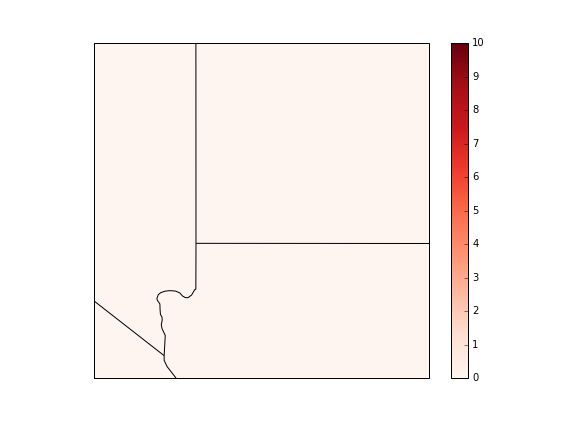
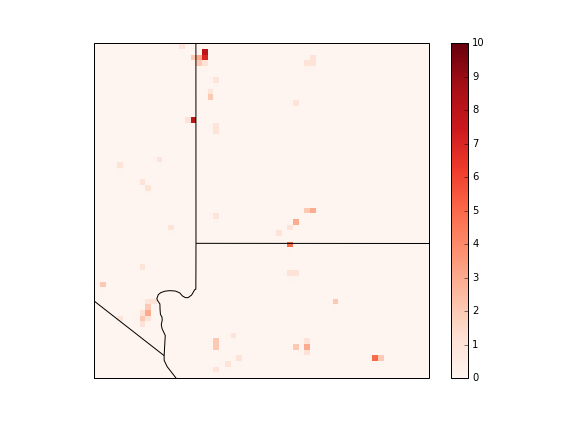
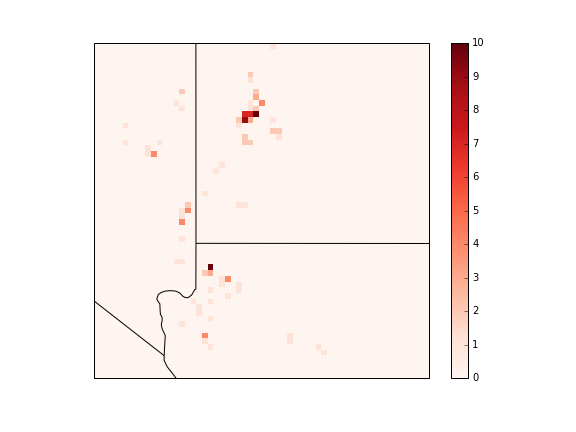
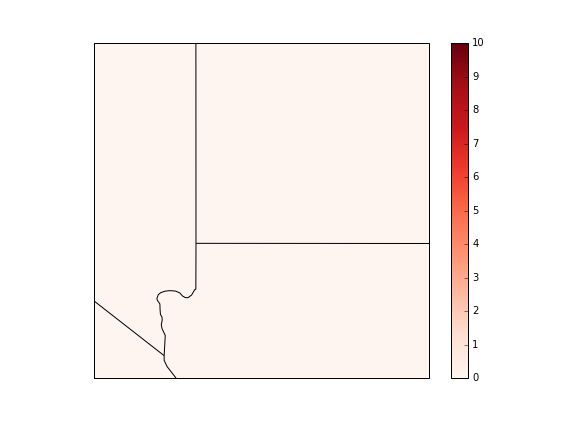
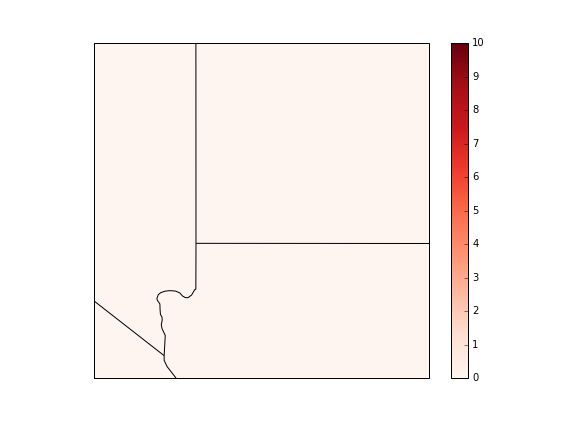
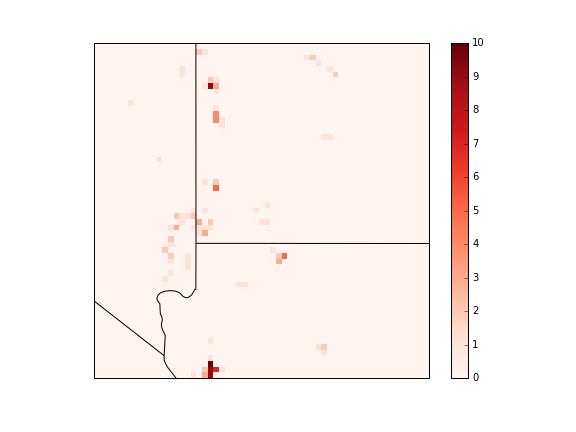
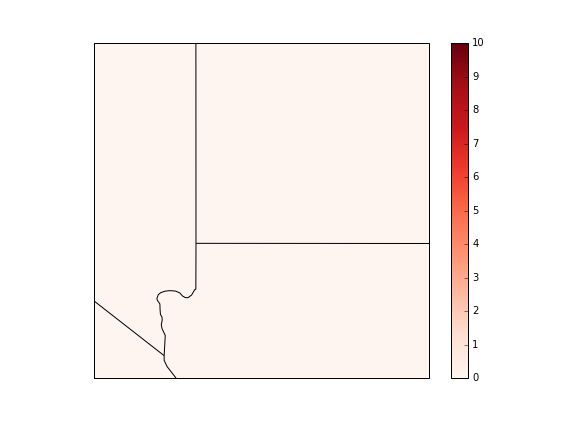
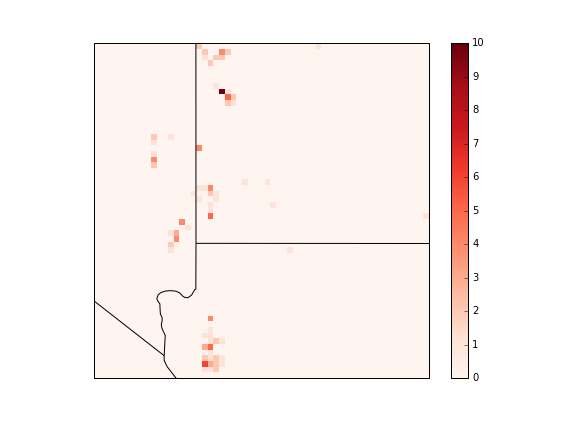
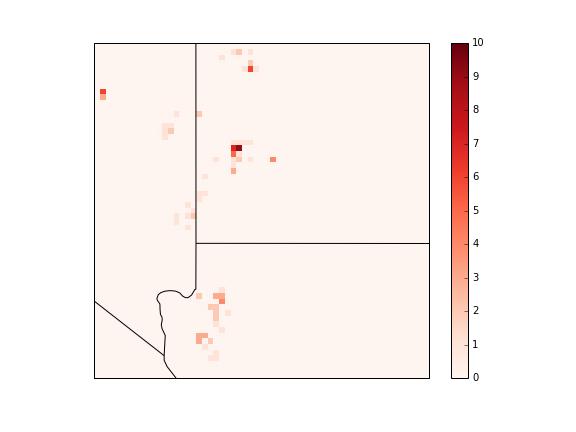
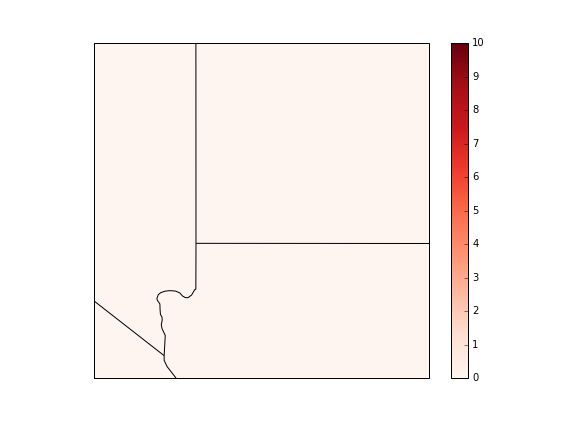
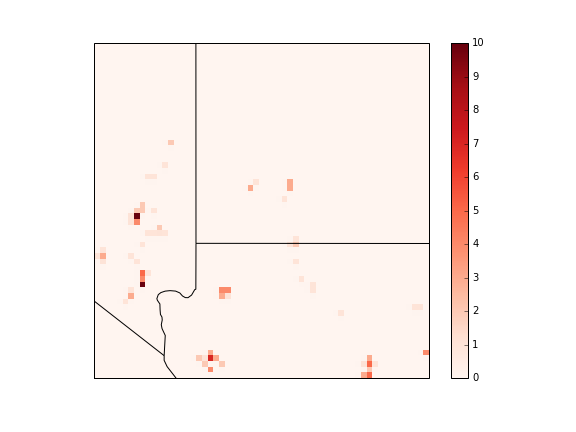
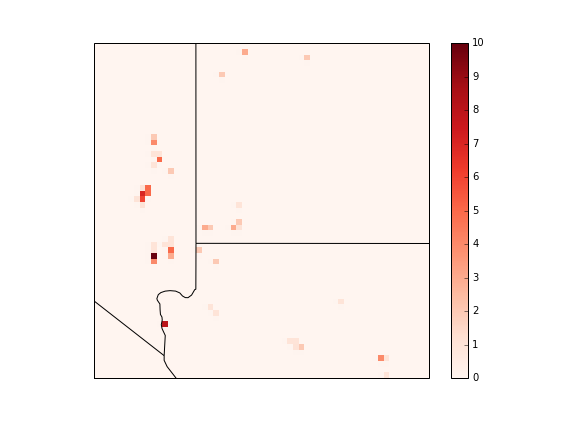
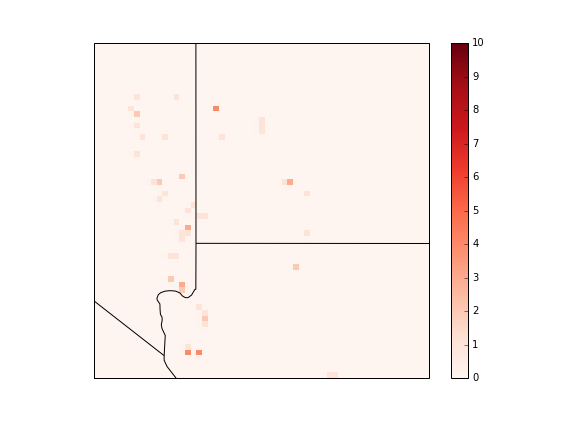
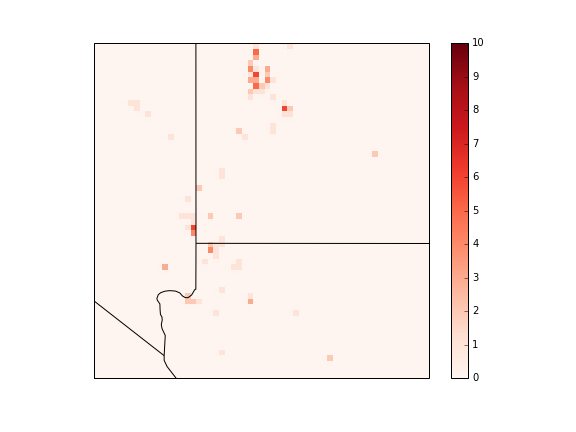
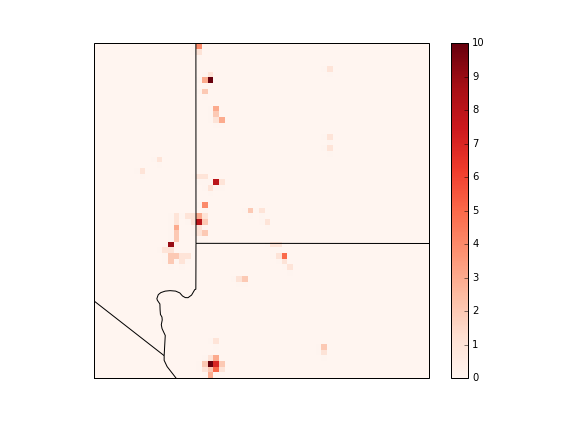
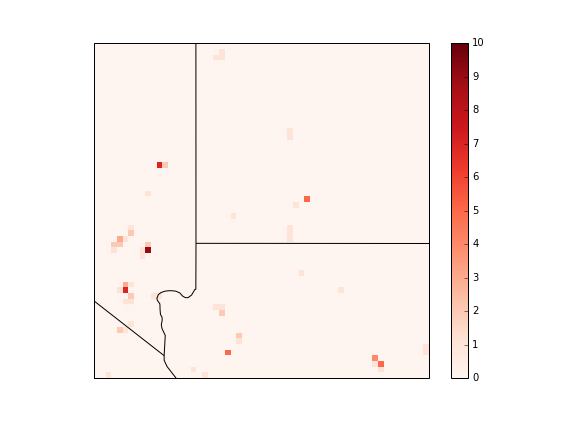
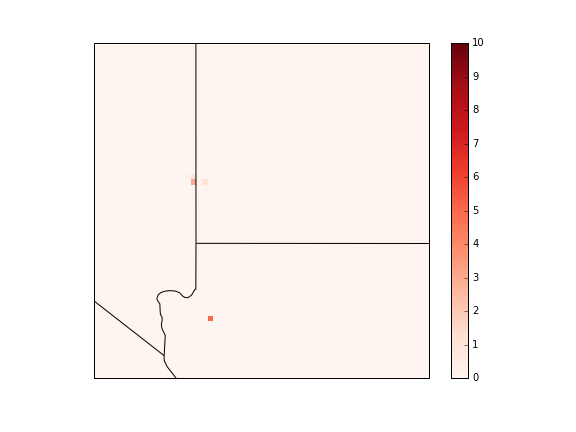
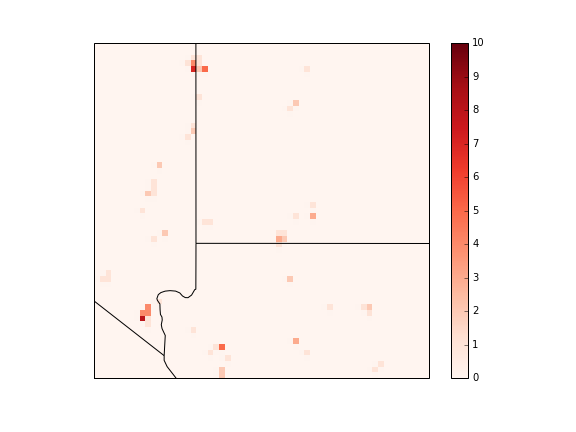
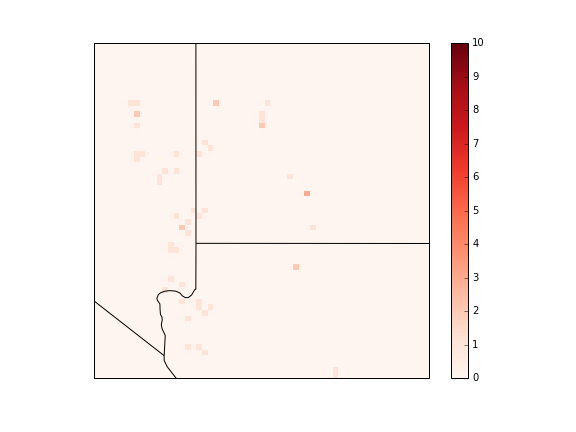
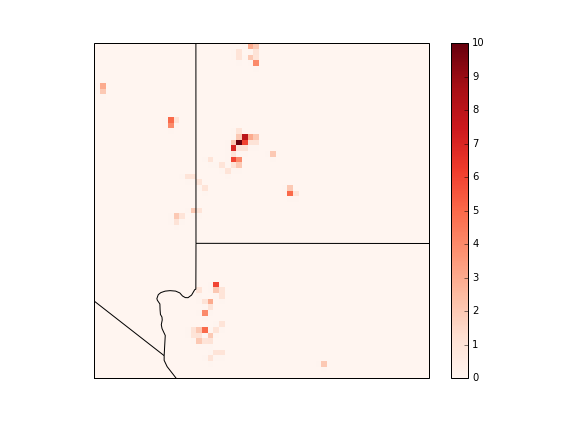
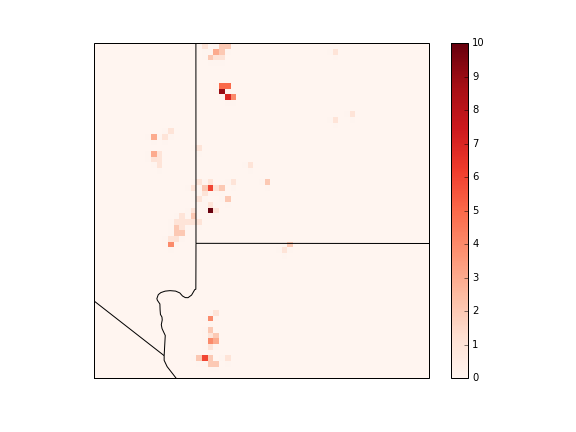
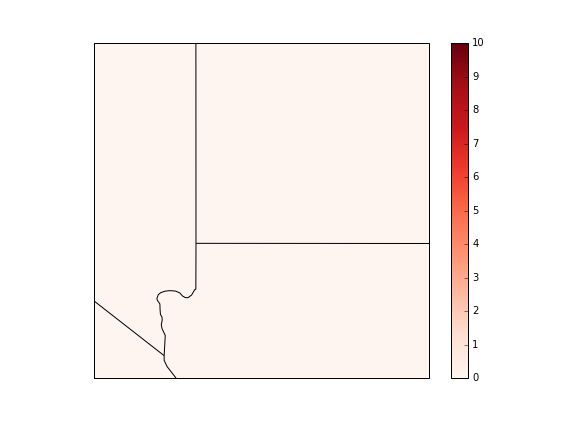
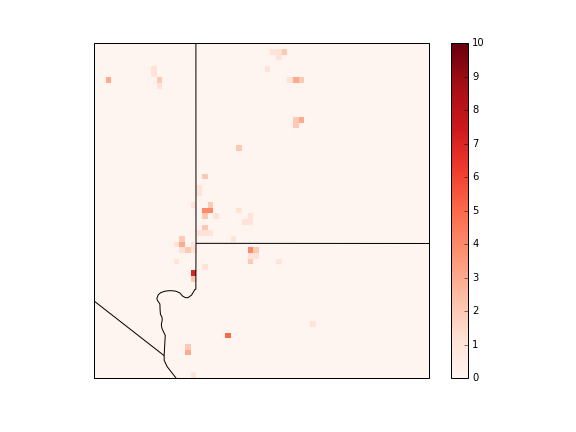
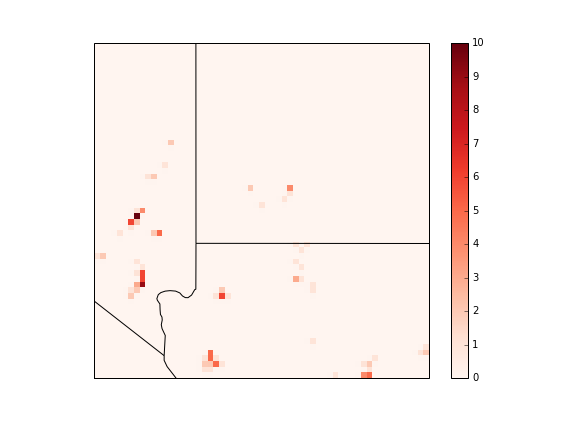
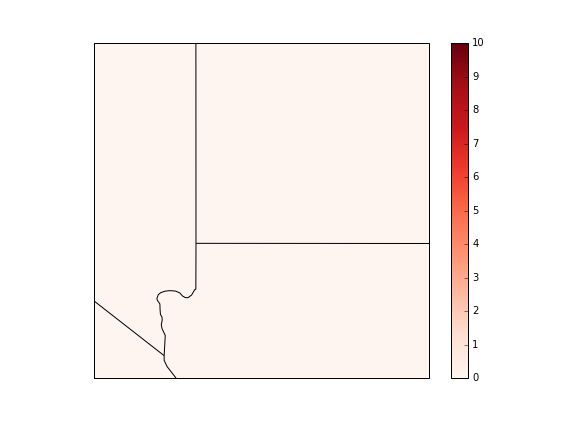
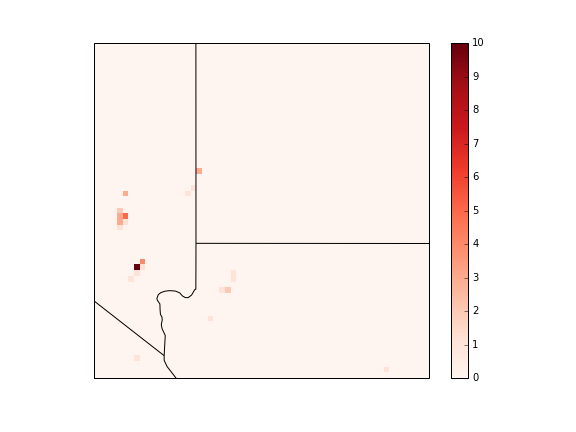
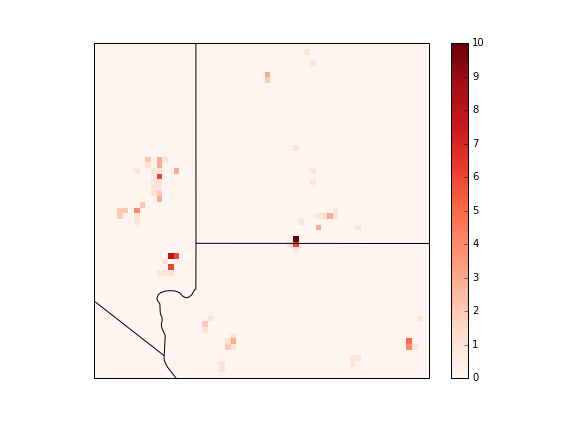
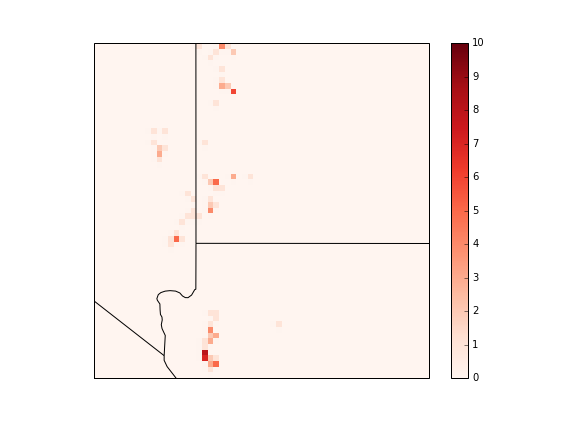
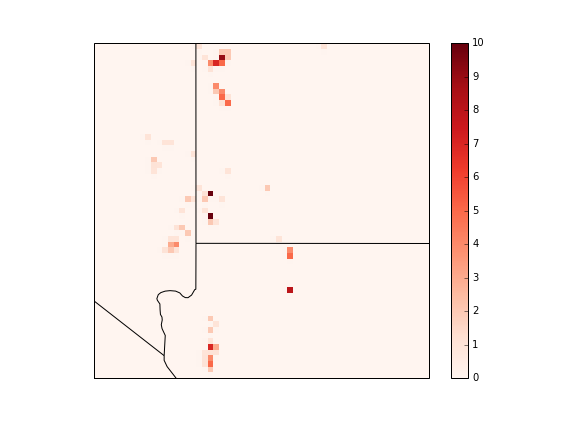
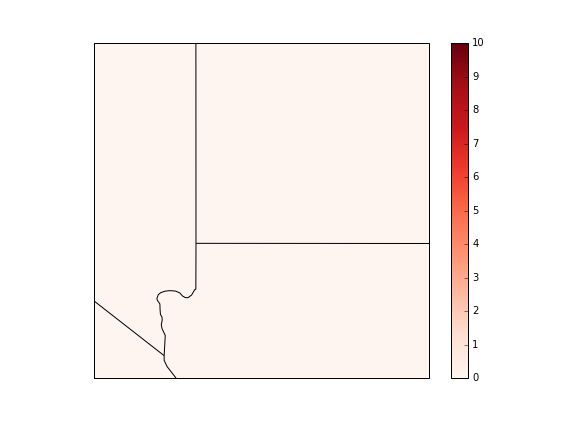
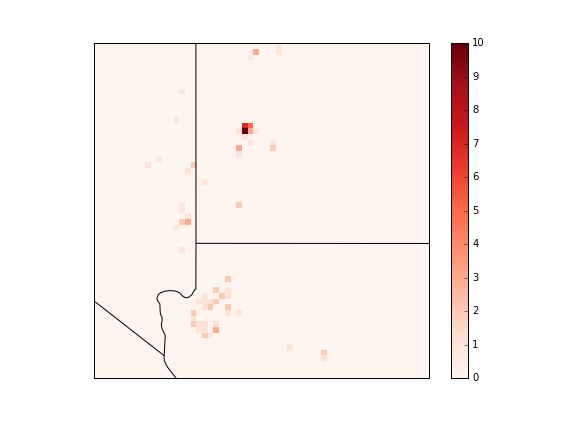
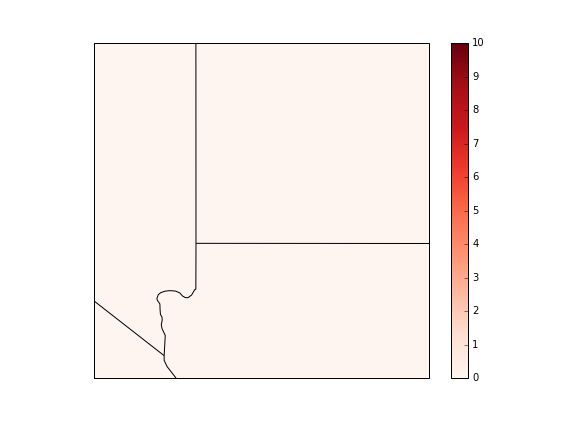
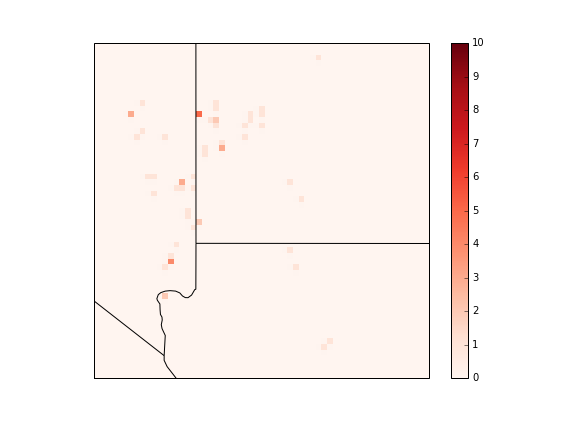
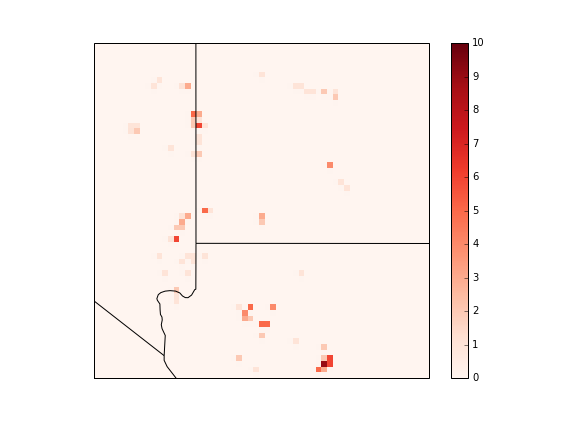
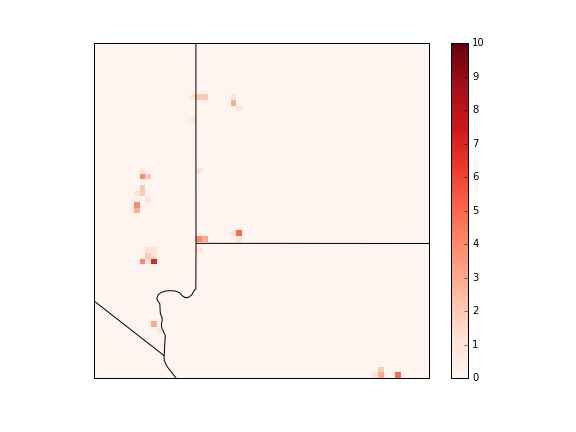
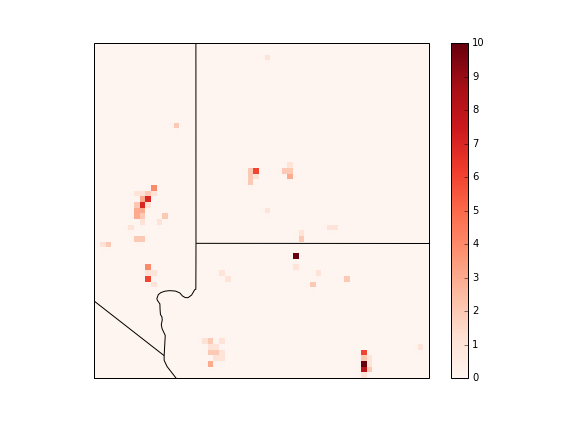
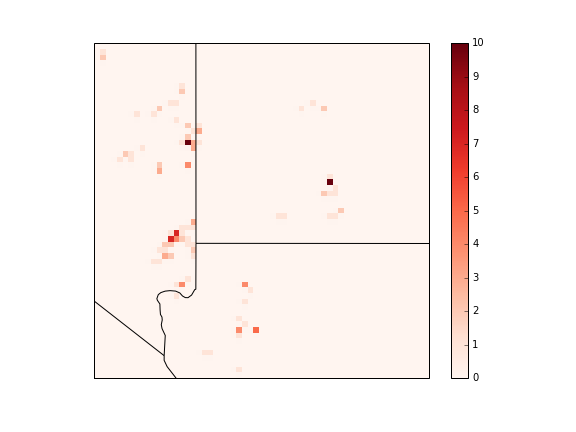
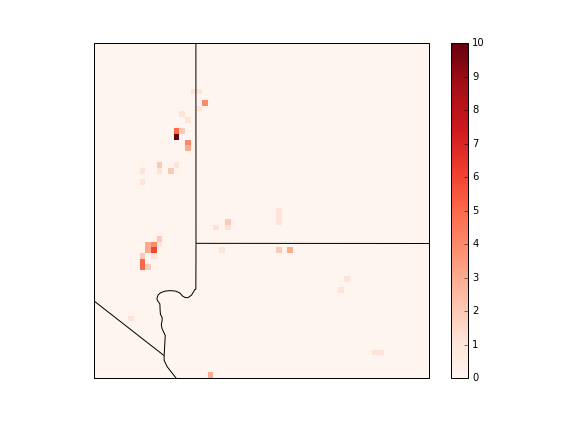
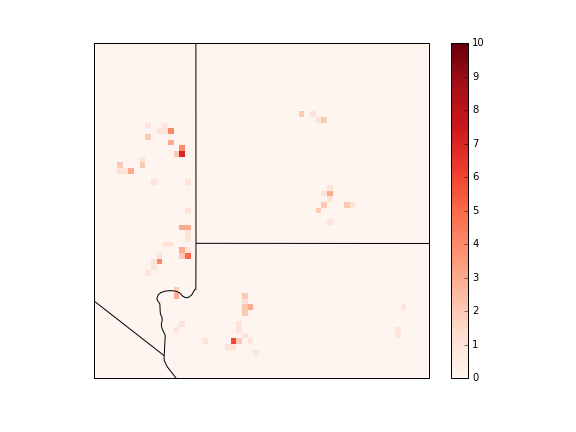
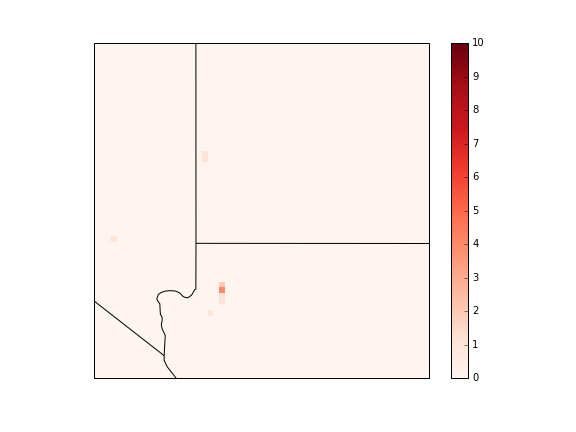
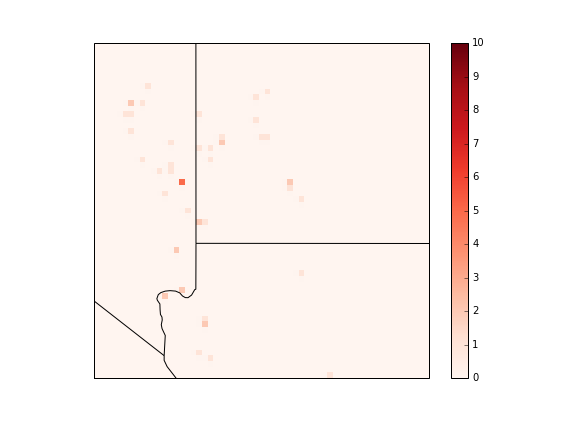
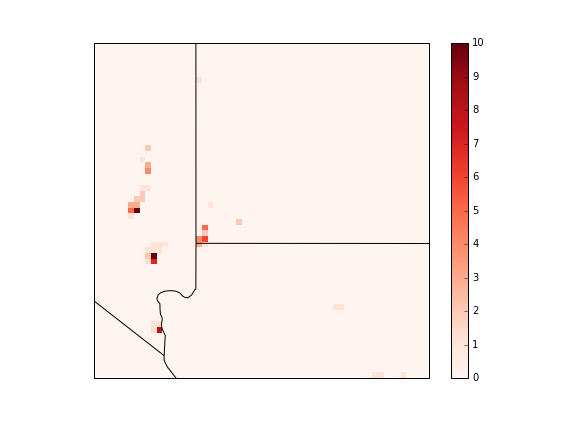
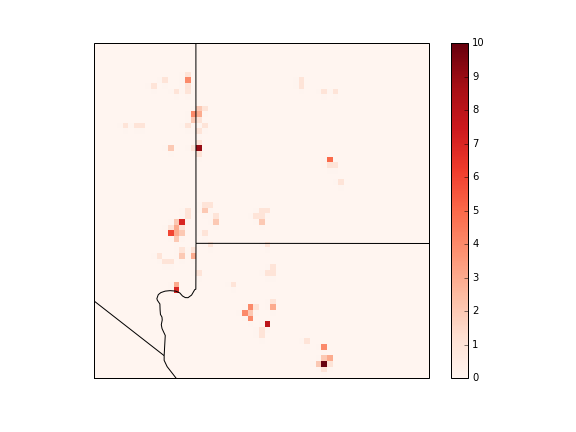
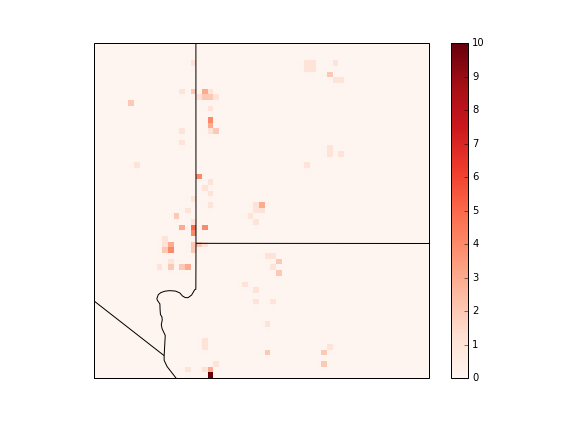
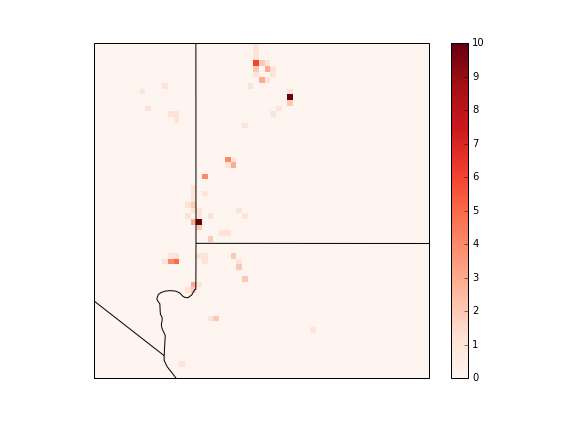
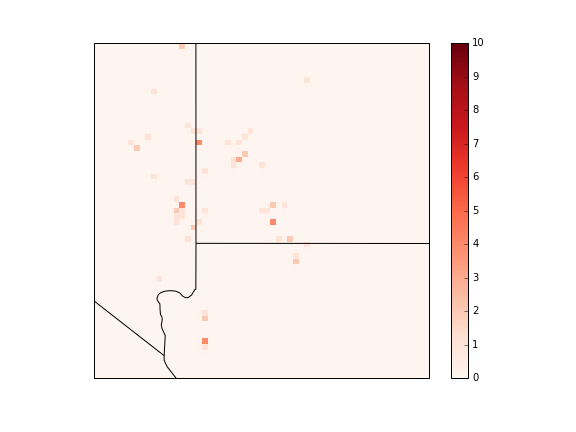
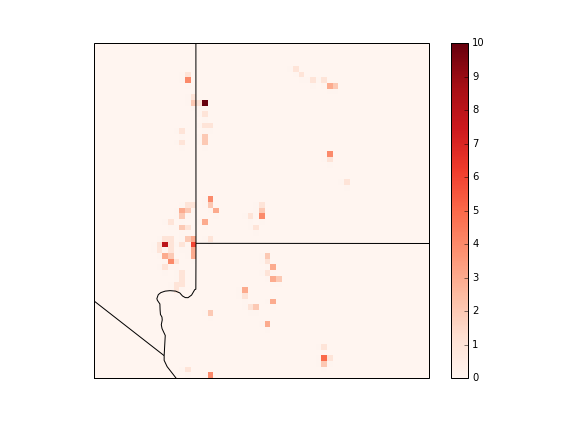
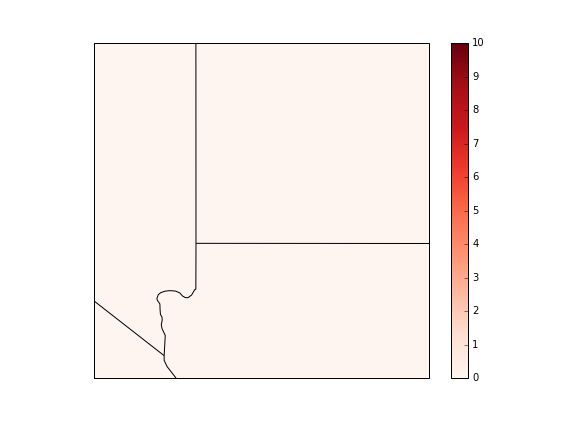
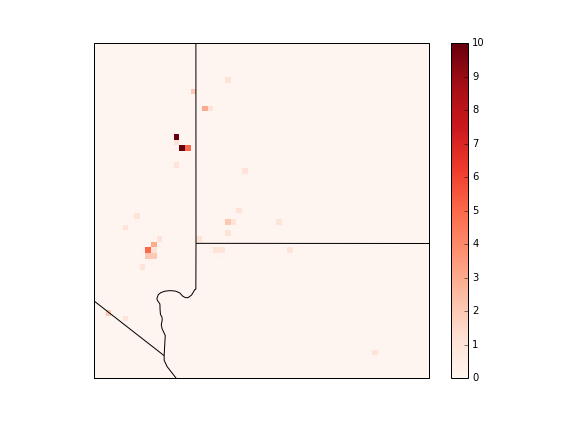
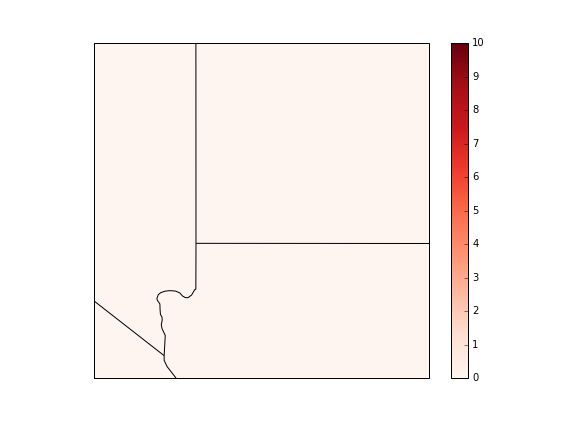
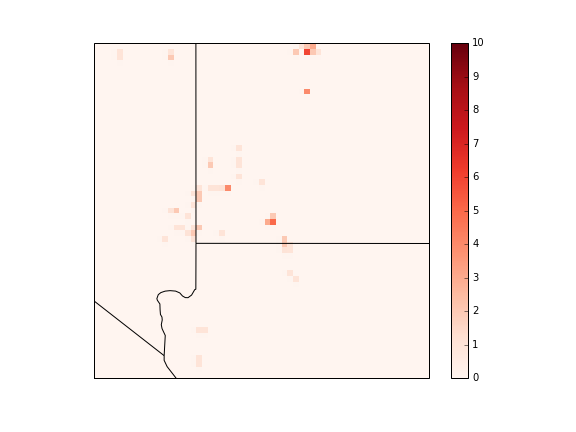
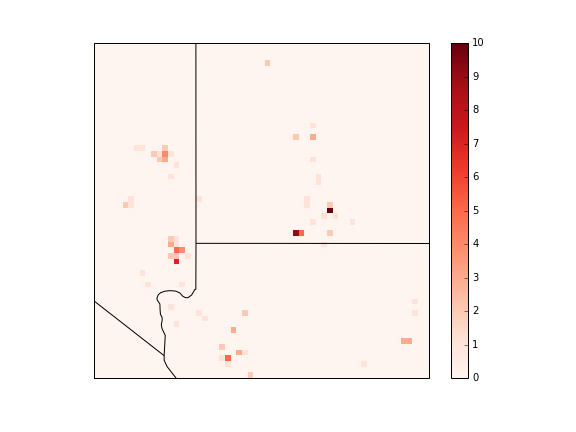
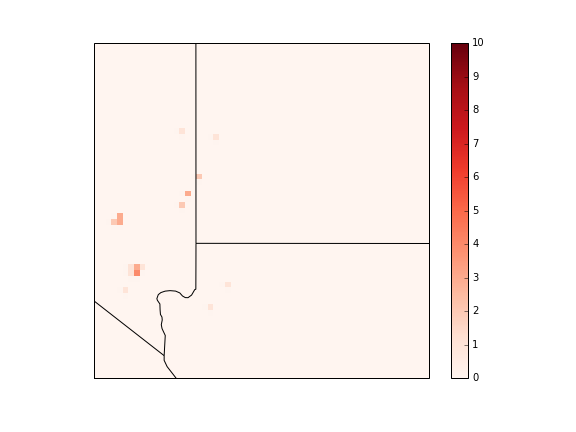
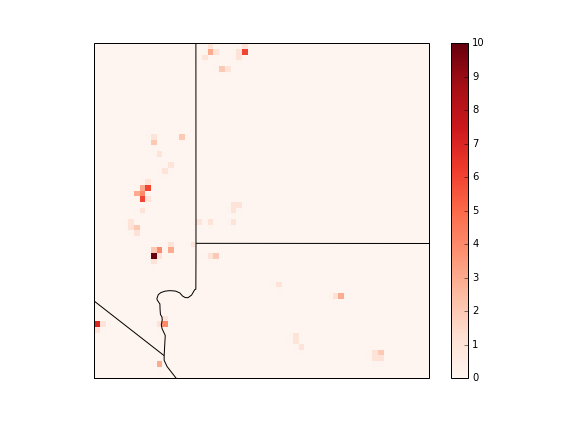
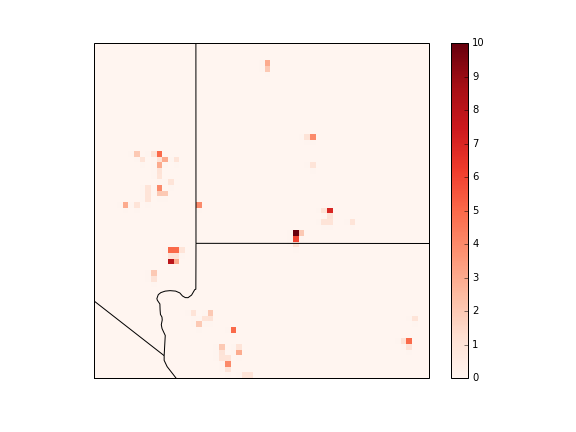
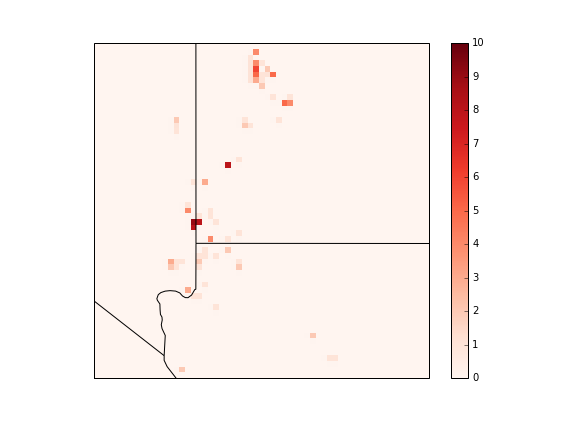
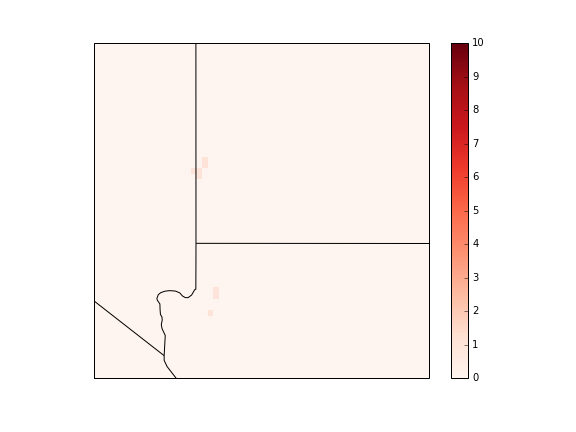
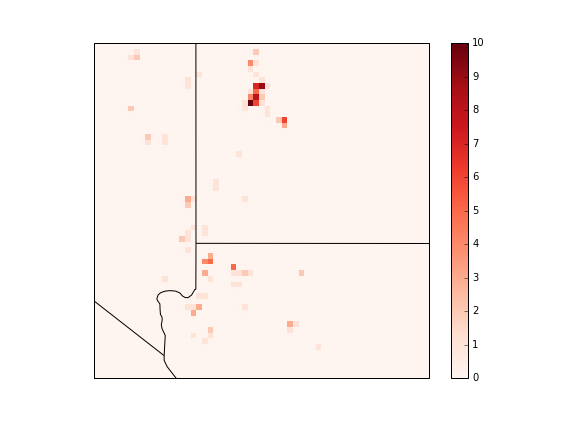
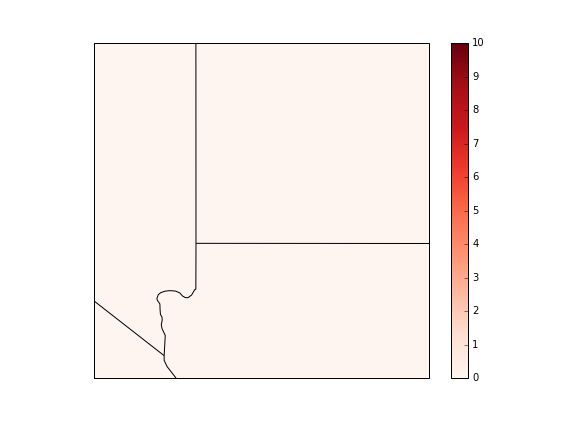
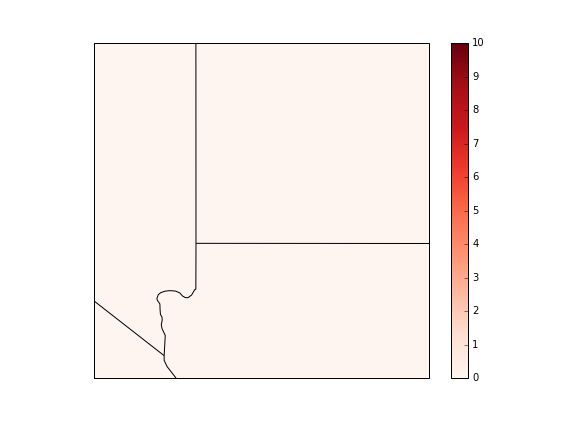
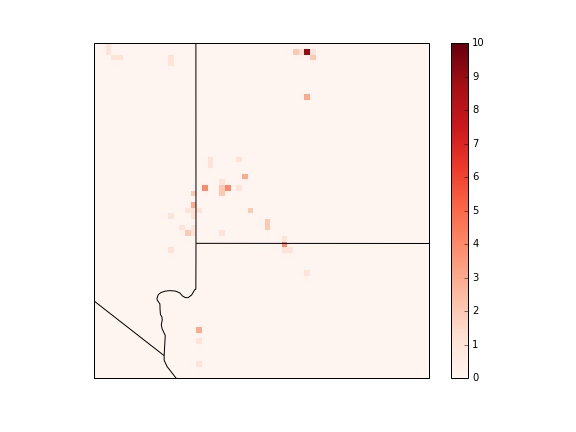
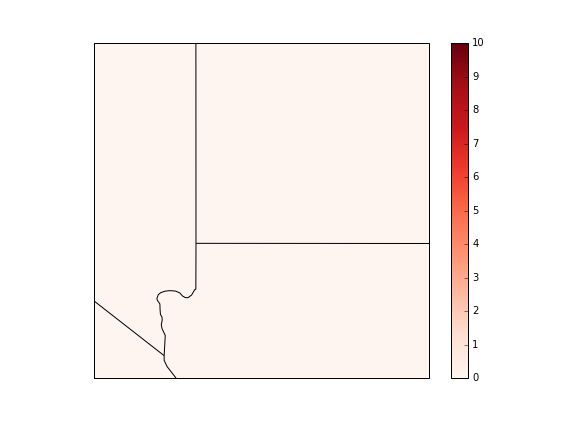
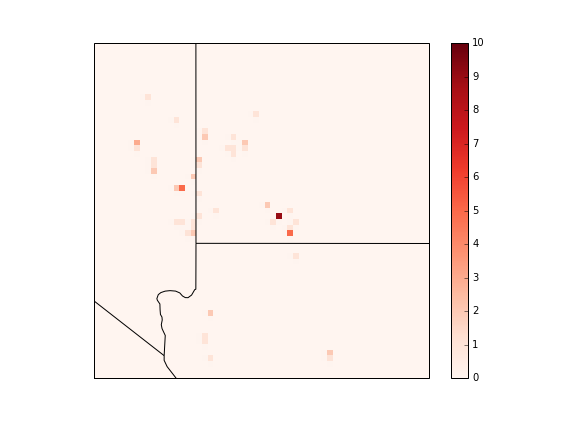
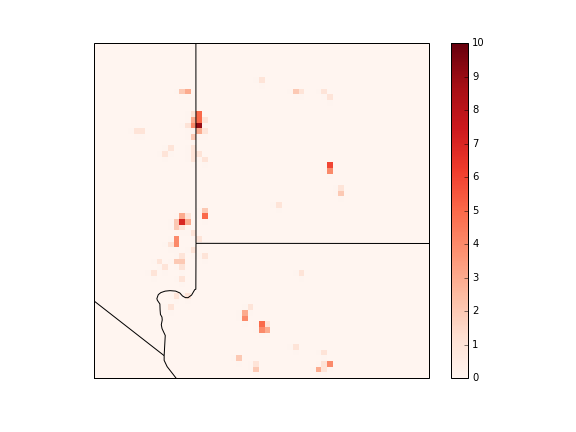
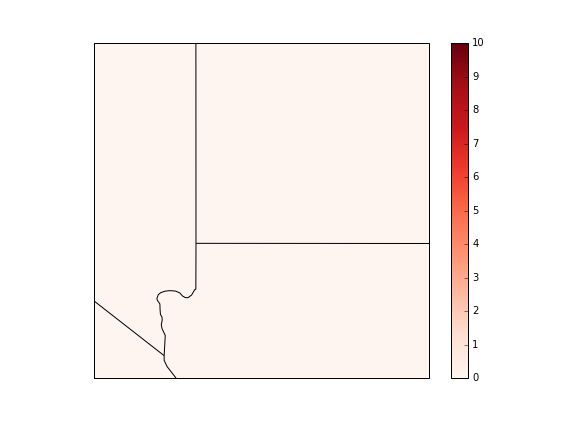
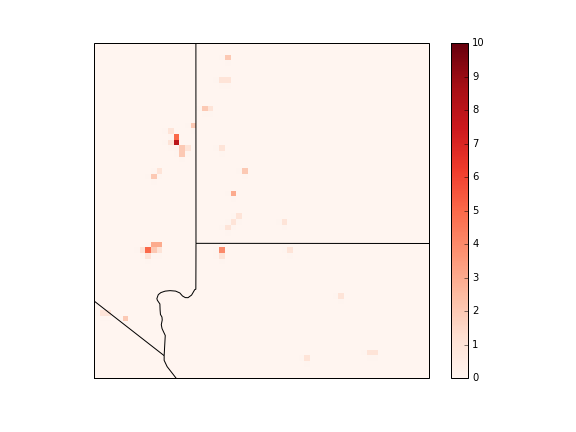
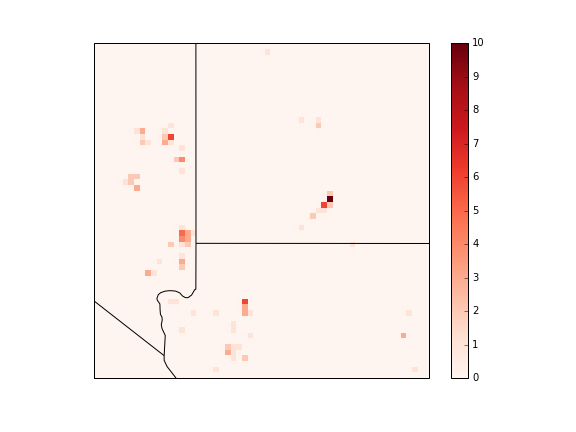
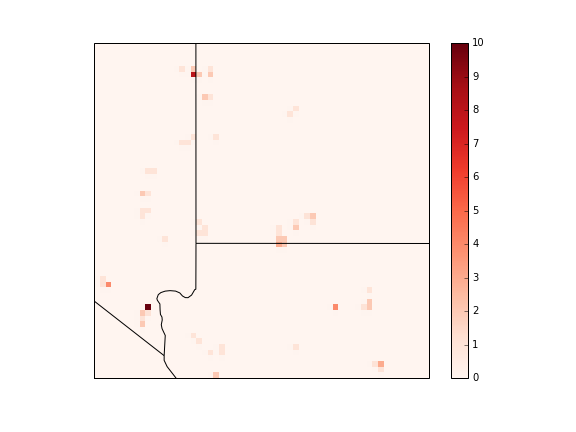
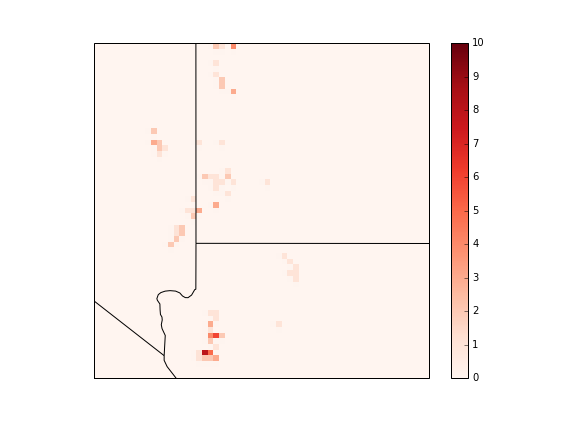

In [98]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
im = ax.imshow(box[0], cmap='Reds', interpolation='None', vmin=0, vmax=10,
               extent=[c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
plt.colorbar(im, ax=ax)

def init():
    im.set_data(box[0])
    return im,

def animate(i):
    im.set_data(box[i])
    return im,

animation.FuncAnimation(fig, animate, init_func=init, blit=False,
                        frames=288, interval=100)

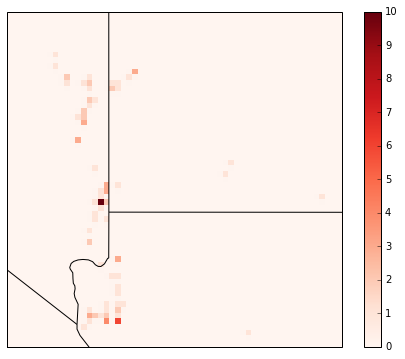

In [35]:
# %%timeit 33.8 ms for 600x600
# %%timeit 32.9 ms for 60x60

plt.figure(figsize=(8,6))
ax = background(plt.axes(projection=ccrs.PlateCarree()))
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
im = ax.imshow(box[110], cmap='Reds', interpolation='None',
               extent=[c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
plt.colorbar(im, ax=ax)

In [21]:
X, Y = np.meshgrid(c.gridx[0:-1], c.gridy[0:-1])

In [22]:
X.shape

(59, 59)

In [23]:
box = np.stack(d.values())

In [37]:
d = {}

ix0 = 0
ixn = 60
iy0 = 0
iyn = 60
ll = np.array([X[ix0:ixn,iy0:iyn].flatten('F'), Y[ix0:ixn,iy0:iyn].flatten('F')]).T
for i in range(box.shape[0]-1):
    hold = SpatialVx.make_SpatialVx(box[i,ix0:ixn,iy0:iyn], box[i+1,ix0:ixn,iy0:iyn], loc=ll)
    kwargs ={''}
    look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=1, min_size=2)

    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    px = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(px, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=20)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)

    d.update({tr[i]: pd.merge(df0, df3, how='outer')})

    

[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"
[1] "No matches found"


In [39]:
pd.Panel(d)

<class 'pandas.core.panel.Panel'>
Dimensions: 74 (items) x 12 (major_axis) x 21 (minor_axis)
Items axis: 2014-09-26 12:30:00 to 2014-09-27 11:50:00
Major_axis axis: 0 to 11
Minor_axis axis: centroidX to Hausdorff Distance